# Time Frames
    2000-01-01:2006-01-01
    2006-01-01:2011-01-01
    2011-01-01:2016-01-01
    2016-01-01:2020-04-02

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# import gurobipy as gp
# from gurobipy import GRB
from math import sqrt
import numpy as np

In [ ]:
import glob

# Path to the subfolder containing CSV files
path_to_subfolder = r'/Users/abhishekmalichkar/Documents/Columbia University/IEOR4004_PortfolioOptimizationPack'  # Replace with your subfolder path
csv_files = glob.glob(f"{path_to_subfolder}/*.csv")

# List to hold dataframes
dataframes = {}

# Loop through the files and read them into pandas DataFrames
for filename in csv_files:
    #print(filename.split("/")[-1])
    df = pd.read_csv(filename)
    #print(df)
    # dataframes[ filename.split("/")[1][:-4] ] = df
    dataframes[ filename.split("/")[-1][:-4] ] = df



In [ ]:
def find_common_times(dataframes):

    start = '2000-01-04'
    end = '2020-04-01'

    dates = None
    returns_dict = {}

    for stock in dataframes:

        df = dataframes[stock]

        df['Date'] = pd.to_datetime(df['Date'])

        mask = (df['Date'] >= start) & (df['Date'] <= end)

        filtered_df = df[mask]

        if len(filtered_df) == 5159:

            if dates is None:
                dates = filtered_df['Date'].values

            close_prices = filtered_df['Close'].values
            open_prices = filtered_df['Open'].values

            stock_return = (close_prices - open_prices) / open_prices

            returns_dict[stock] = stock_return

    returns_dict['Date'] = dates

    returns = pd.DataFrame(returns_dict)

    returns.set_index('Date', inplace=True)

    return returns

In [ ]:
returns = find_common_times(dataframes)
stocks = list(returns.columns)
returns_mini=returns.copy()

ValueError: ignored

In [ ]:
def show(data):
    data.plot(figsize =(15,4))
    plt.show()

In [ ]:
def statistics(dataset):
    return dataset.mean(), dataset.cov()

In [ ]:
show(returns)

NameError: ignored

# Drop stocks with a lot of Nan

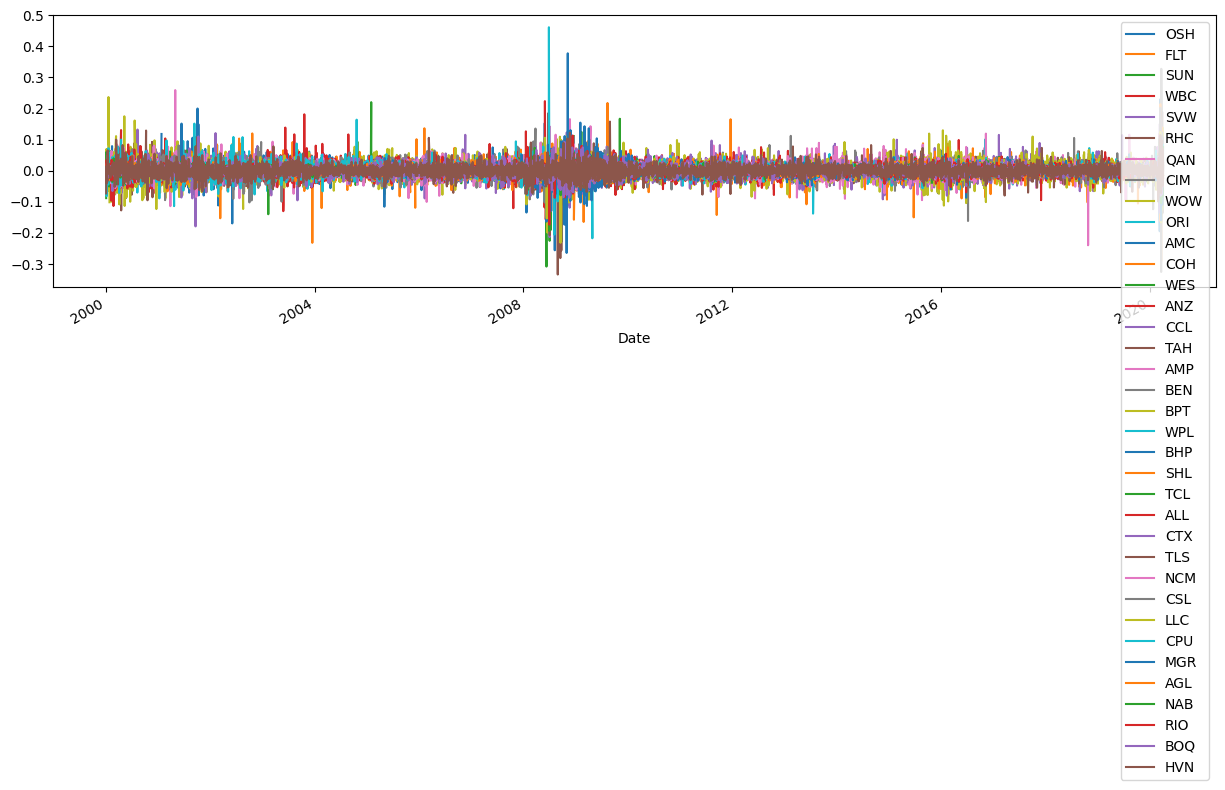

In [ ]:
returns_mini = returns.drop(columns=
                            [_ for _,__ in (returns.isna().sum()>10).items() if __])

show(returns_mini)

# Functions to Calculate different statistics

In [ ]:
def windowcovariance(dataset, start_date, end_date):
    returns_updated = dataset[start_date:end_date]
    window_covariance = returns_updated.cov()
    return window_covariance

In [ ]:
def windowstdev(dataset, start_date, end_date):
    returns_updated = dataset[start_date:end_date]
    window_stdev = returns_updated.std()
    return window_stdev

In [ ]:
def windowmean(dataset, start_date, end_date):
    returns_updated = dataset[start_date:end_date]
    window_mean = returns_updated.mean()
    return window_mean

In [ ]:
def windowcorr(dataset, start_date, end_date):
    returns_updated = dataset[start_date:end_date]
    window_corr = returns_updated.corr()
    return window_corr # Correlation section

# Correlation analysis

In [ ]:
# building of the correlation matrix
corr = windowcorr(returns_mini,'2000-01-01','2020-04-02')
print(corr)

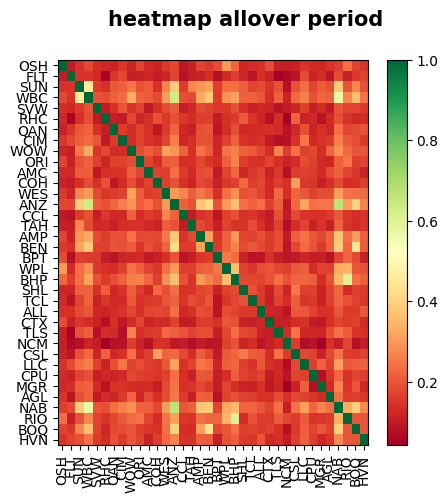

In [ ]:
# ploting heatmap
plt.figure(figsize=(5, 5))
plt.imshow(corr, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns)
plt.suptitle('heatmap allover period', fontsize=15, fontweight='bold')
plt.show()

In [ ]:
def uncorred_portfolio(returns, start_date, end_date, max_cor):
    corr = windowcorr(returns, start_date, end_date)
    keys = list(returns.keys())
    stock_to_remove = []
    for key1 in keys:
        for key2 in keys:
            if key1 != key2:
                if corr[key1][key2]>=max_cor:
                    if key1 not in stock_to_remove and key2 not in stock_to_remove:
                        if np.random.rand() >= 0.5:
                            stock_to_remove.append(key2)
                        else:
                            stock_to_remove.append(key1)
                    else:
                        if key1 in stock_to_remove:
                            stock_to_remove.append(key2)
                        if key2 in stock_to_remove:
                            stock_to_remove.append(key1)


    return stock_to_remove

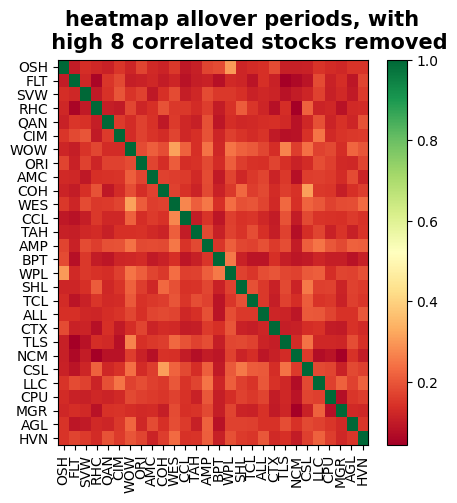

In [ ]:
# define correlation limit
corr_max = 0.4

returns_mini = returns_mini.drop(uncorred_portfolio(returns_mini, '2000-01-01','2020-04-02', corr_max), axis=1)

new_corr = windowcorr(returns_mini,'2000-01-01','2020-04-02')

plt.figure(figsize=(5, 5))
plt.imshow(new_corr, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(new_corr)), new_corr.columns, rotation='vertical')
plt.yticks(range(len(new_corr)), new_corr.columns)
nb_removed_stocks = np.shape(corr)[0]-np.shape(new_corr)[0]
plt.suptitle(f'heatmap allover periods, with \n high {nb_removed_stocks} correlated stocks removed', fontsize=15, fontweight='bold')
plt.show()

In [ ]:
num_stocks = len(returns_mini.columns)
print(num_stocks)

28


# QP Model 1 without Turnover Constraints

In [ ]:
def model1_without_turnover(dataset, start_date, end_date):

    print(dataset.shape)

    #define the statistics
    covariance = windowcovariance(dataset, start_date,end_date)
    sigma = covariance.to_numpy()

    mean = windowmean(dataset, start_date, end_date)
    me = mean.to_numpy()

    stdev = windowstdev(dataset, start_date, end_date)
    sd = stdev.to_numpy()

    #Create the optimization model
    m1 = gp.Model('portfolio_without_turnover')
    m1.Params.LogToConsole = 1
    x = m1.addMVar(num_stocks)

    #Set the objective
    print(x.shape)
    print(sigma.shape)
    portfolio_risk_objective = x @ sigma @ x
    m1.setObjective(portfolio_risk_objective, GRB.MINIMIZE)

    #Define the constraints
    m1.addConstr(x.sum() == 1, 'Total_Weight')

    # Optimize model to find the minimum risk portfolio
    m1.optimize()
    m1.Params.LogToConsole = 0

    #Get the minimum risk volatility and returns
    minimumrisk_volatility = sqrt(m1.ObjVal)
    minimumrisk_return = me @ x.X
    minimum_risk_portfolio_updated = pd.DataFrame(data=np.append(x.X, [minimumrisk_volatility, minimumrisk_return]),
             index=list(dataset.columns) + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])
    minimum_risk_portfolio = pd.DataFrame(x.X)

    #expected return for the portfolio
    portfolio_return = me @ x
    target = m1.addConstr(portfolio_return == minimumrisk_return, 'target')

    # Solve for efficient frontier by varying target return
    frontier = np.empty((2,0))
    for r in np.linspace(me.min(), me.max(), 30):
        target.rhs = r
        m1.optimize()
        frontier = np.append(frontier, [[sqrt(m1.ObjVal)],[r]], axis=1)

    m1.reset(1)
    return frontier, minimumrisk_return, minimumrisk_volatility, minimum_risk_portfolio

# QP Model 2 with turnover constraints

In [ ]:
def model2_with_turnover(dataset, previous_weights, e,start_date, end_date):

    #define the statistics
    covariance = windowcovariance(dataset, start_date, end_date)
    sigma = covariance.to_numpy()

    mean = windowmean(dataset, start_date, end_date)
    me = mean.to_numpy()

    stdev = windowstdev(dataset, start_date, end_date)
    sd = stdev.to_numpy()

    #Create the optimization model
    m2 = gp.Model('portfolio_with_turnover')
    m2.Params.LogToConsole = 1
    y = m2.addMVar(num_stocks)

    #Set the objective
    portfolio_risk_objective = y @ sigma @ y
    m2.setObjective(portfolio_risk_objective, GRB.MINIMIZE)

    #Define the constraints
    m2.addConstr(y.sum() == 1, 'Total_Weight')
    m2.addConstr(y <= previous_weights + e, 'Turnover_Max')
    m2.addConstr(y >= previous_weights - e, 'Turnover_Min')

    # Optimize model to find the minimum risk portfolio
    m2.optimize()

    #Get the minimum risk volatility and returns
    minimumrisk_volatility = sqrt(m2.ObjVal)
    minimumrisk_return = me @ y.X
    minimum_risk_portfolio_updated = pd.DataFrame(data=np.append(y.X, [minimumrisk_volatility, minimumrisk_return]),
             index=list(dataset.columns) + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])
    minimum_risk_portfolio = pd.DataFrame(y.X)

    m2.reset(1)
    return minimumrisk_return, minimumrisk_volatility, minimum_risk_portfolio

# Plotting the Efficient Frontier

In [ ]:
#Plotting the regular frontier curve

def plot_frontier(frontier, minimumrisk_return, minimumrisk_volatility, sigma, me, sd):
    fig, ax = plt.subplots(figsize=(20,16))
    # Plot volatility versus expected return for individual stocks
    ax.scatter(x=sd, y=me, color='Red', label='Individual Stocks')

    # Plot volatility versus expected return for minimum risk portfolio
    ax.scatter(x=minimumrisk_volatility, y=minimumrisk_return, color='DarkGreen')
    ax.annotate('Minimum\nRisk\nPortfolio', (minimumrisk_volatility, minimumrisk_return), horizontalalignment='right')

    # Plot efficient frontier
    ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

    # Format and display the final plot
    ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, me.min()*1.2, me.max()*1.2])
    ax.set_xlabel('Volatility (standard deviation)')
    ax.set_ylabel('Expected Return')
    ax.legend()
    ax.grid()
    plt.show()

# Period 1 Optimization

In [ ]:
def period1 ():
    sigma1 = windowcovariance(returns_mini,'2000-01-01','2006-01-01').to_numpy()
    me1 = windowmean(returns_mini, '2000-01-01','2006-01-01').to_numpy()
    sd1 = windowstdev(returns_mini, '2000-01-01','2006-01-01').to_numpy()

    frontier11, minimumrisk_return11, minimumrisk_volatility11, minimum_risk_portfolio11 = model1_without_turnover(returns_mini, '2000-01-01','2006-01-01')

    data1 = {'Period':[1,1],
        'Model': ['Without Turnover Constraints', 'With Turnover Constraints'],
        'Min_Risk_Return': [minimumrisk_return11, '-'],
        'Min_Risk_Volatility':[minimumrisk_volatility11, '-'],
        'Min_Risk_Portfolio':[minimum_risk_portfolio11, '-']
       }
    df1 = pd.DataFrame(data1)

    plot_frontier(frontier11, minimumrisk_return11, minimumrisk_volatility11, sigma1, me1, sd1)

    return df1, minimum_risk_portfolio11

# Period 2 Optimization

In [ ]:
def period2 (i, minimum_risk_portfolio11):
    e = np.full((num_stocks, 1), i)
    sigma2 = windowcovariance(returns_mini,'2000-01-01','2006-01-01').to_numpy()
    me2 = windowmean(returns_mini, '2000-01-01','2006-01-01').to_numpy()
    sd2 = windowstdev(returns_mini, '2000-01-01','2006-01-01').to_numpy()

    frontier21, minimumrisk_return21, minimumrisk_volatility21, minimum_risk_portfolio21 = model1_without_turnover(returns_mini, '2006-01-01','2011-01-01')
    minimumrisk_return22, minimumrisk_volatility22, minimum_risk_portfolio22 = model2_with_turnover(returns_mini, minimum_risk_portfolio11.to_numpy(), e,'2006-01-01','2011-01-01')

    data2 = {'e': [i,i],'Period':[2,2],
        'Model': ['Without Turnover Constraints', 'With Turnover Constraints'],
        'Min_Risk_Return': [minimumrisk_return21, minimumrisk_return22],
        'Min_Risk_Volatility':[minimumrisk_volatility21, minimumrisk_volatility22],
        'Min_Risk_Portfolio':[minimum_risk_portfolio21, minimum_risk_portfolio22],
       }

    df2 = pd.DataFrame(data2)

    plot_frontier(frontier21, minimumrisk_return21, minimumrisk_volatility21, sigma2, me2, sd2)

    return df2, minimum_risk_portfolio22

# Period 3 Optimization

In [ ]:
def period3(i, minimum_risk_portfolio22):
    e = np.full((num_stocks, 1), i)
    sigma3 = windowcovariance(returns_mini,'2011-01-01','2016-01-01').to_numpy()
    me3 = windowmean(returns_mini,'2011-01-01','2016-01-01').to_numpy()
    sd3 = windowstdev(returns_mini,'2011-01-01','2016-01-01').to_numpy()

    frontier31, minimumrisk_return31, minimumrisk_volatility31, minimum_risk_portfolio31 = model1_without_turnover(returns_mini,'2011-01-01','2016-01-01')
    minimumrisk_return32, minimumrisk_volatility32, minimum_risk_portfolio32 = model2_with_turnover(returns_mini, minimum_risk_portfolio22.to_numpy(), e,'2011-01-01','2016-01-01')

    data3 = {'e': [i,i], 'Period':[3,3],
        'Model': ['Without Turnover Constraints', 'With Turnover Constraints'],
        'Min_Risk_Return': [minimumrisk_return31, minimumrisk_return32],
        'Min_Risk_Volatility':[minimumrisk_volatility31, minimumrisk_volatility32],
        'Min_Risk_Portfolio':[minimum_risk_portfolio31, minimum_risk_portfolio32],
       }
    df3 = pd.DataFrame(data3)

    plot_frontier(frontier31, minimumrisk_return31, minimumrisk_volatility31, sigma3, me3, sd3)

    return df3, minimum_risk_portfolio32

# Period 4 Optimization

In [ ]:
def period4(i, minimum_risk_portfolio32):
    e = np.full((num_stocks, 1), i)
    sigma4 = windowcovariance(returns_mini,'2016-01-01','2020-04-02').to_numpy()
    me4 = windowmean(returns_mini,'2016-01-01','2020-04-02').to_numpy()
    sd4 = windowstdev(returns_mini,'2016-01-01','2020-04-02').to_numpy()

    frontier41, minimumrisk_return41, minimumrisk_volatility41, minimum_risk_portfolio41 = model1_without_turnover(returns_mini,'2016-01-01','2020-04-02')
    minimumrisk_return42, minimumrisk_volatility42, minimum_risk_portfolio42 = model2_with_turnover(returns_mini, minimum_risk_portfolio32.to_numpy(), e,'2016-01-01','2020-04-02')

    data4 = {'e': [i,i], 'Period':[4,4],
        'Model': ['Without Turnover Constraints', 'With Turnover Constraints'],
        'Min_Risk_Return': [minimumrisk_return41, minimumrisk_return42],
        'Min_Risk_Volatility':[minimumrisk_volatility41, minimumrisk_volatility42],
        'Min_Risk_Portfolio':[minimum_risk_portfolio41, minimum_risk_portfolio42],
       }
    df4 = pd.DataFrame(data4)

    plot_frontier(frontier41, minimumrisk_return41, minimumrisk_volatility41, sigma4, me4, sd4)

    return df4

(5159, 28)
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-19
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x37b34995
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal  

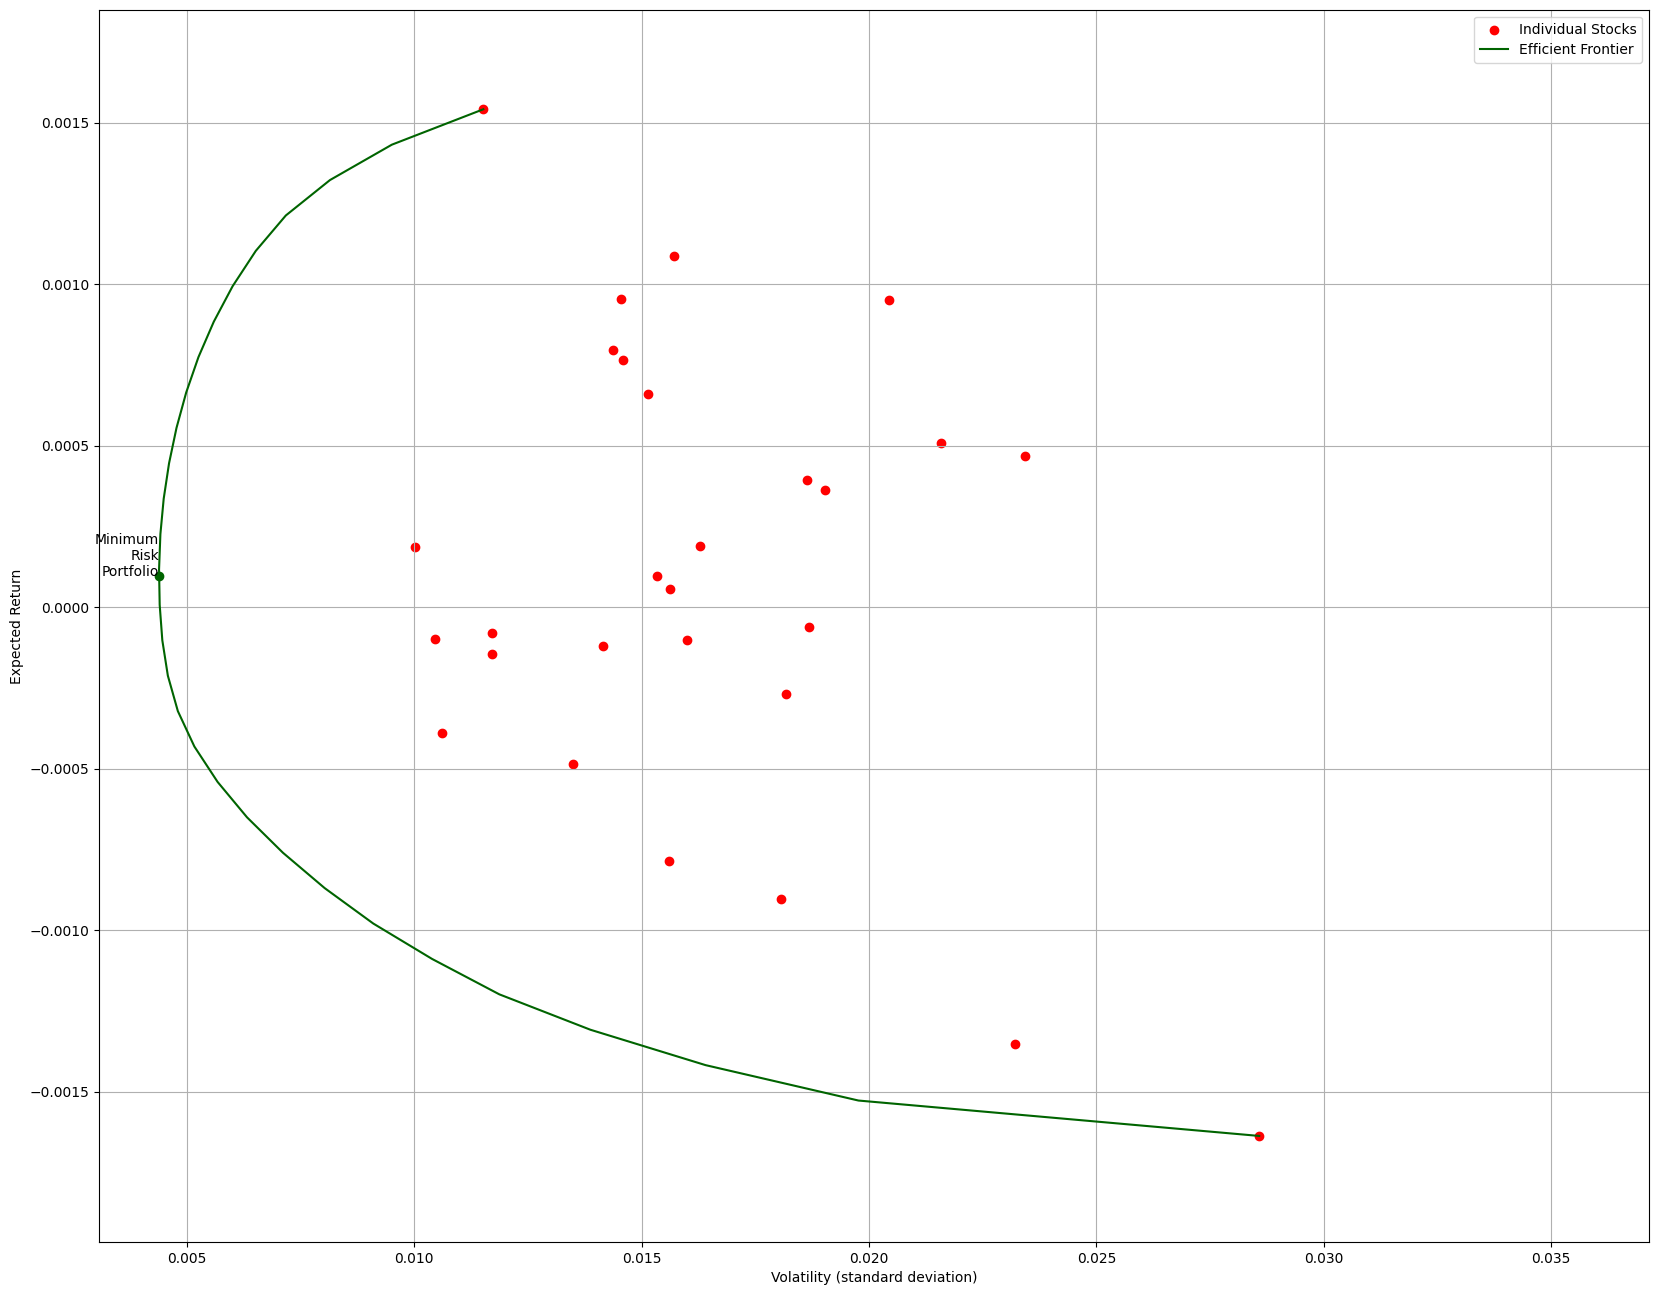

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0xe7bfdbff
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41183768e+05 -1.41183768e+05  2.80e+04 1.92e-06  1.00e+0

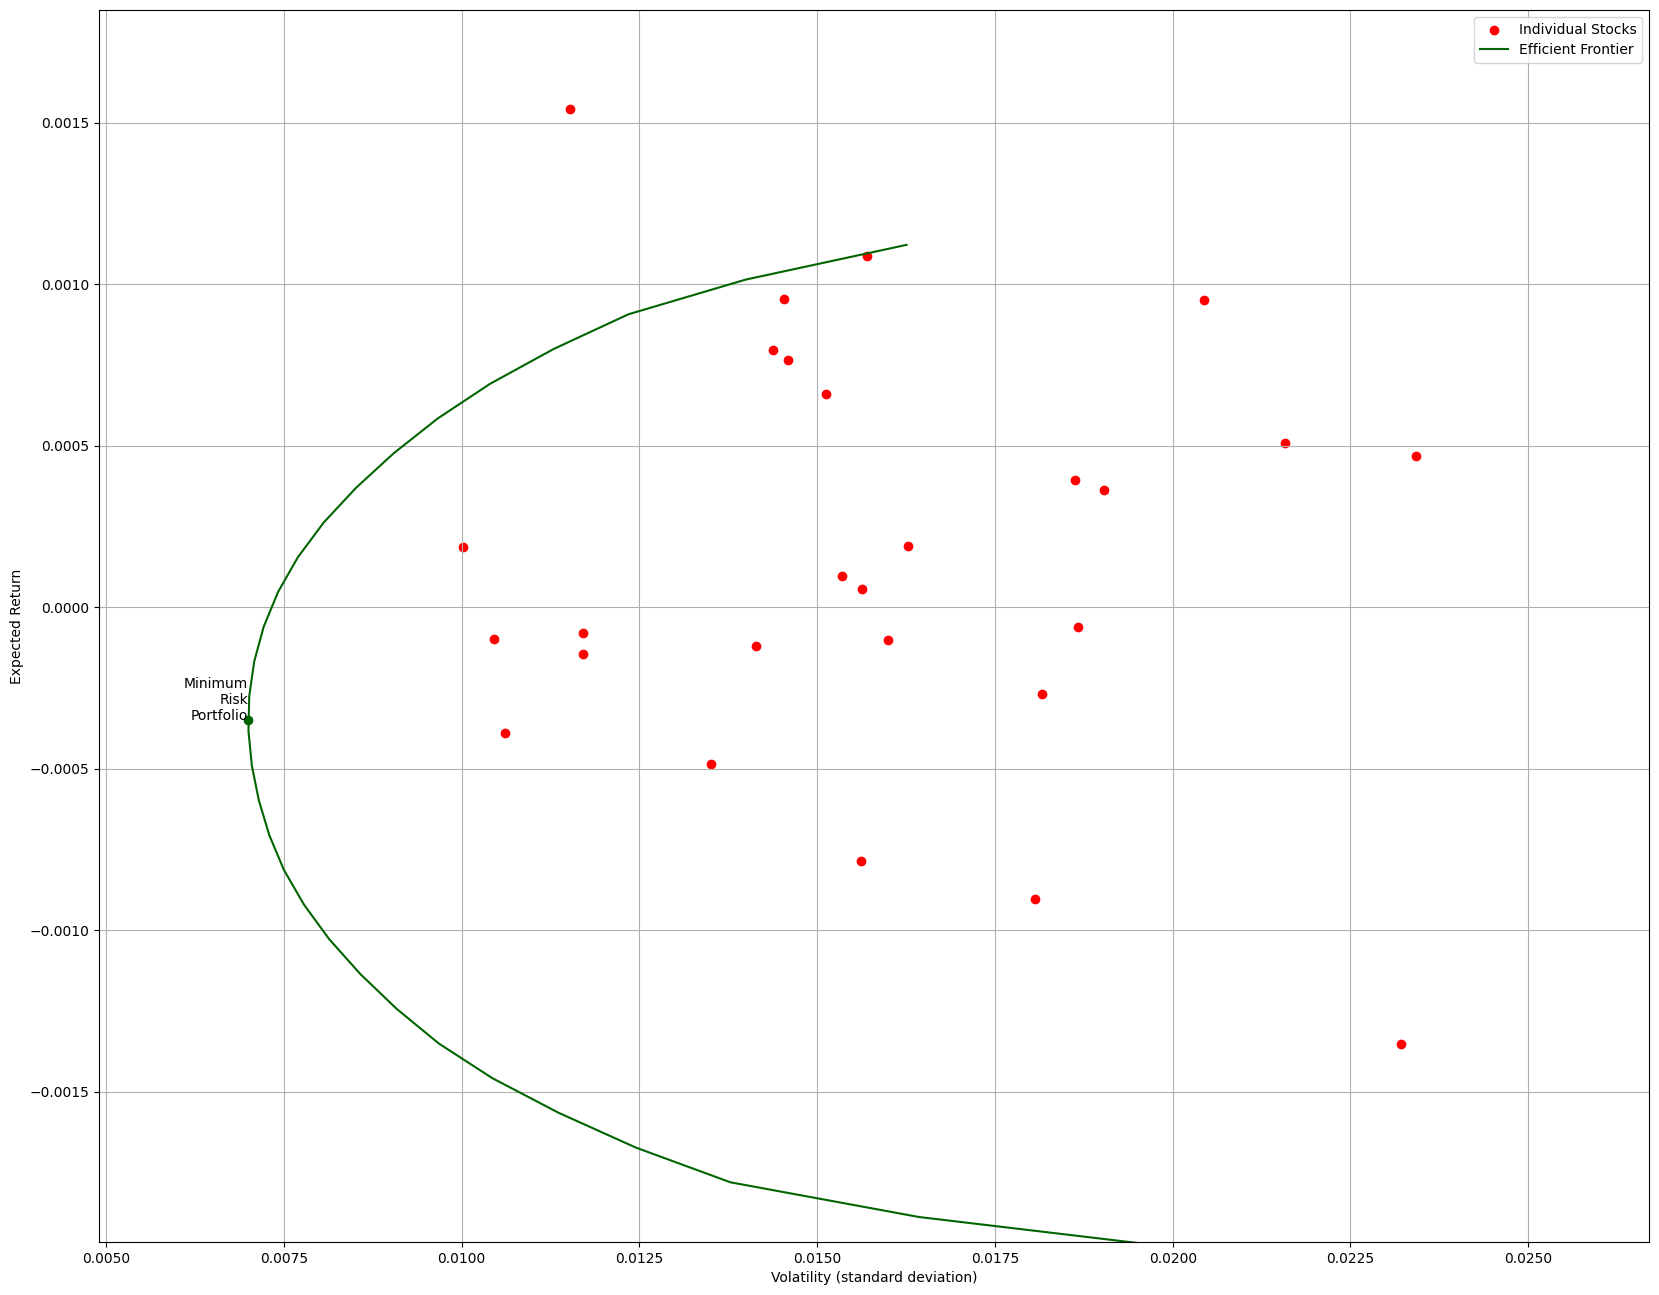

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x2f1c4daa
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.29758098e+05 -2.29758098e+05  2.80e+04 3.18e-07  1.00e+0

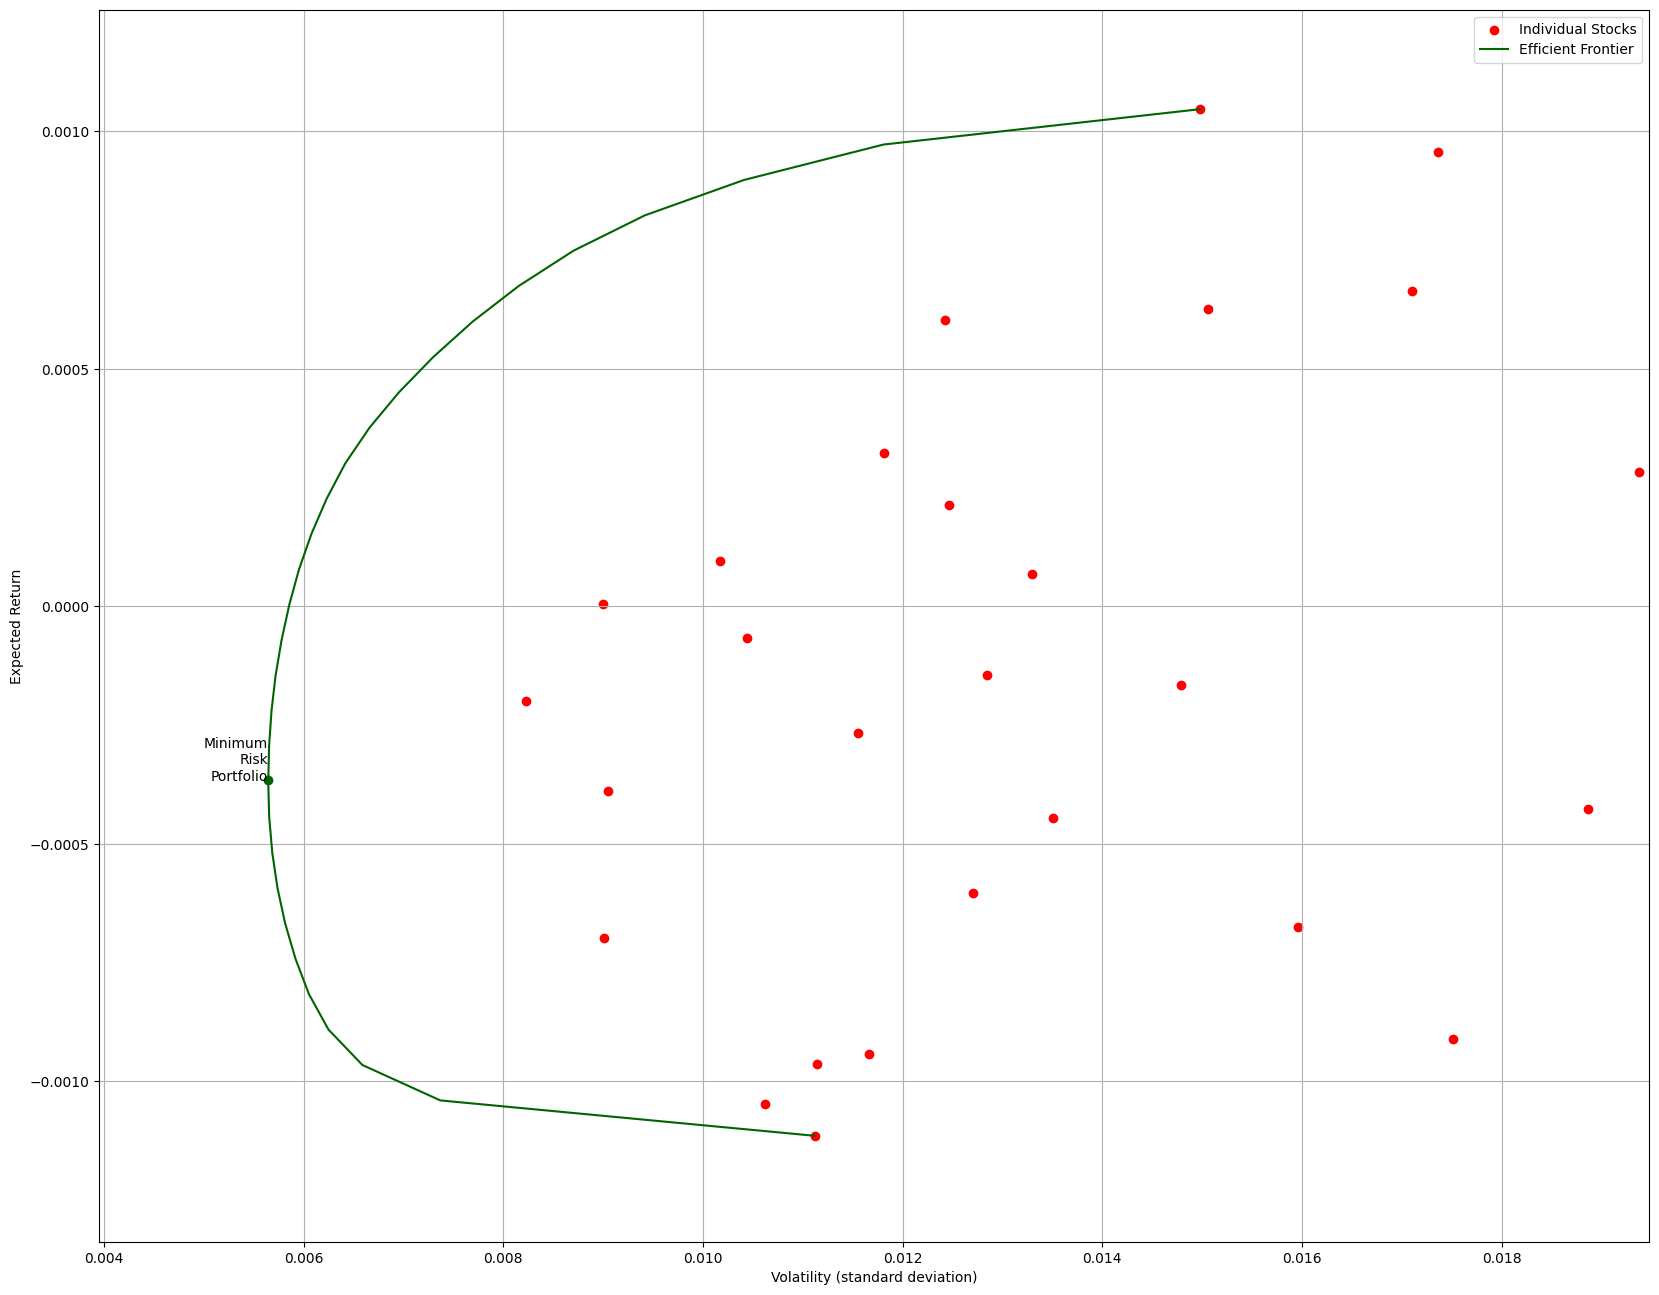

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x71fa6bef
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.89925600e+05 -2.89925600e+05  2.75e+04 5.36e-05  1.00e+0

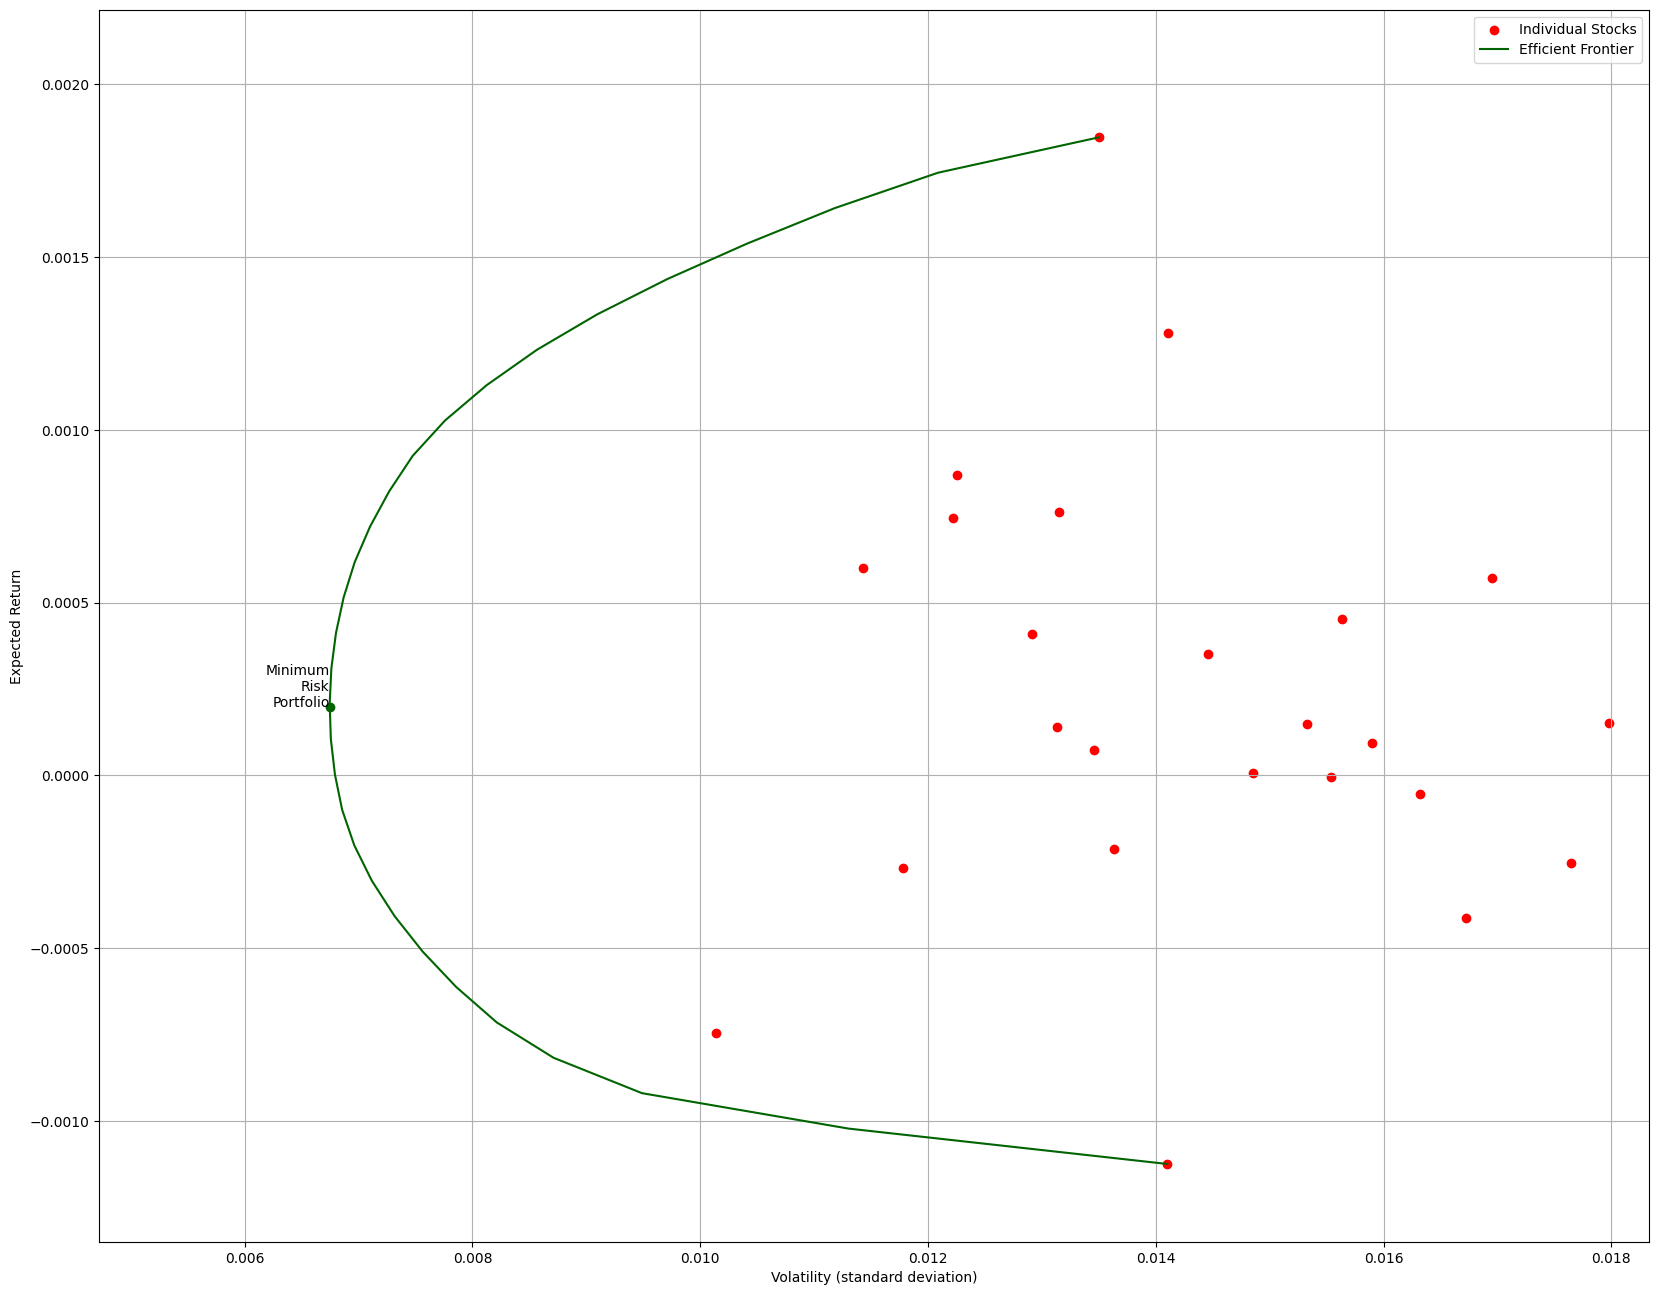

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x37b34995
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.33313395e+05 -2.33313395e+05  2.65e+04 8.83e-08  1.00e+0

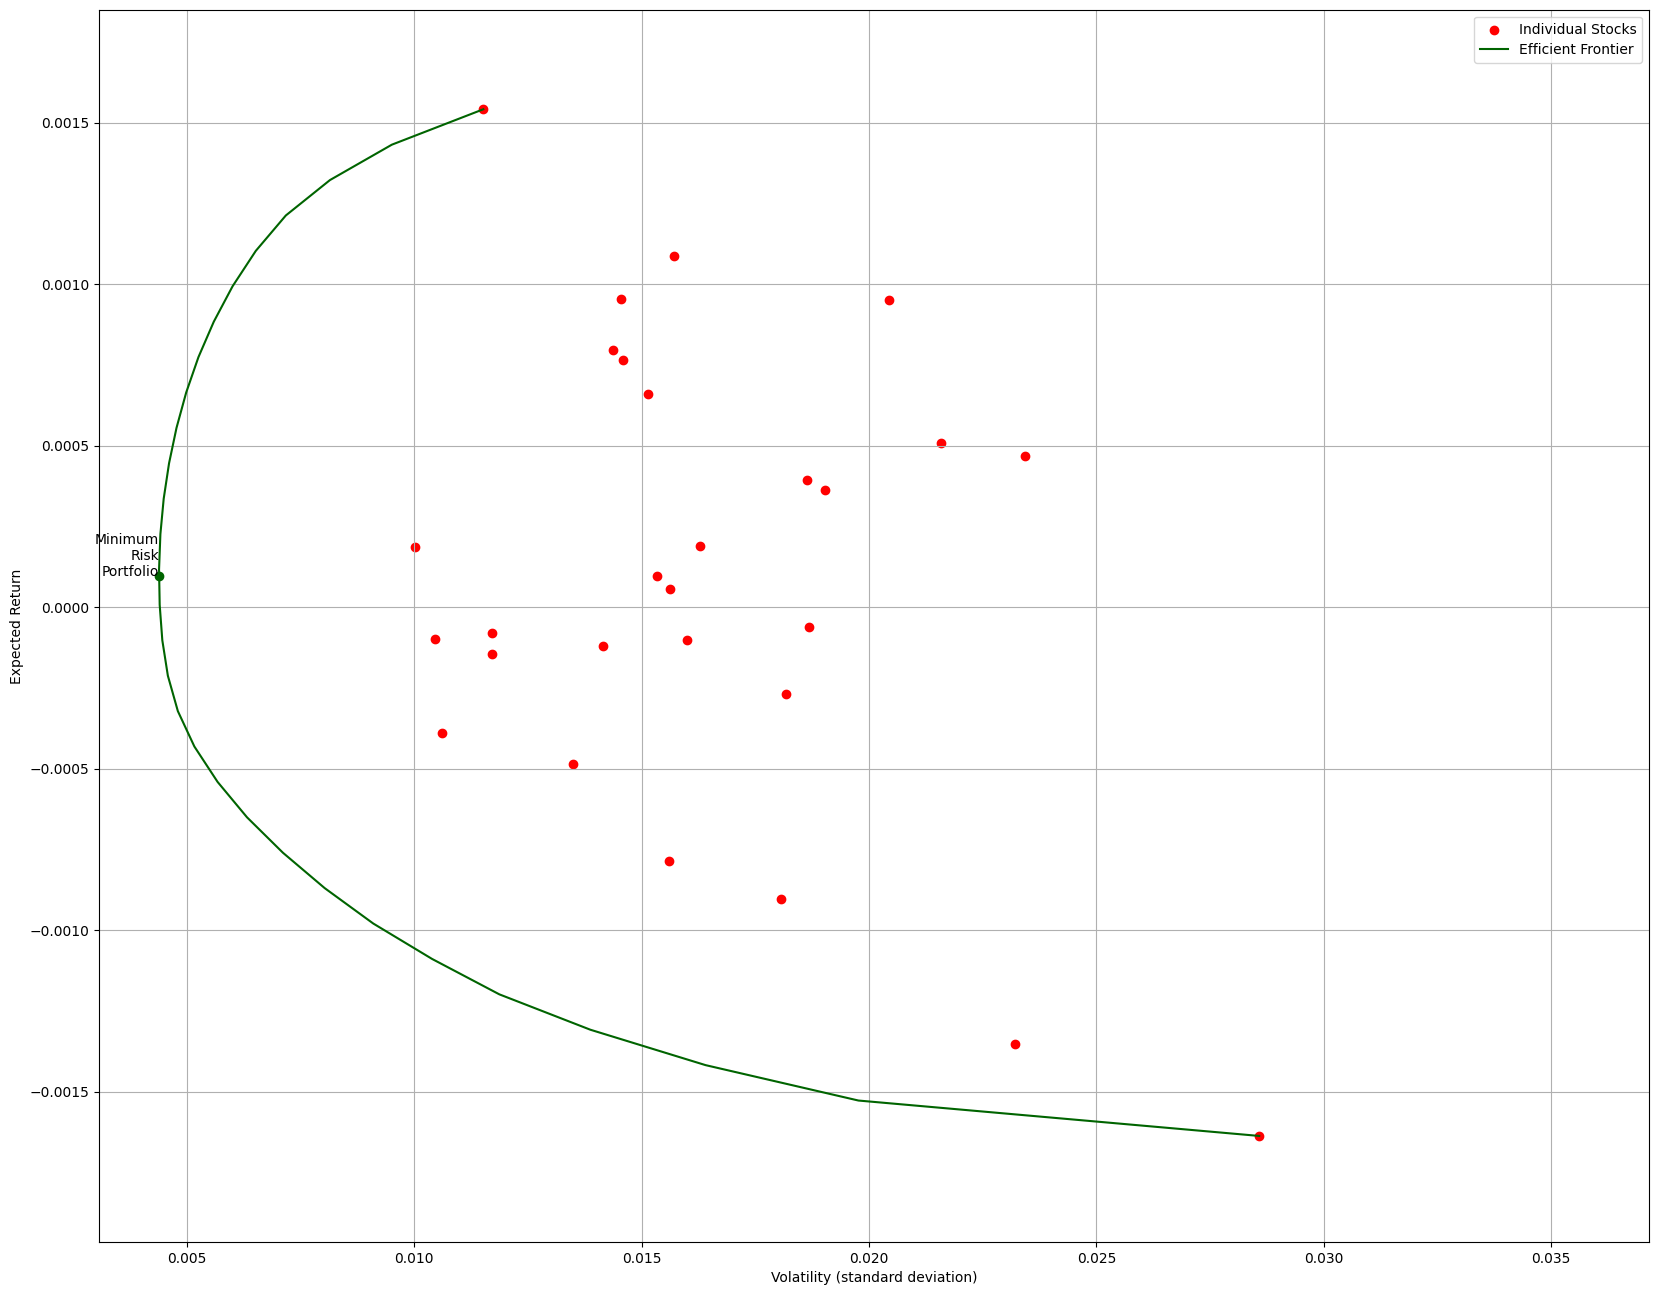

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0xe7bfdbff
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41183768e+05 -1.41183768e+05  2.80e+04 1.92e-06  1.00e+0

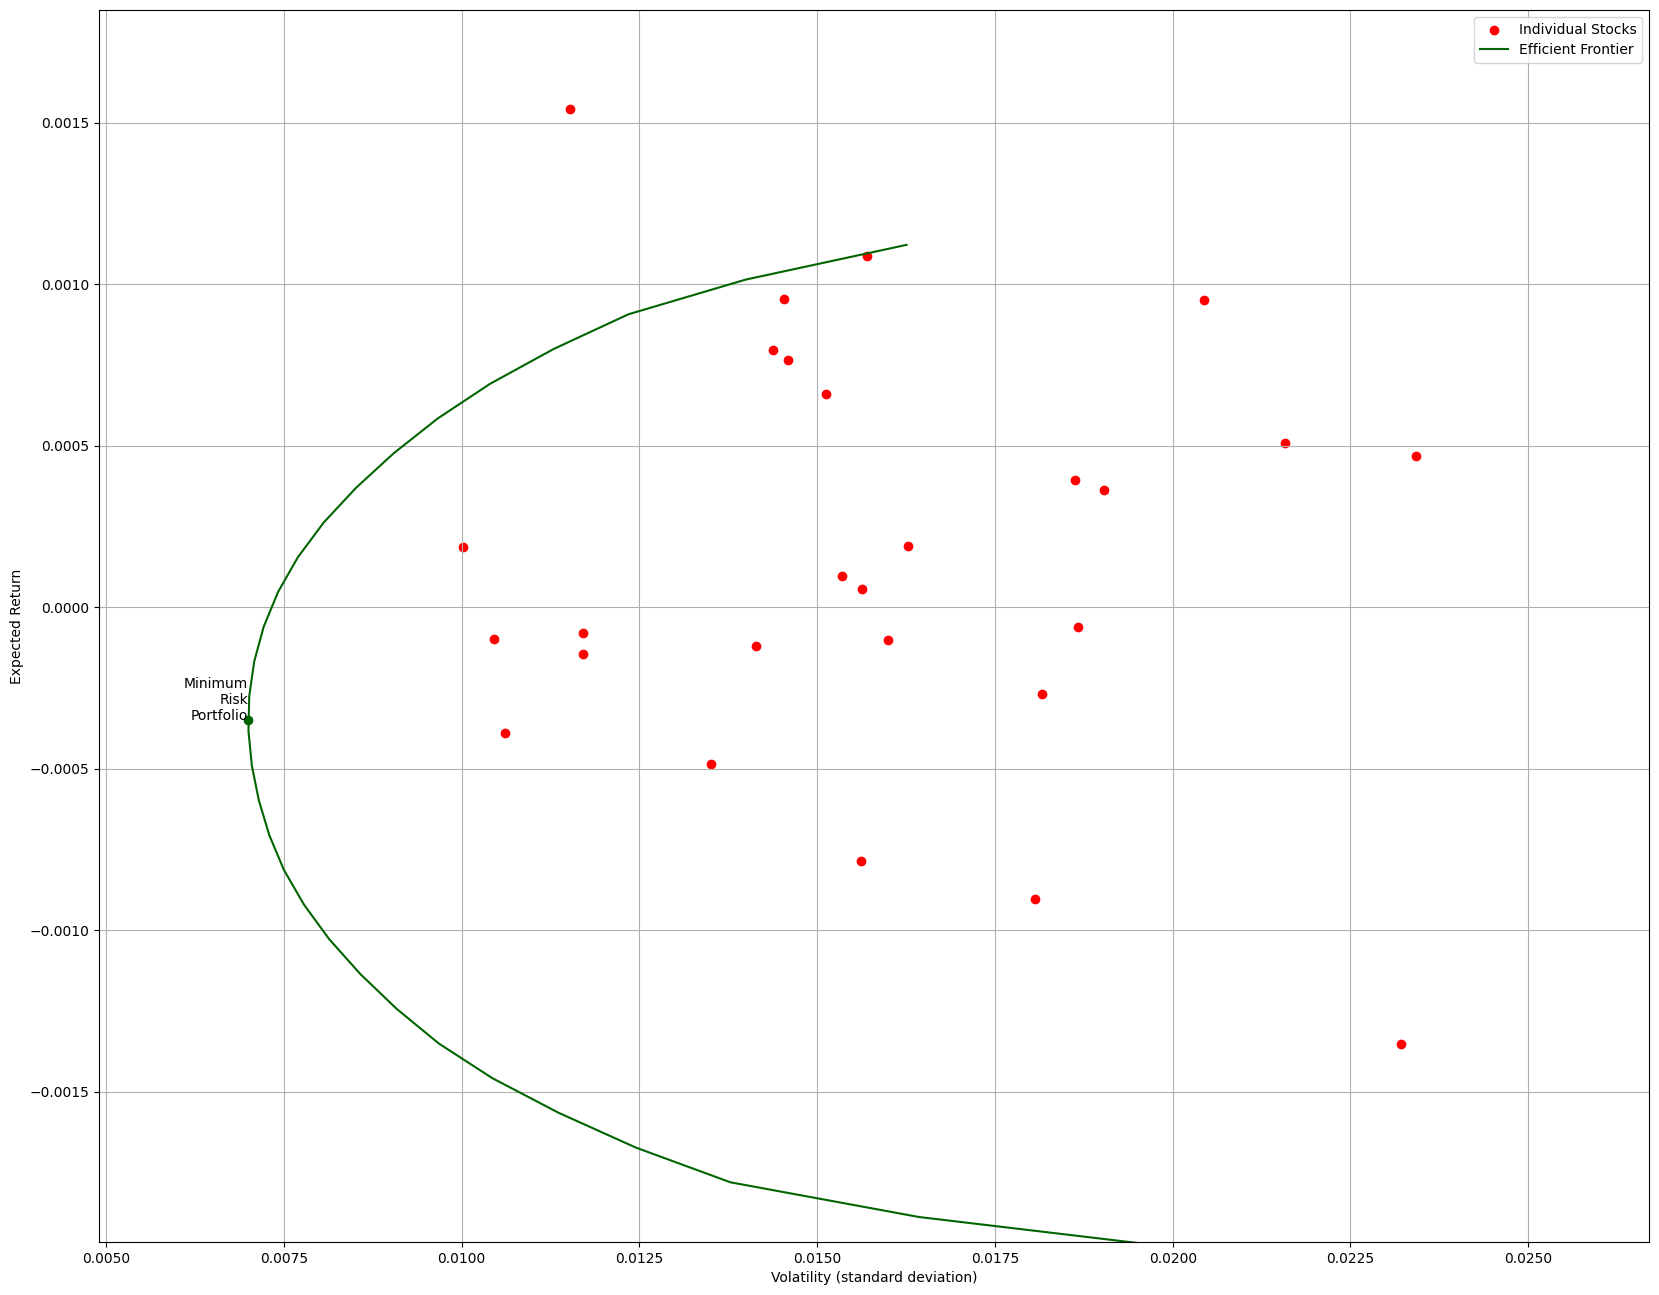

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x2f1c4daa
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.29758098e+05 -2.29758098e+05  2.80e+04 3.18e-07  1.00e+0

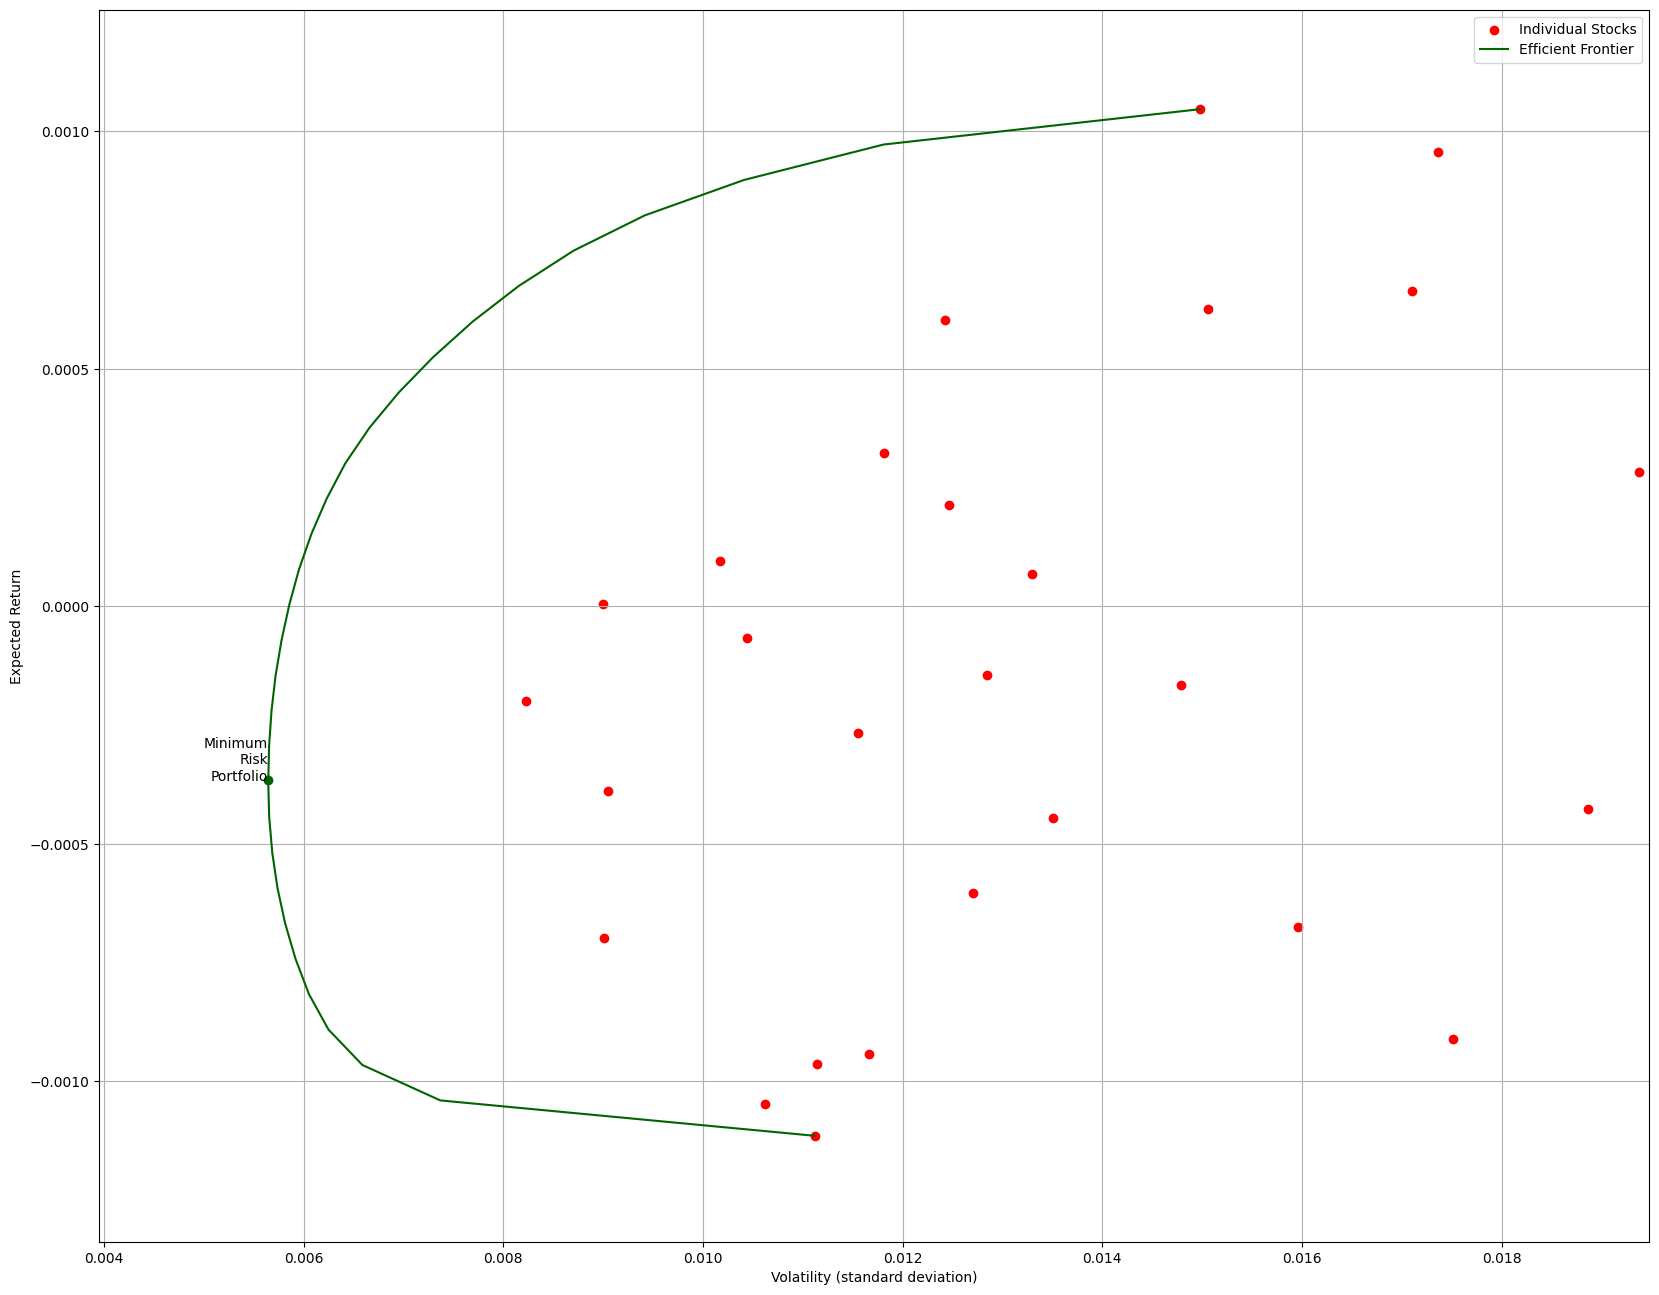

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x71fa6bef
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.89925600e+05 -2.89925600e+05  2.75e+04 5.36e-05  1.00e+0

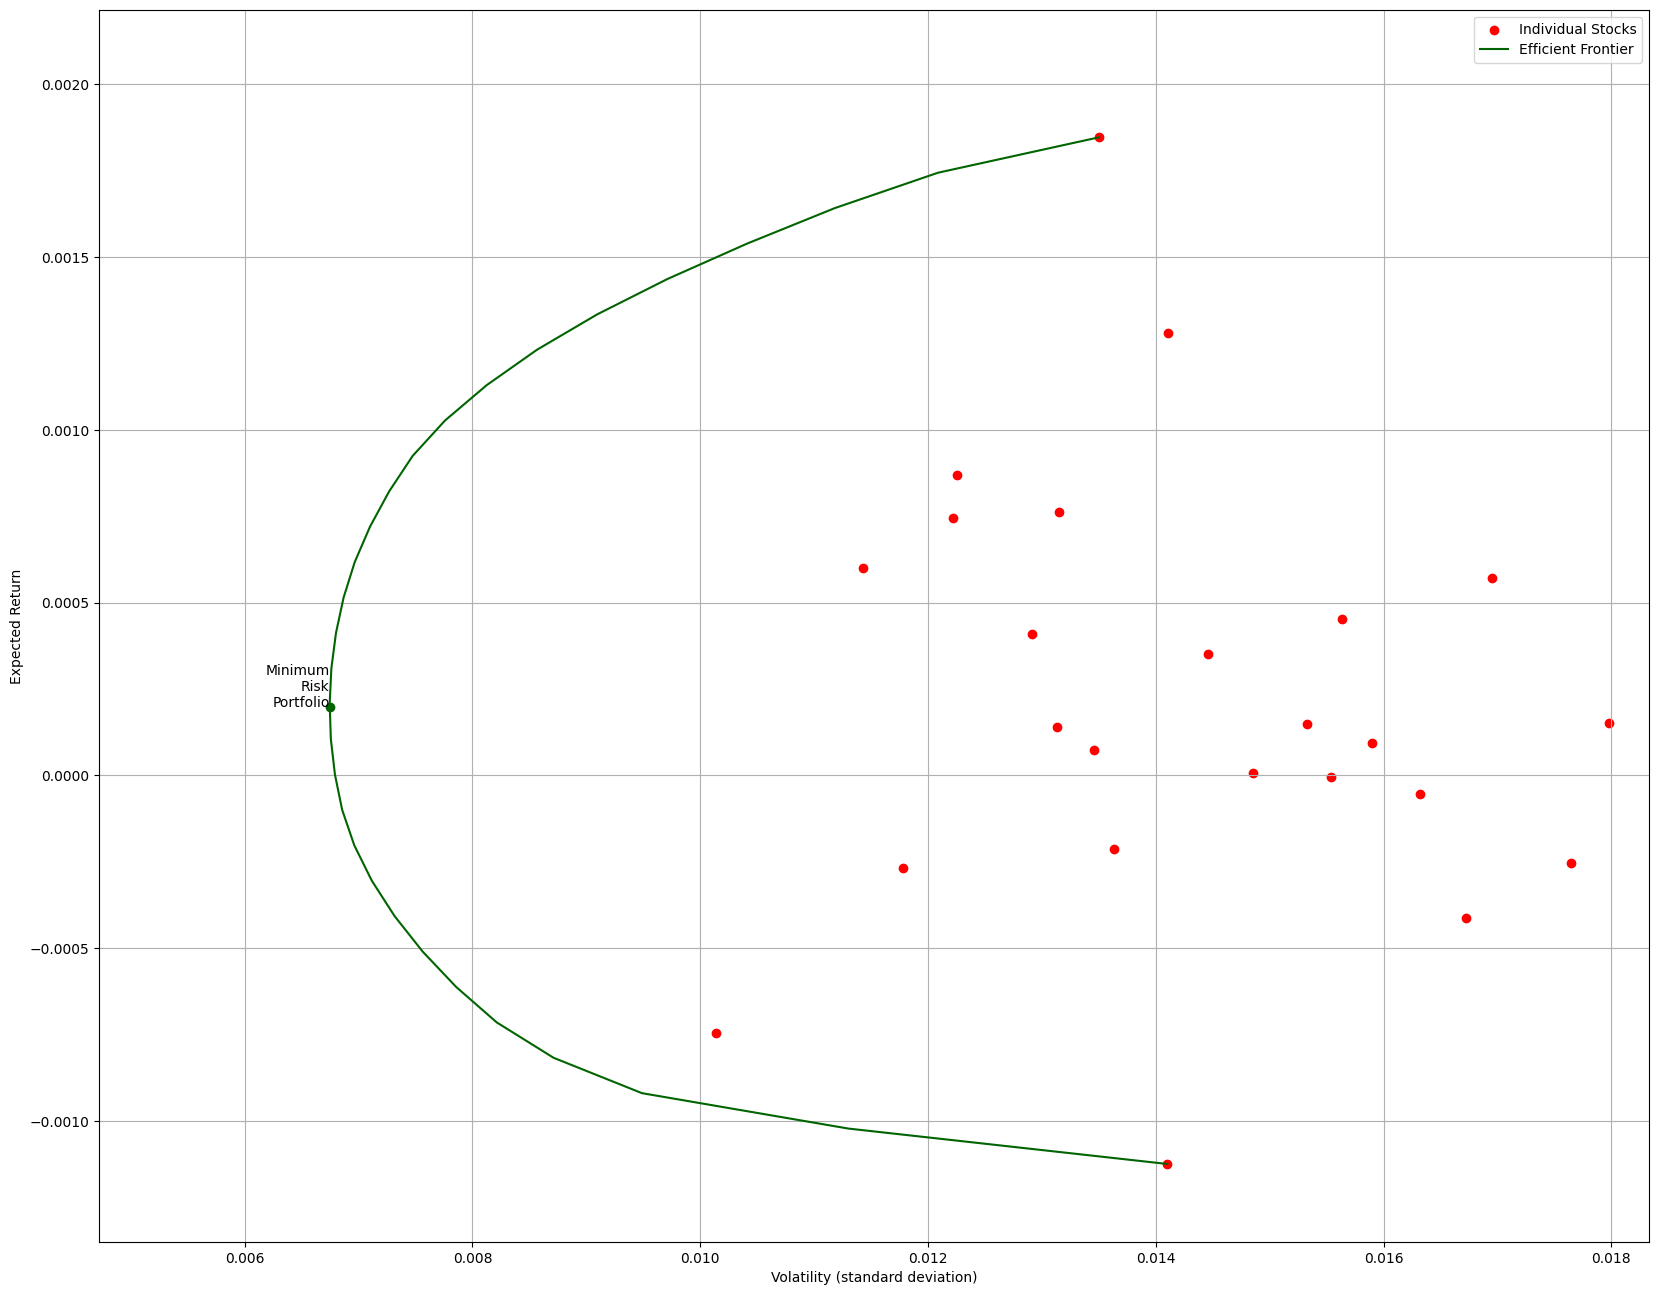

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x37b34995
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.33313395e+05 -2.33313395e+05  2.65e+04 8.83e-08  1.00e+0

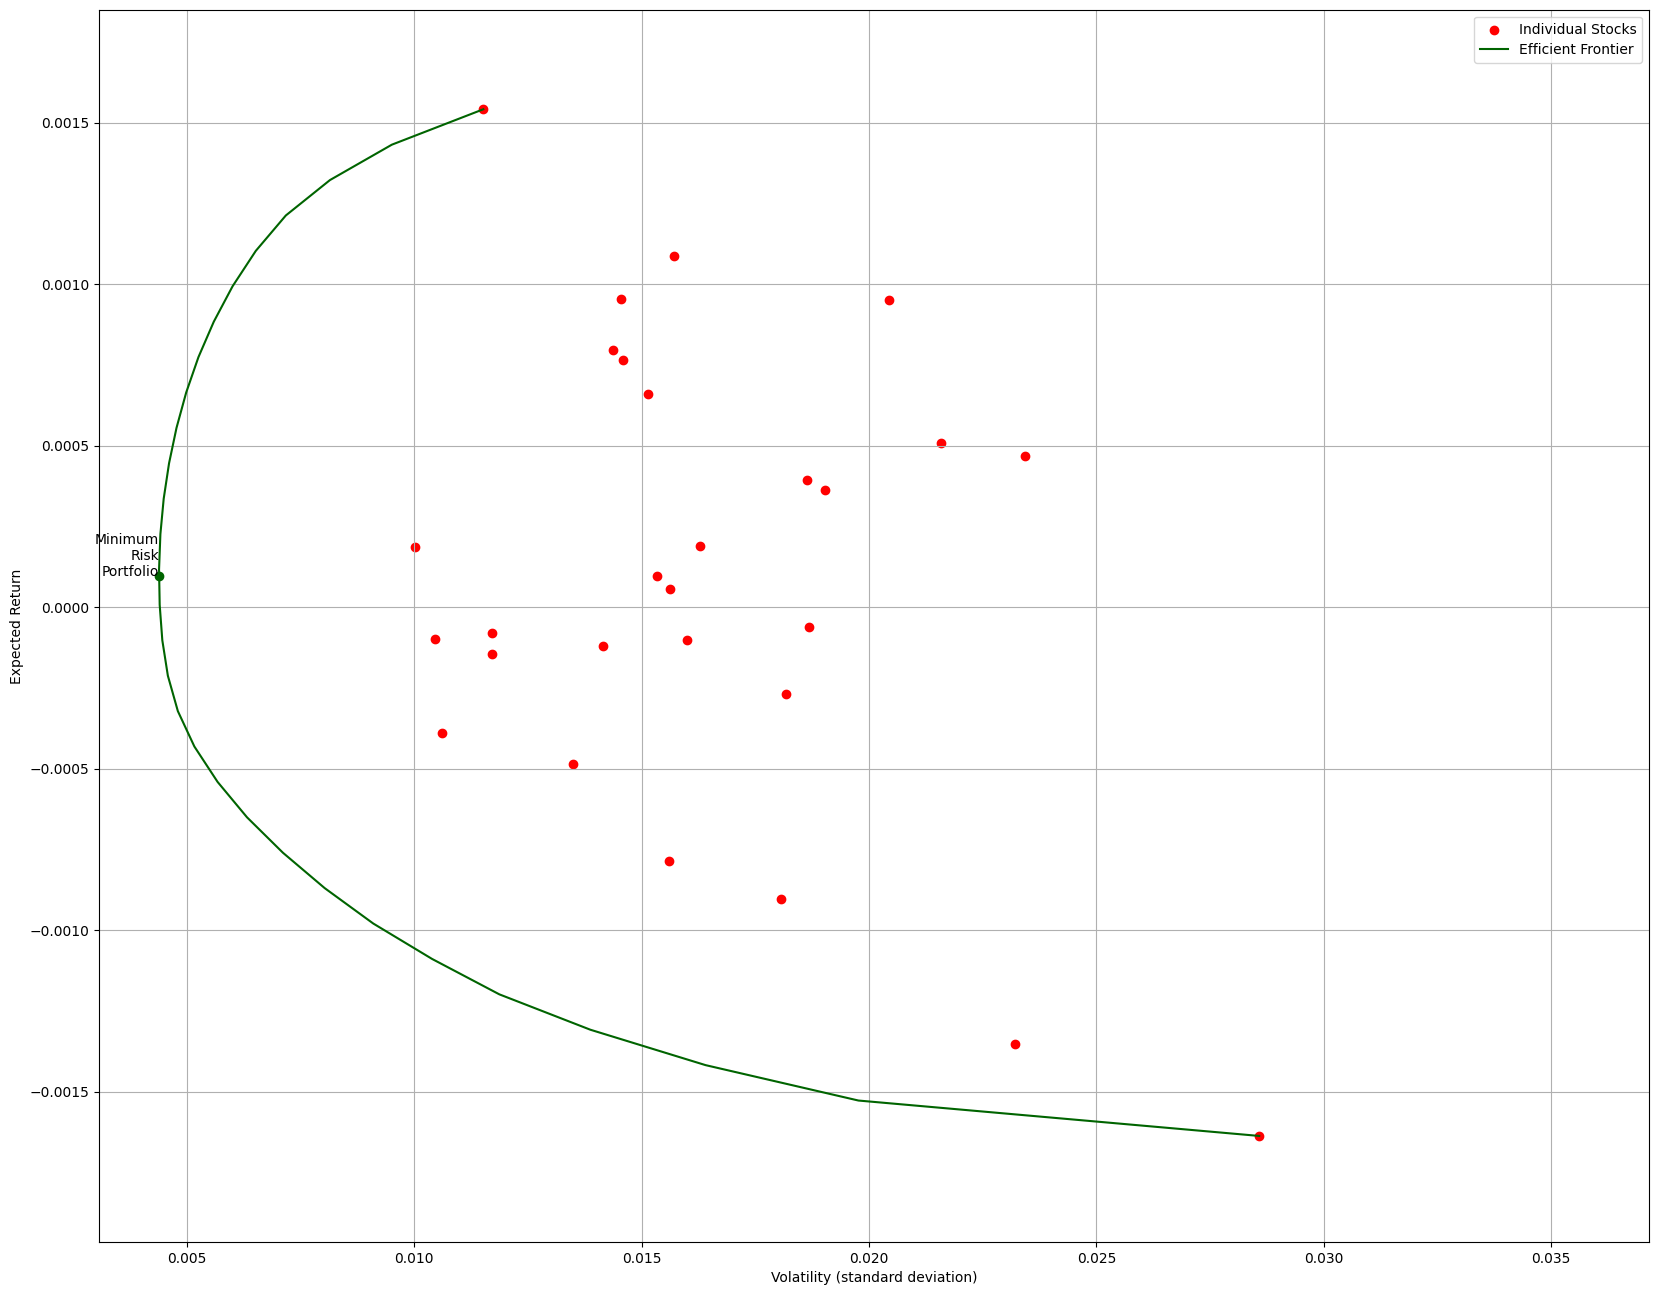

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0xe7bfdbff
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41183768e+05 -1.41183768e+05  2.80e+04 1.92e-06  1.00e+0

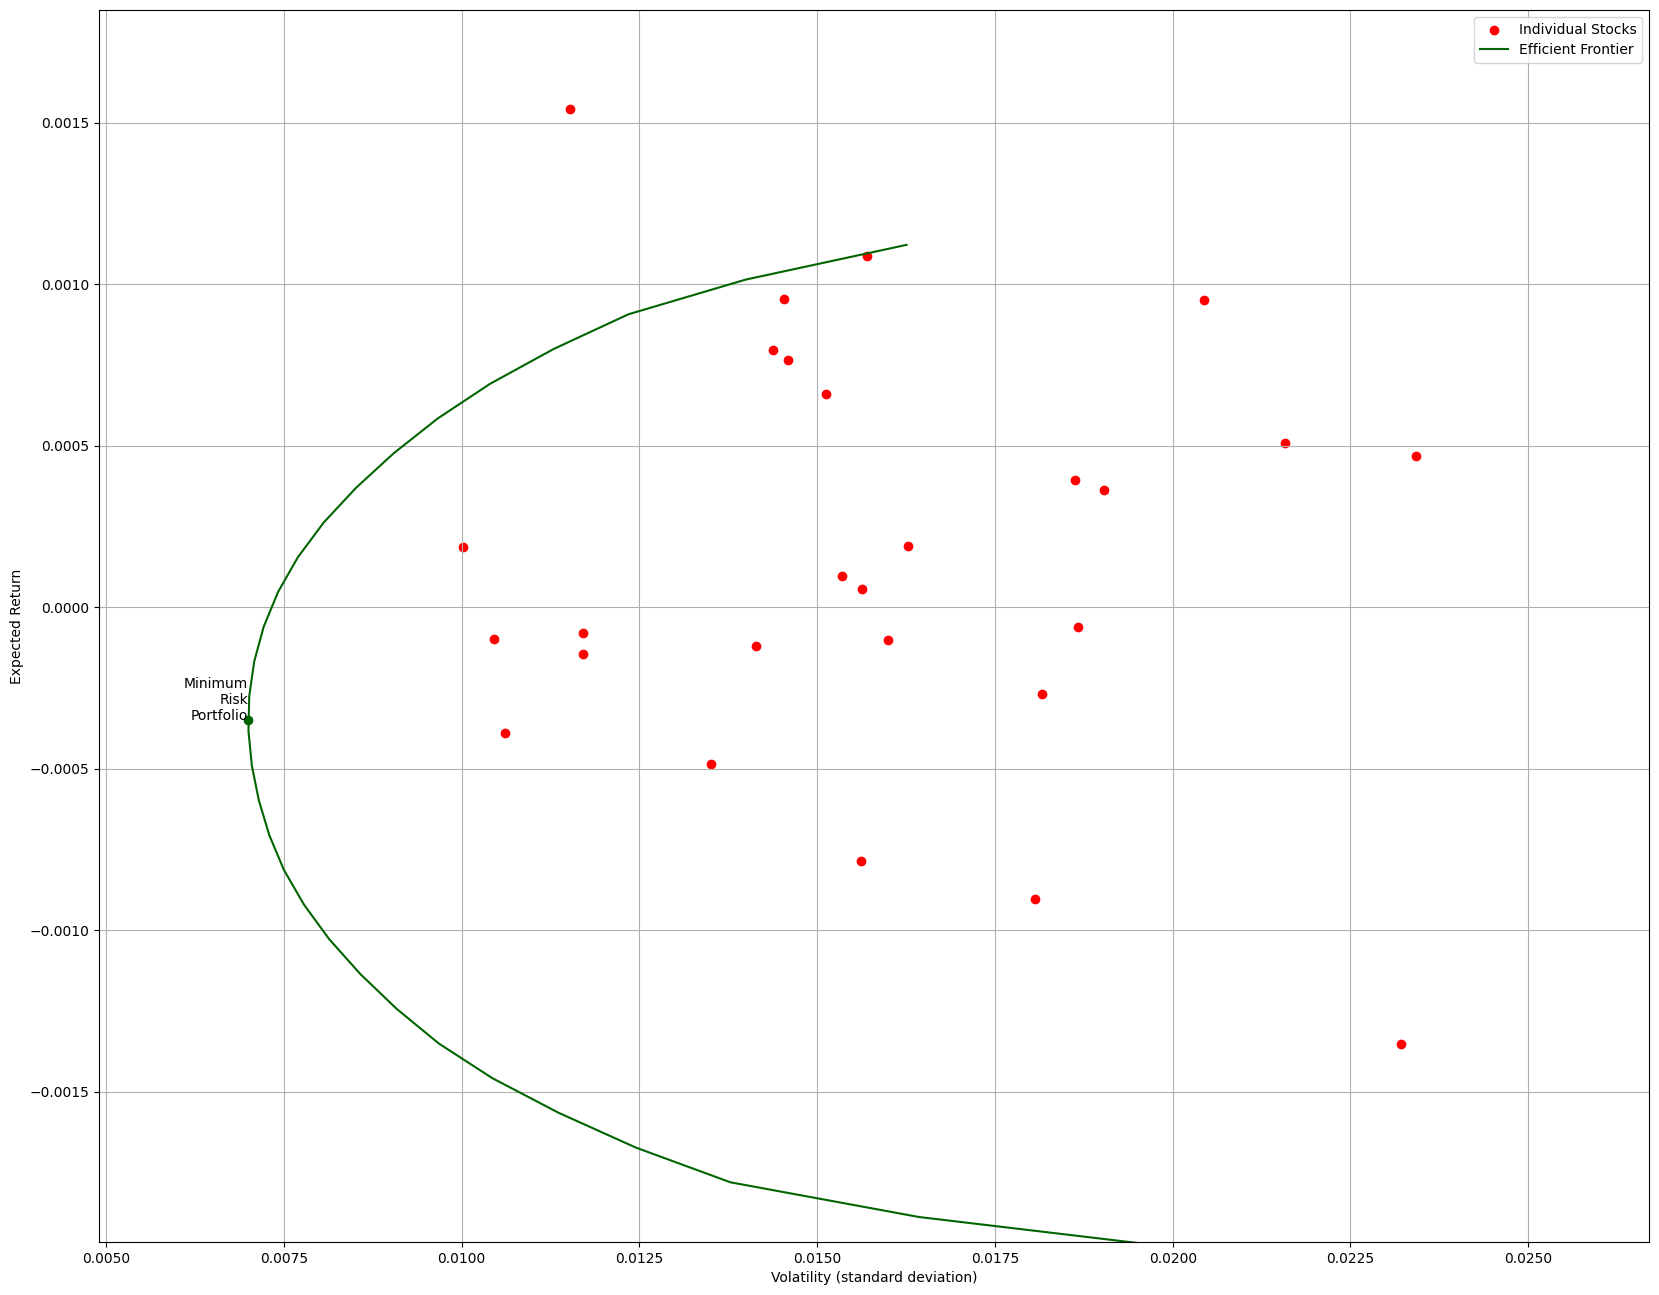

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x2f1c4daa
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.29758098e+05 -2.29758098e+05  2.80e+04 3.18e-07  1.00e+0

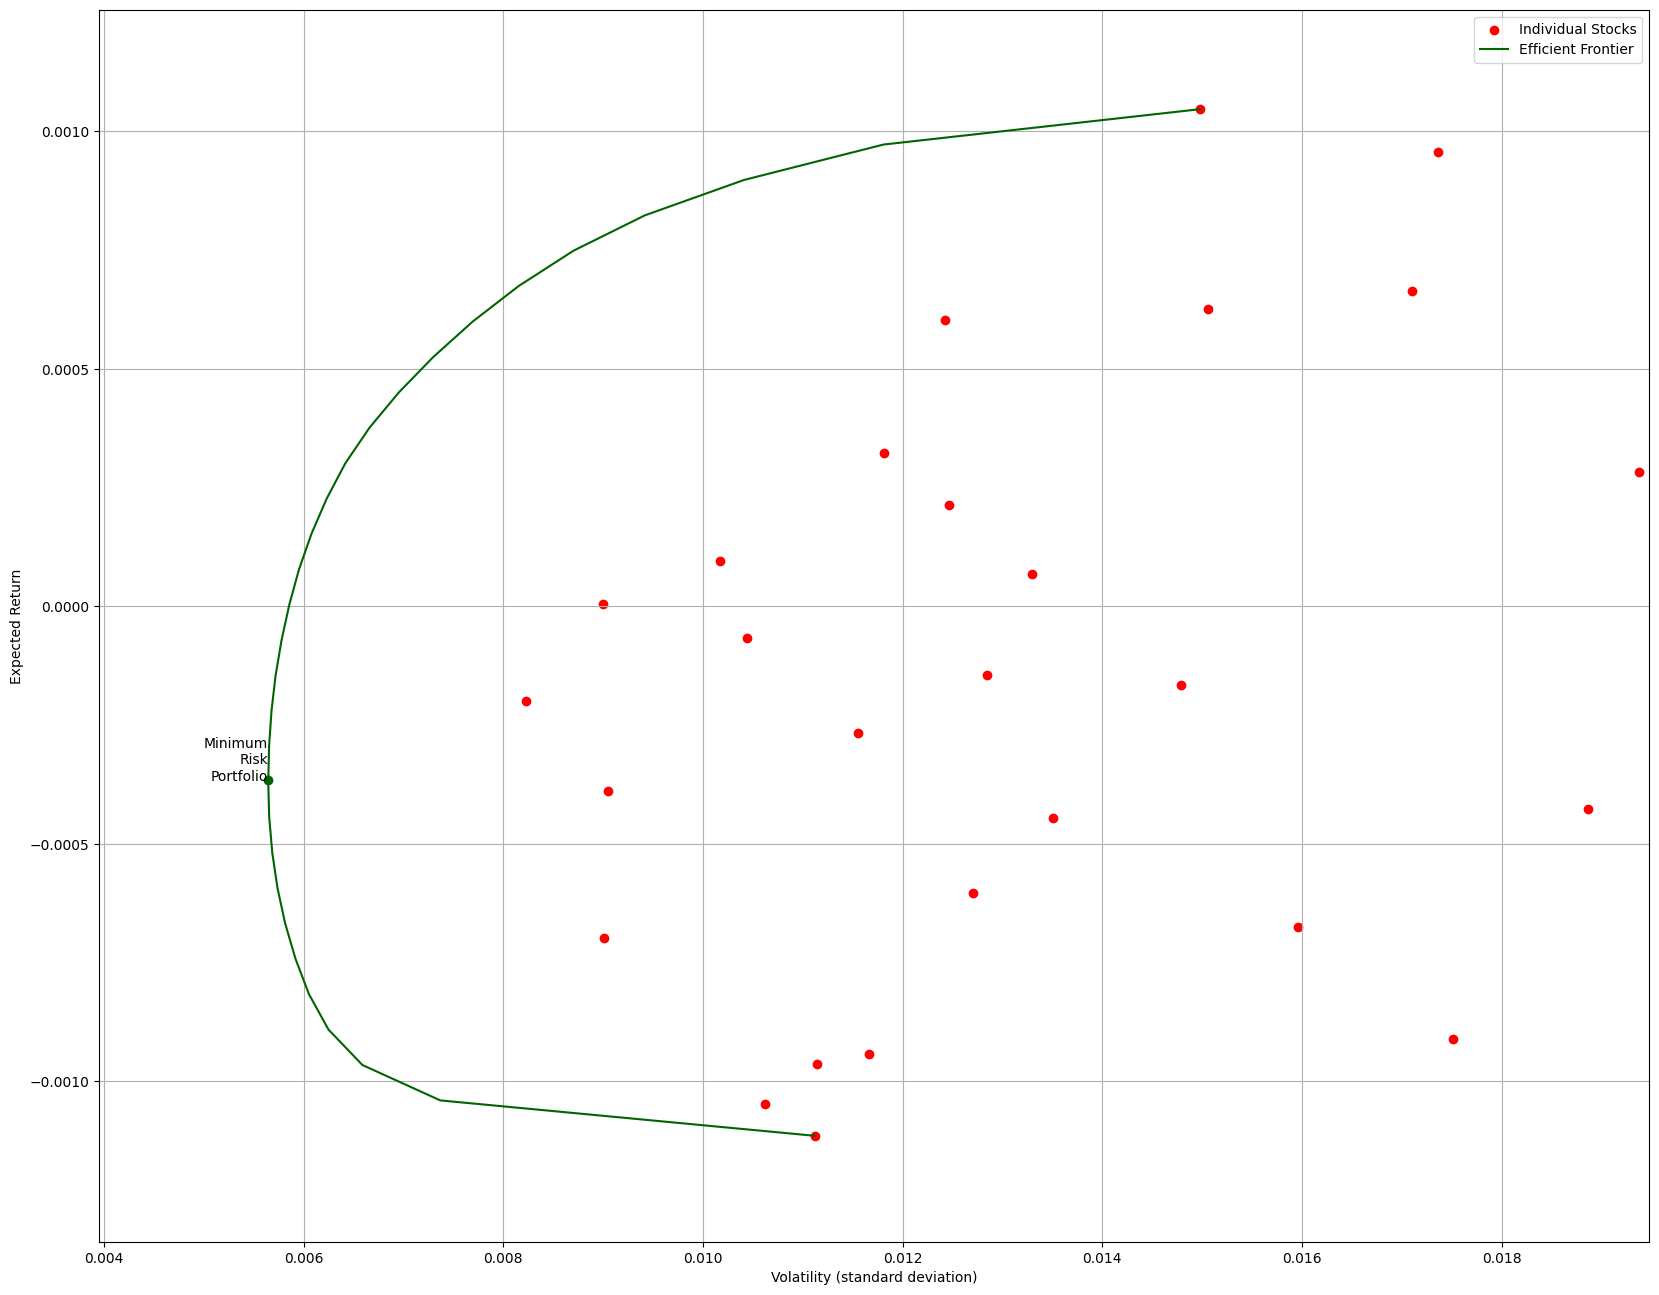

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x71fa6bef
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.89925600e+05 -2.89925600e+05  2.75e+04 5.36e-05  1.00e+0

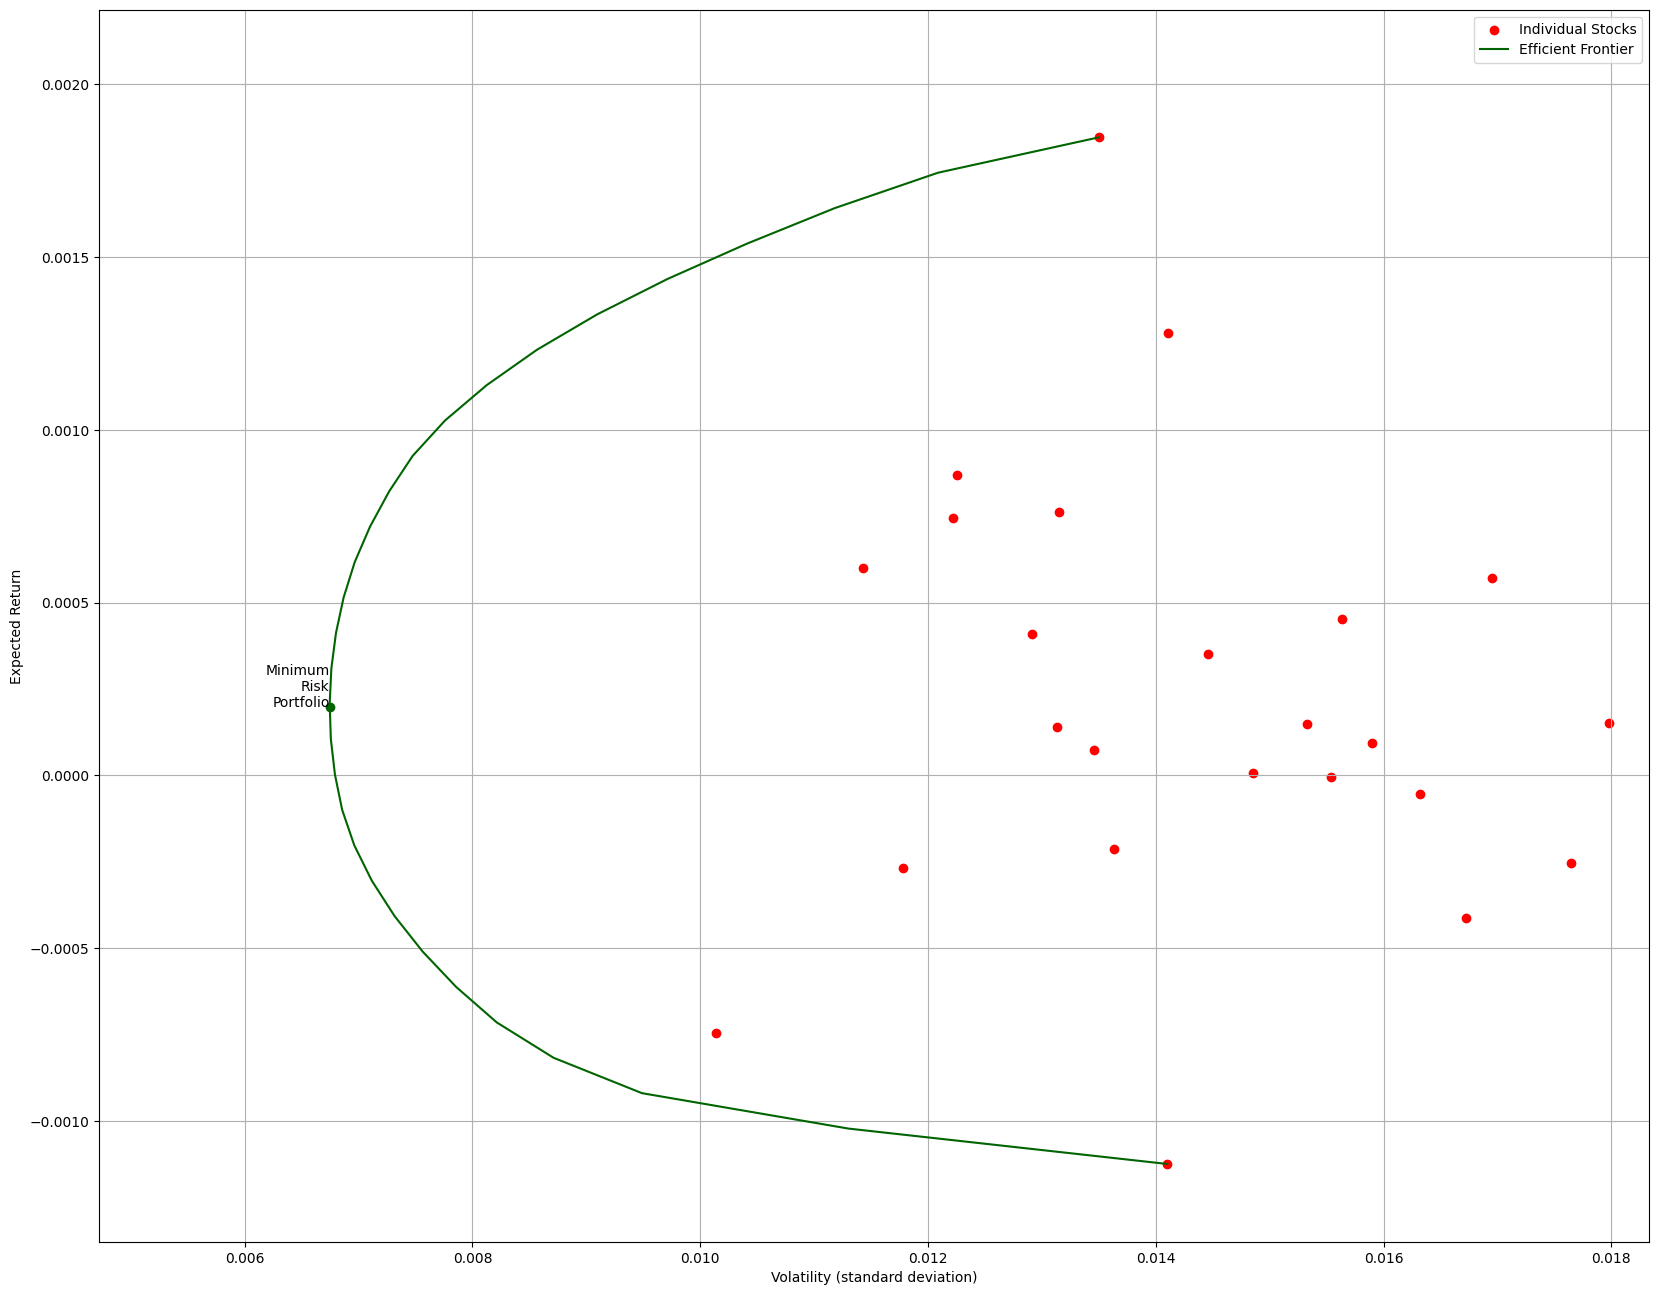

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x37b34995
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.33313395e+05 -2.33313395e+05  2.65e+04 8.83e-08  1.00e+0

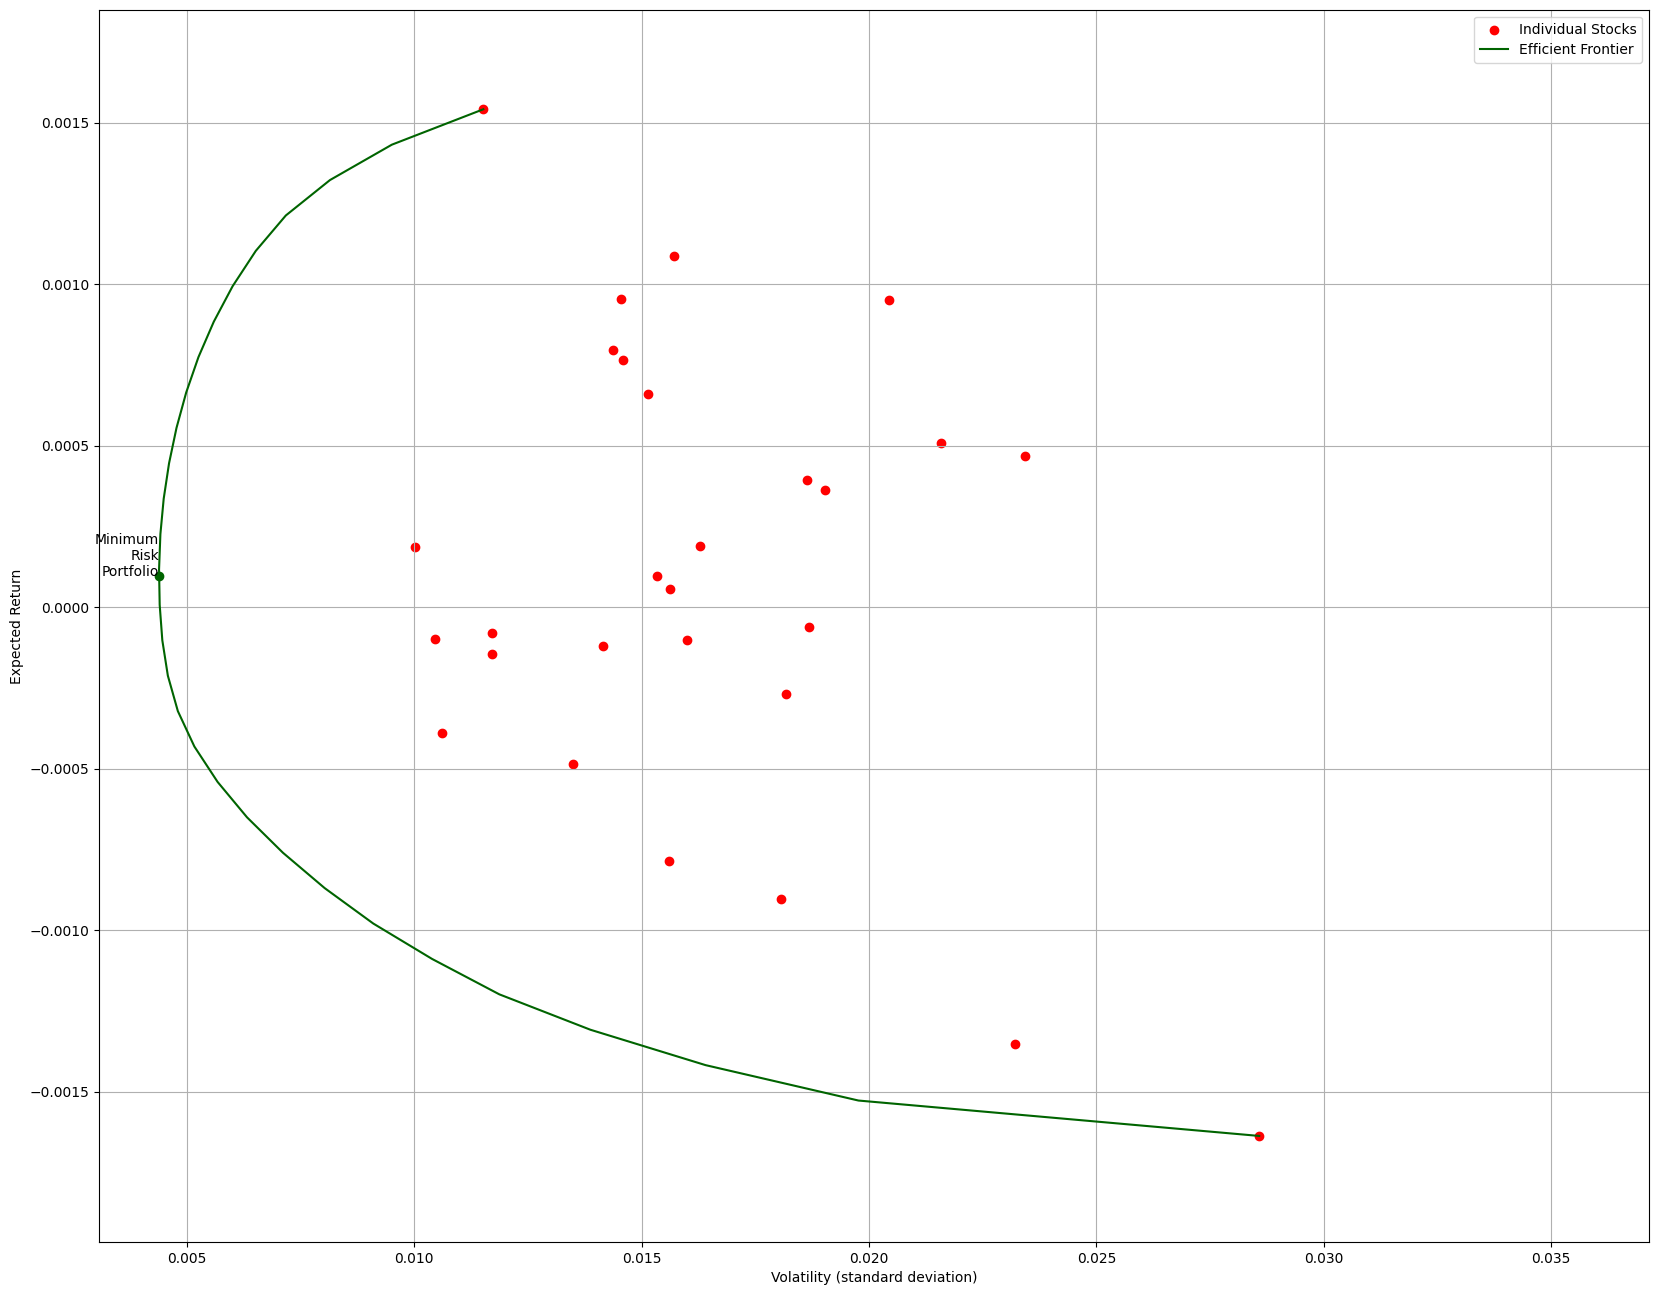

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0xe7bfdbff
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41183768e+05 -1.41183768e+05  2.80e+04 1.92e-06  1.00e+0

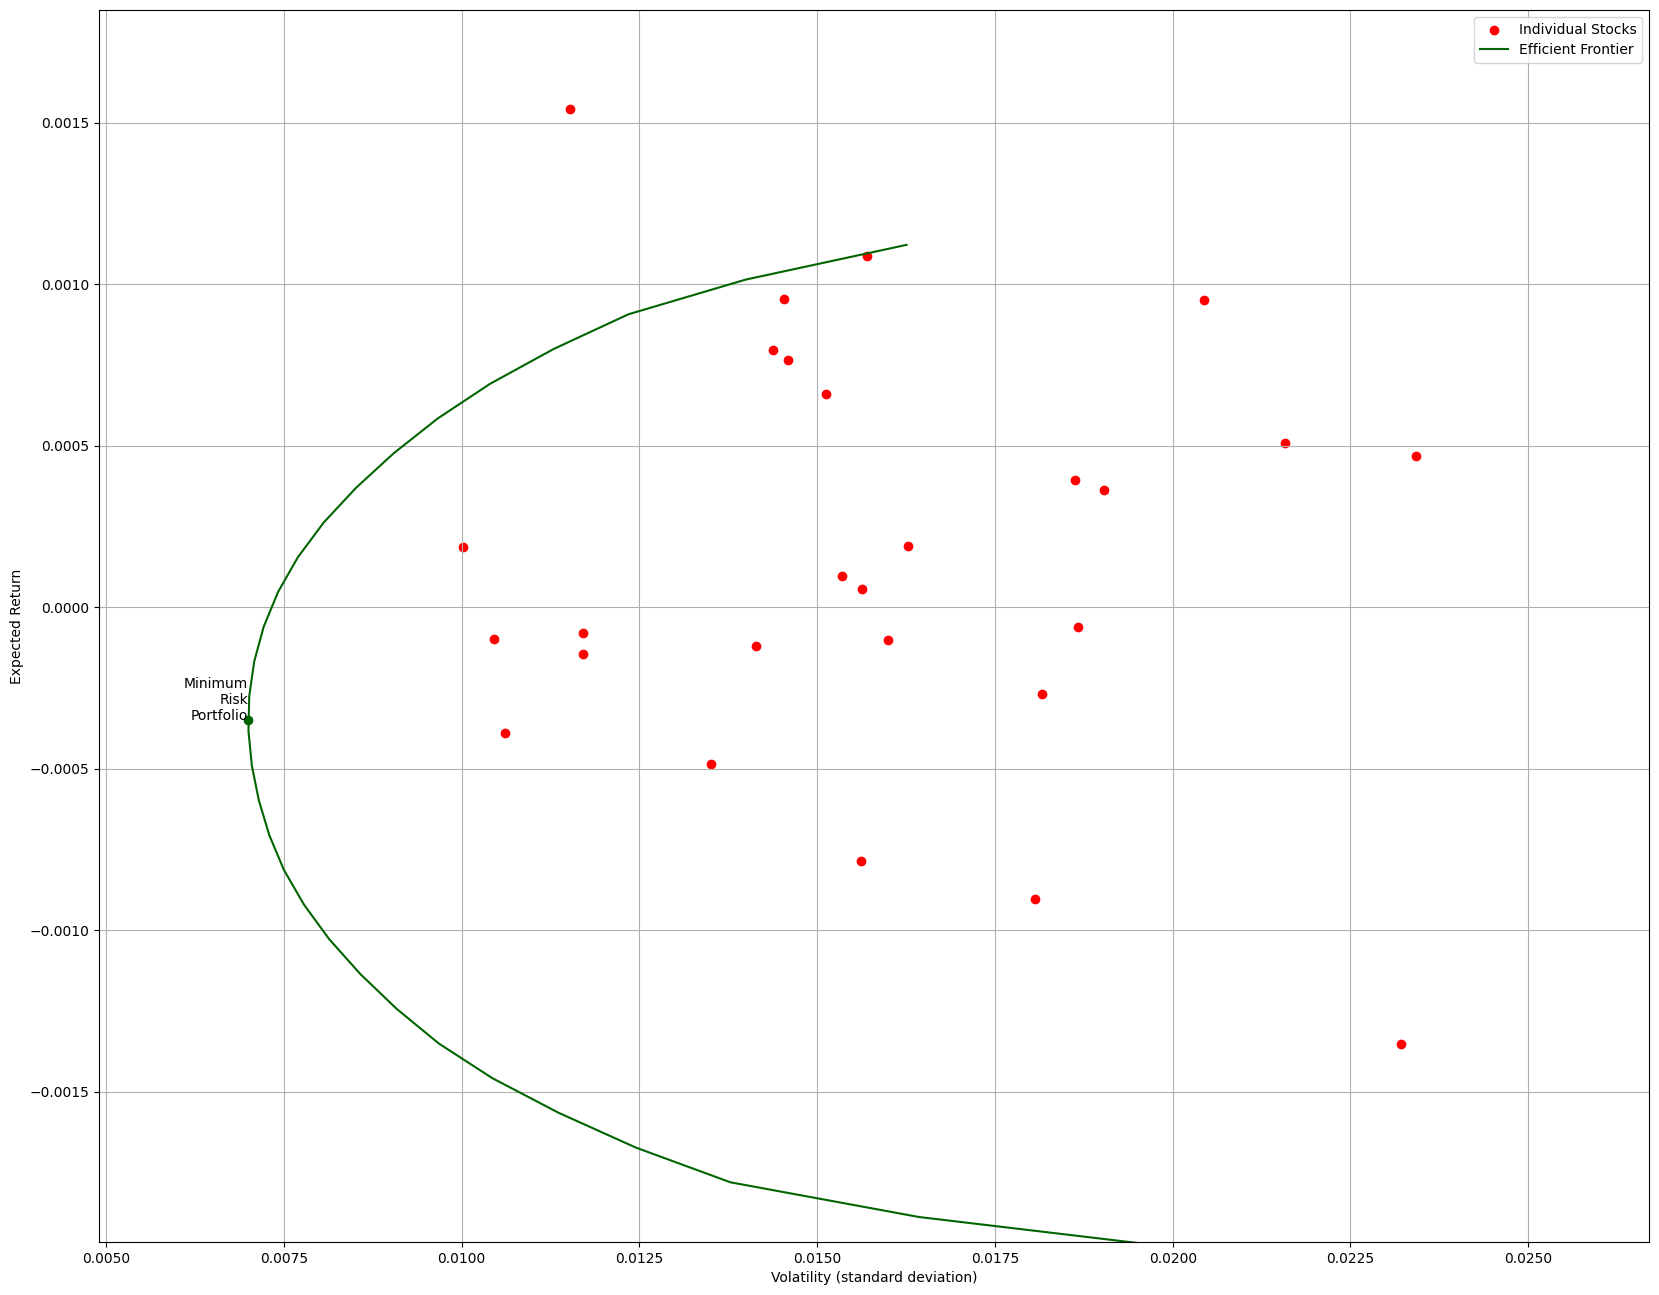

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x2f1c4daa
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.29758098e+05 -2.29758098e+05  2.80e+04 3.18e-07  1.00e+0

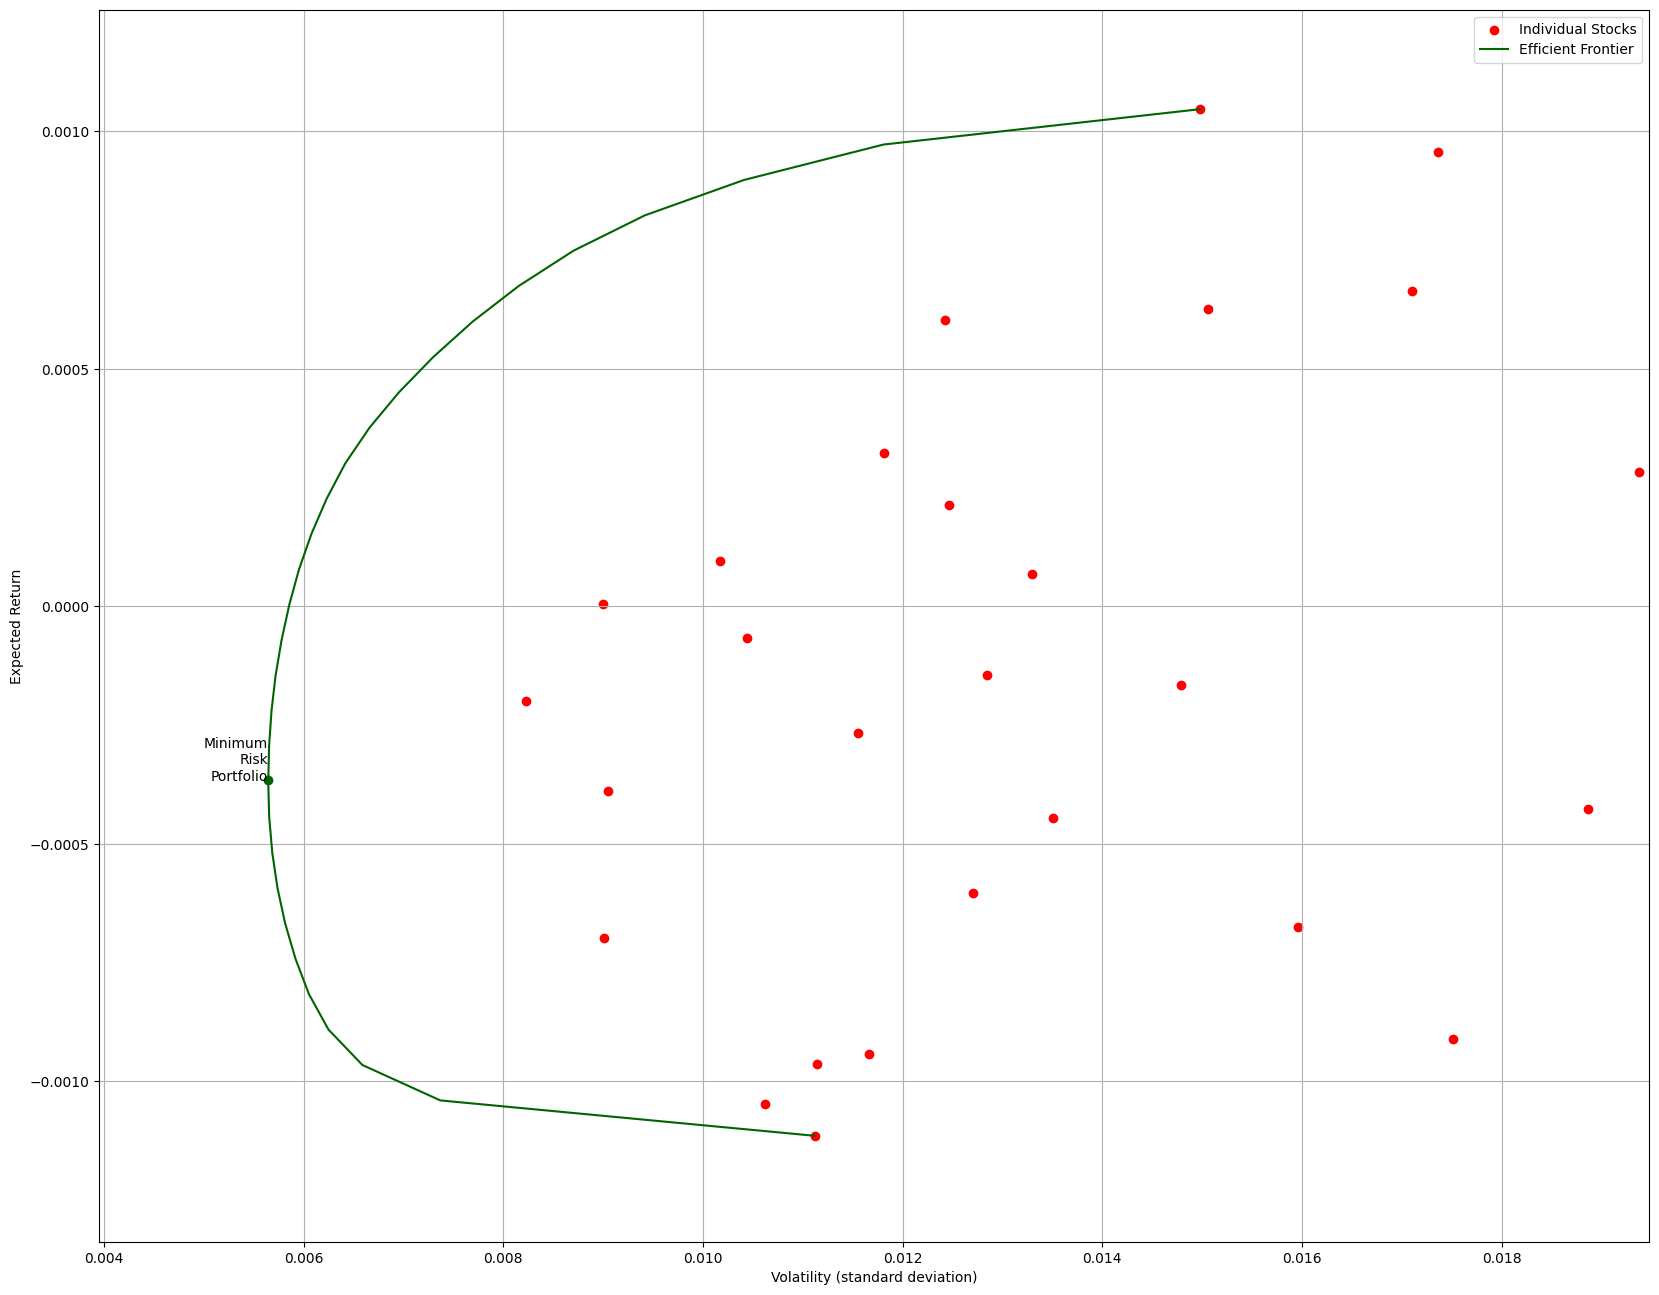

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x71fa6bef
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.89925600e+05 -2.89925600e+05  2.75e+04 5.36e-05  1.00e+0

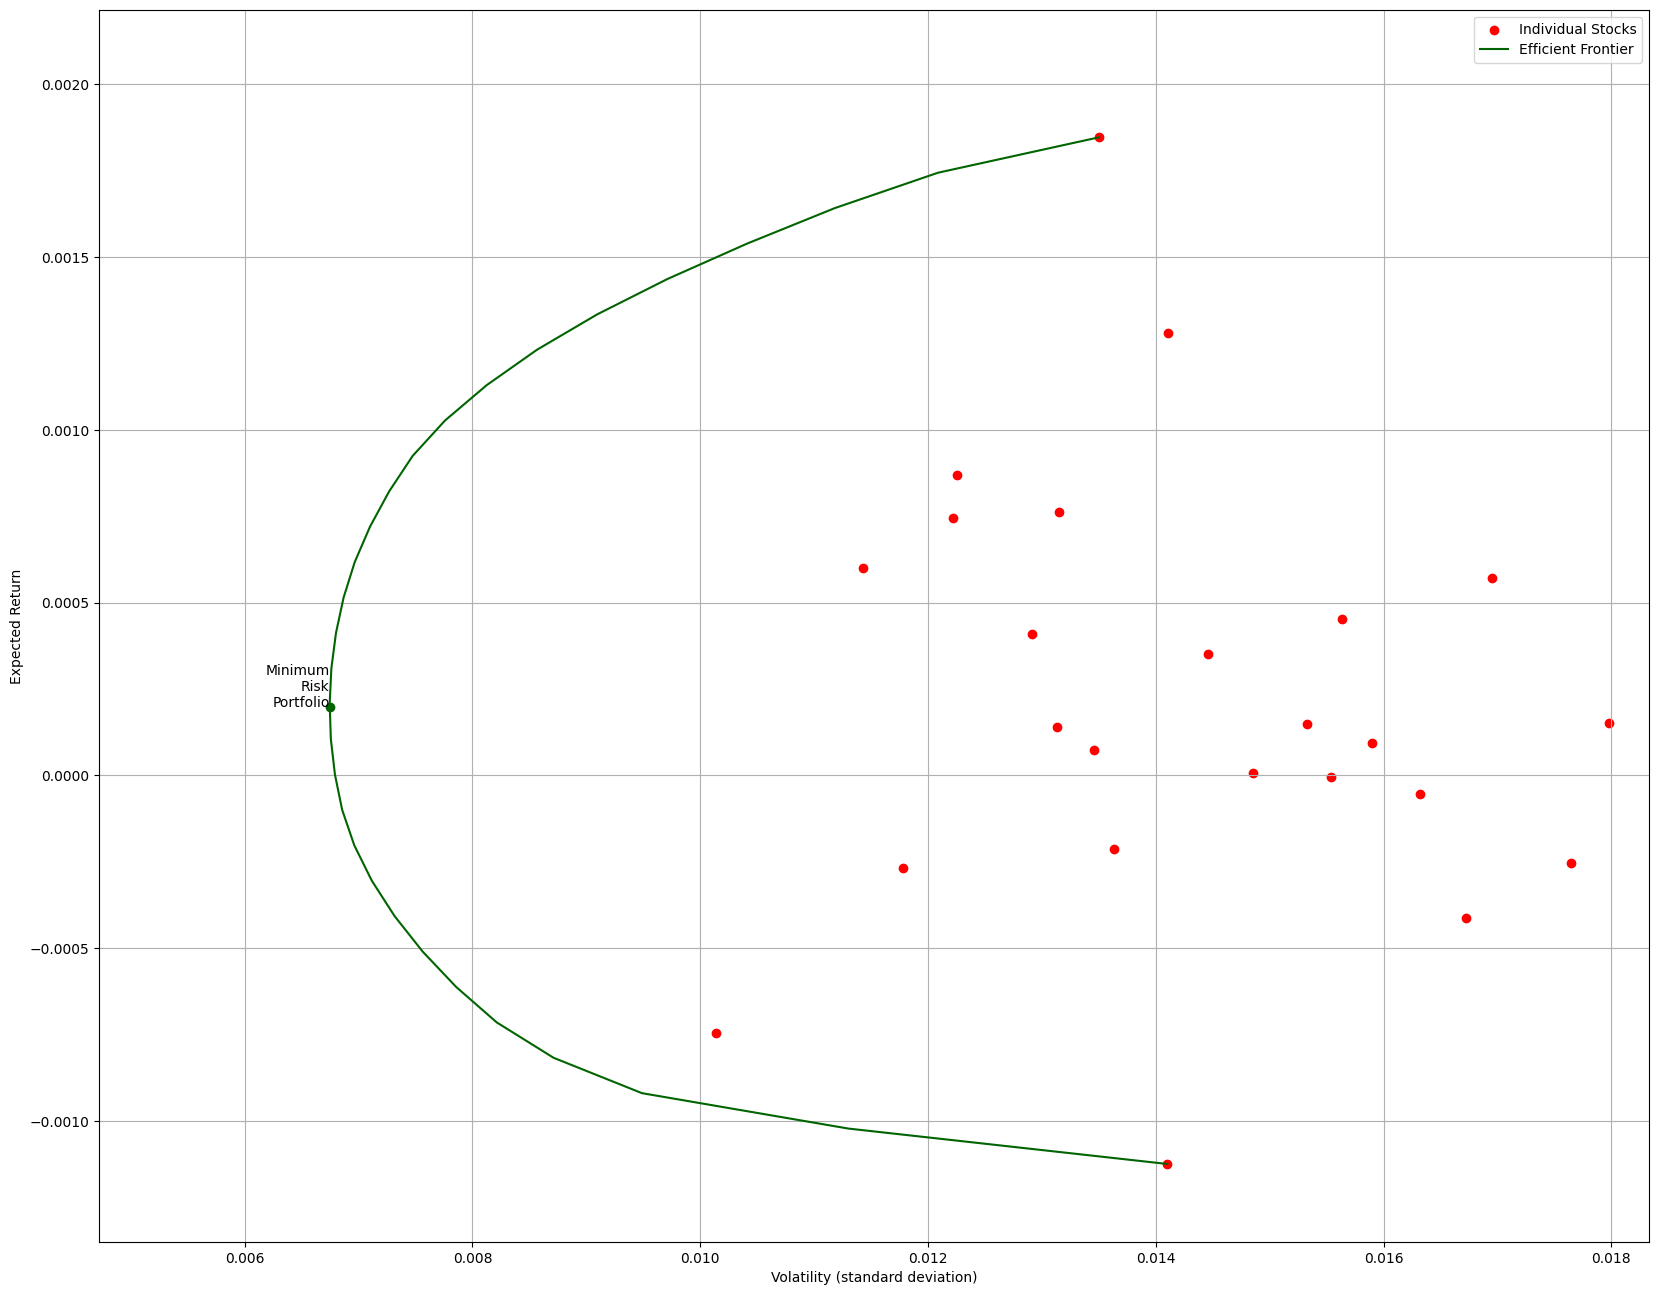

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x37b34995
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.33313395e+05 -2.33313395e+05  2.65e+04 8.83e-08  1.00e+0

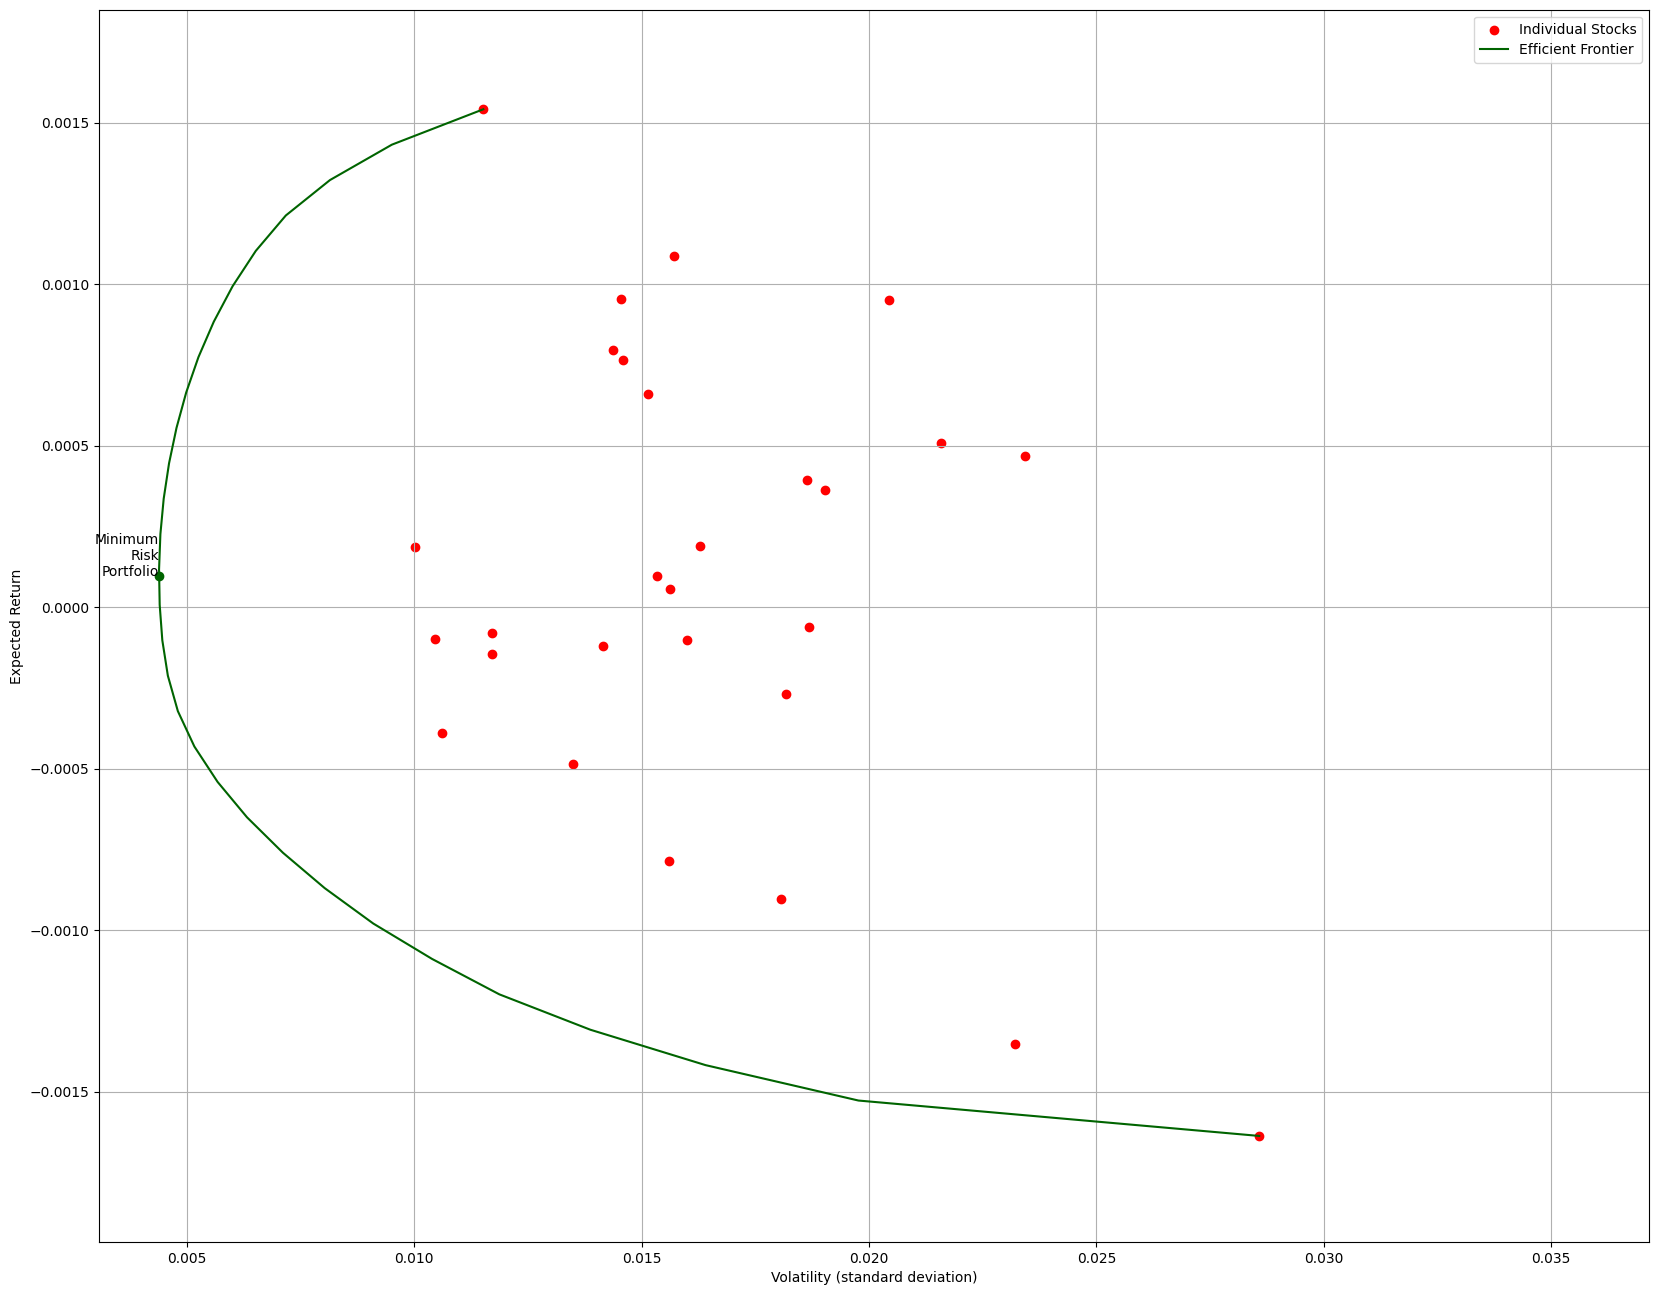

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0xe7bfdbff
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41183768e+05 -1.41183768e+05  2.80e+04 1.92e-06  1.00e+0

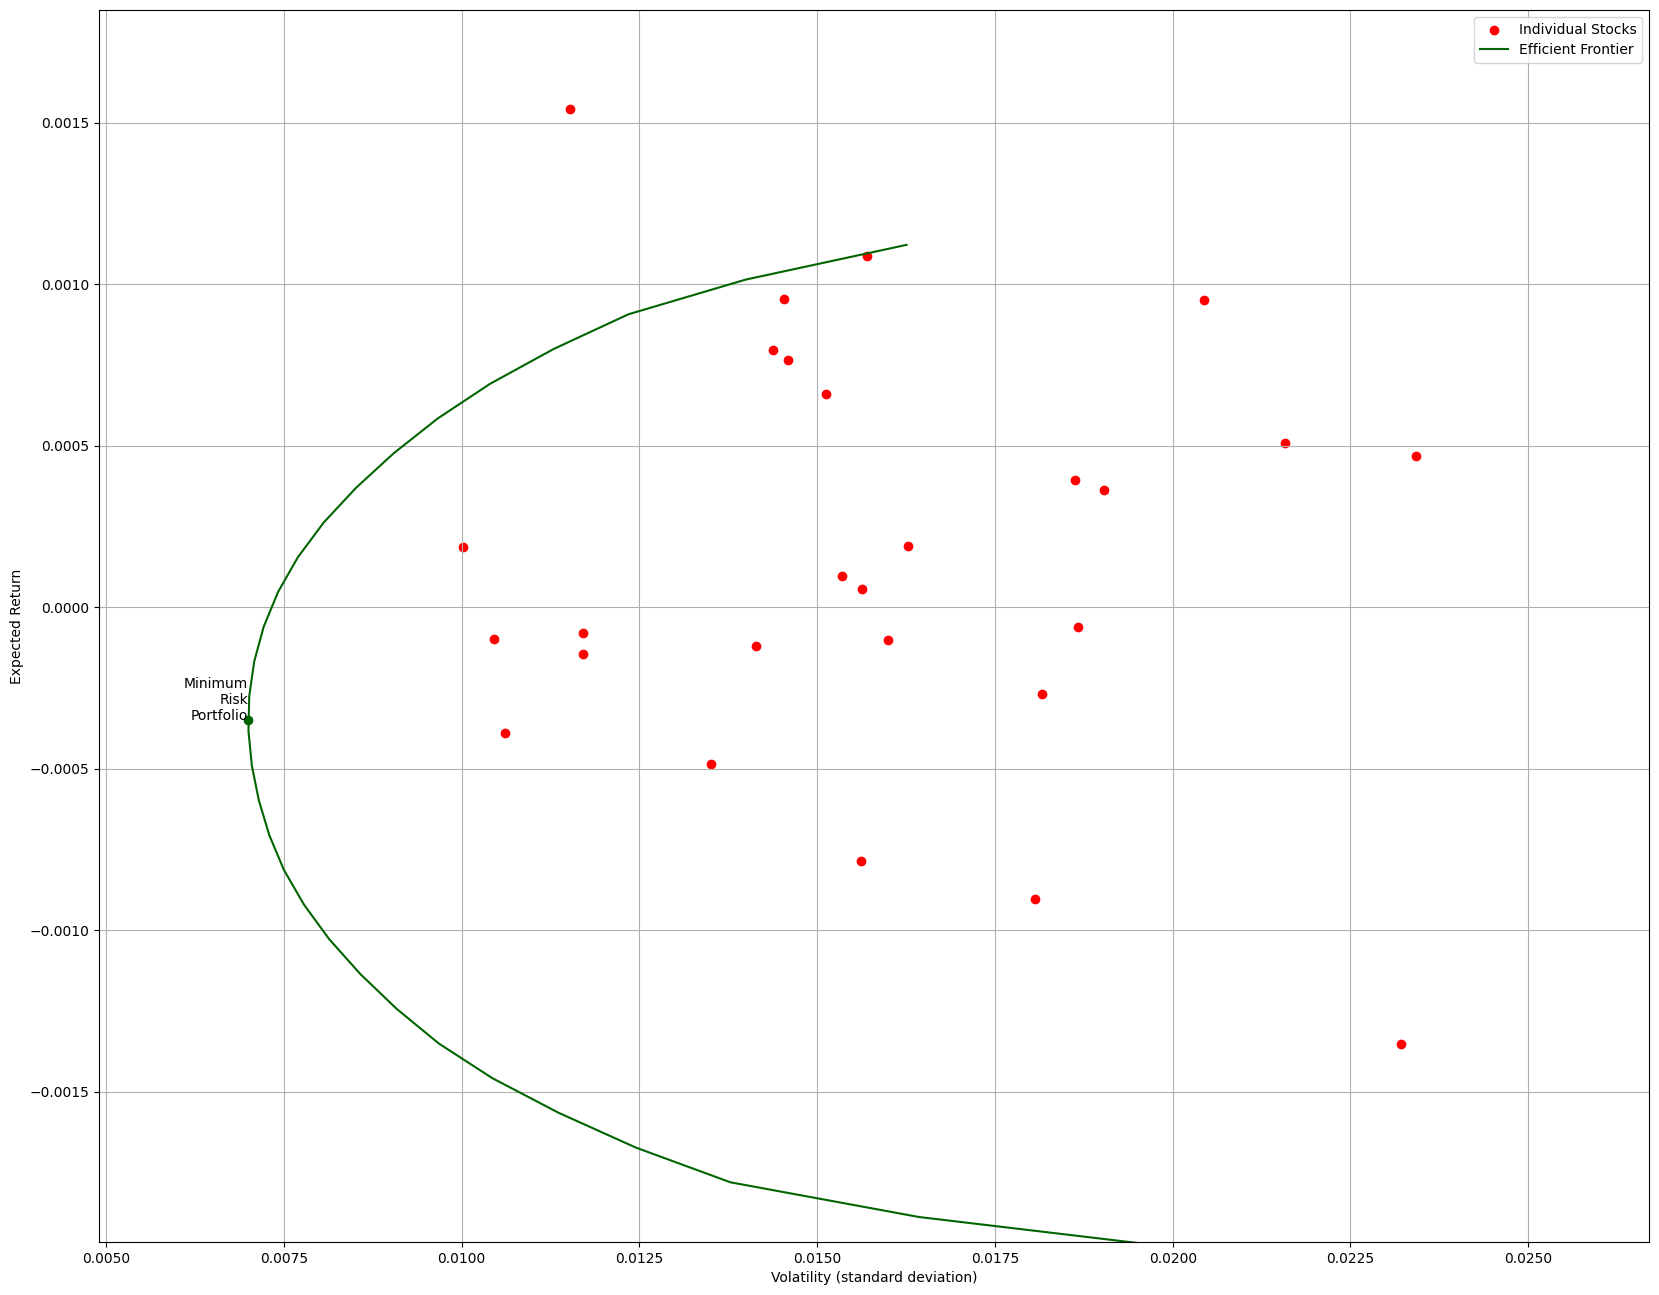

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x2f1c4daa
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.29758098e+05 -2.29758098e+05  2.80e+04 3.18e-07  1.00e+0

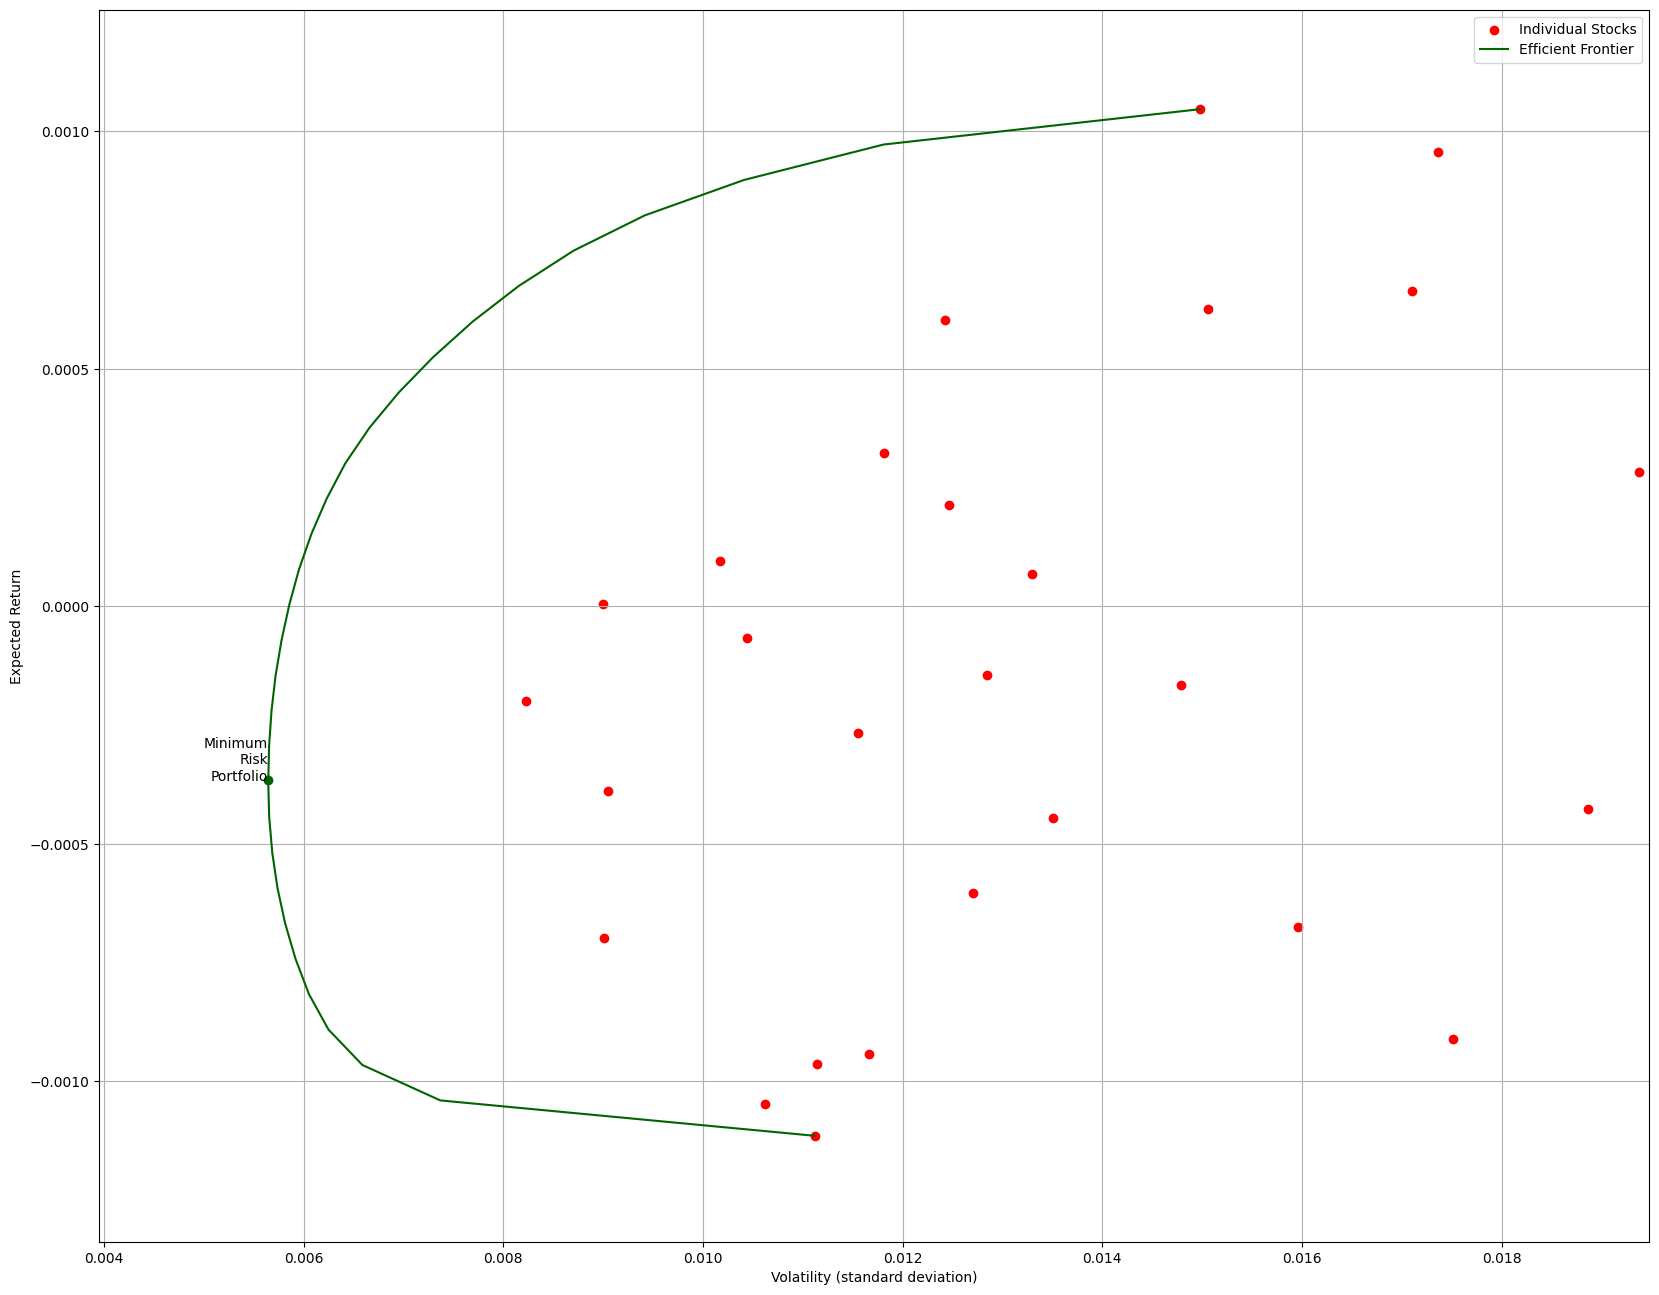

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x71fa6bef
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.89925600e+05 -2.89925600e+05  2.75e+04 5.36e-05  1.00e+0

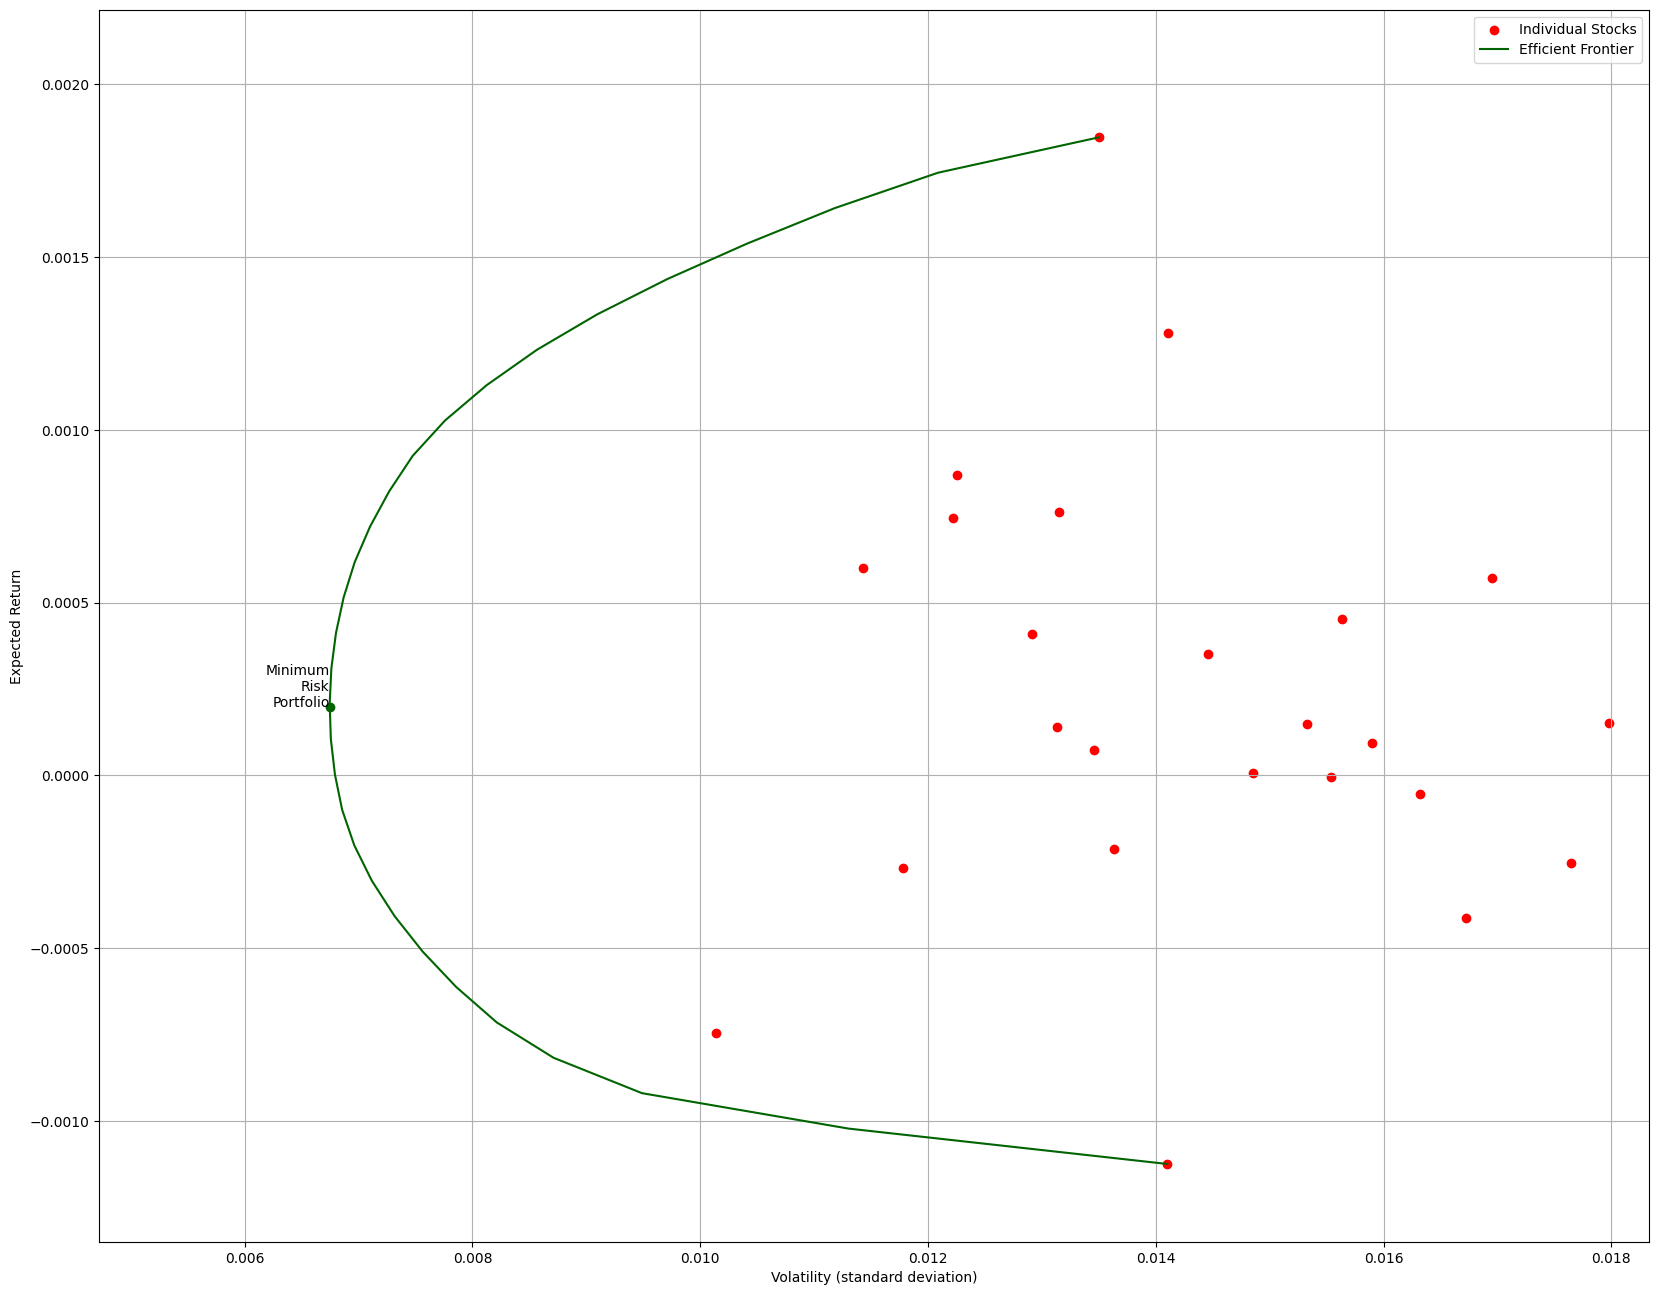

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x37b34995
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.33313395e+05 -2.33313395e+05  2.65e+04 8.83e-08  1.00e+0

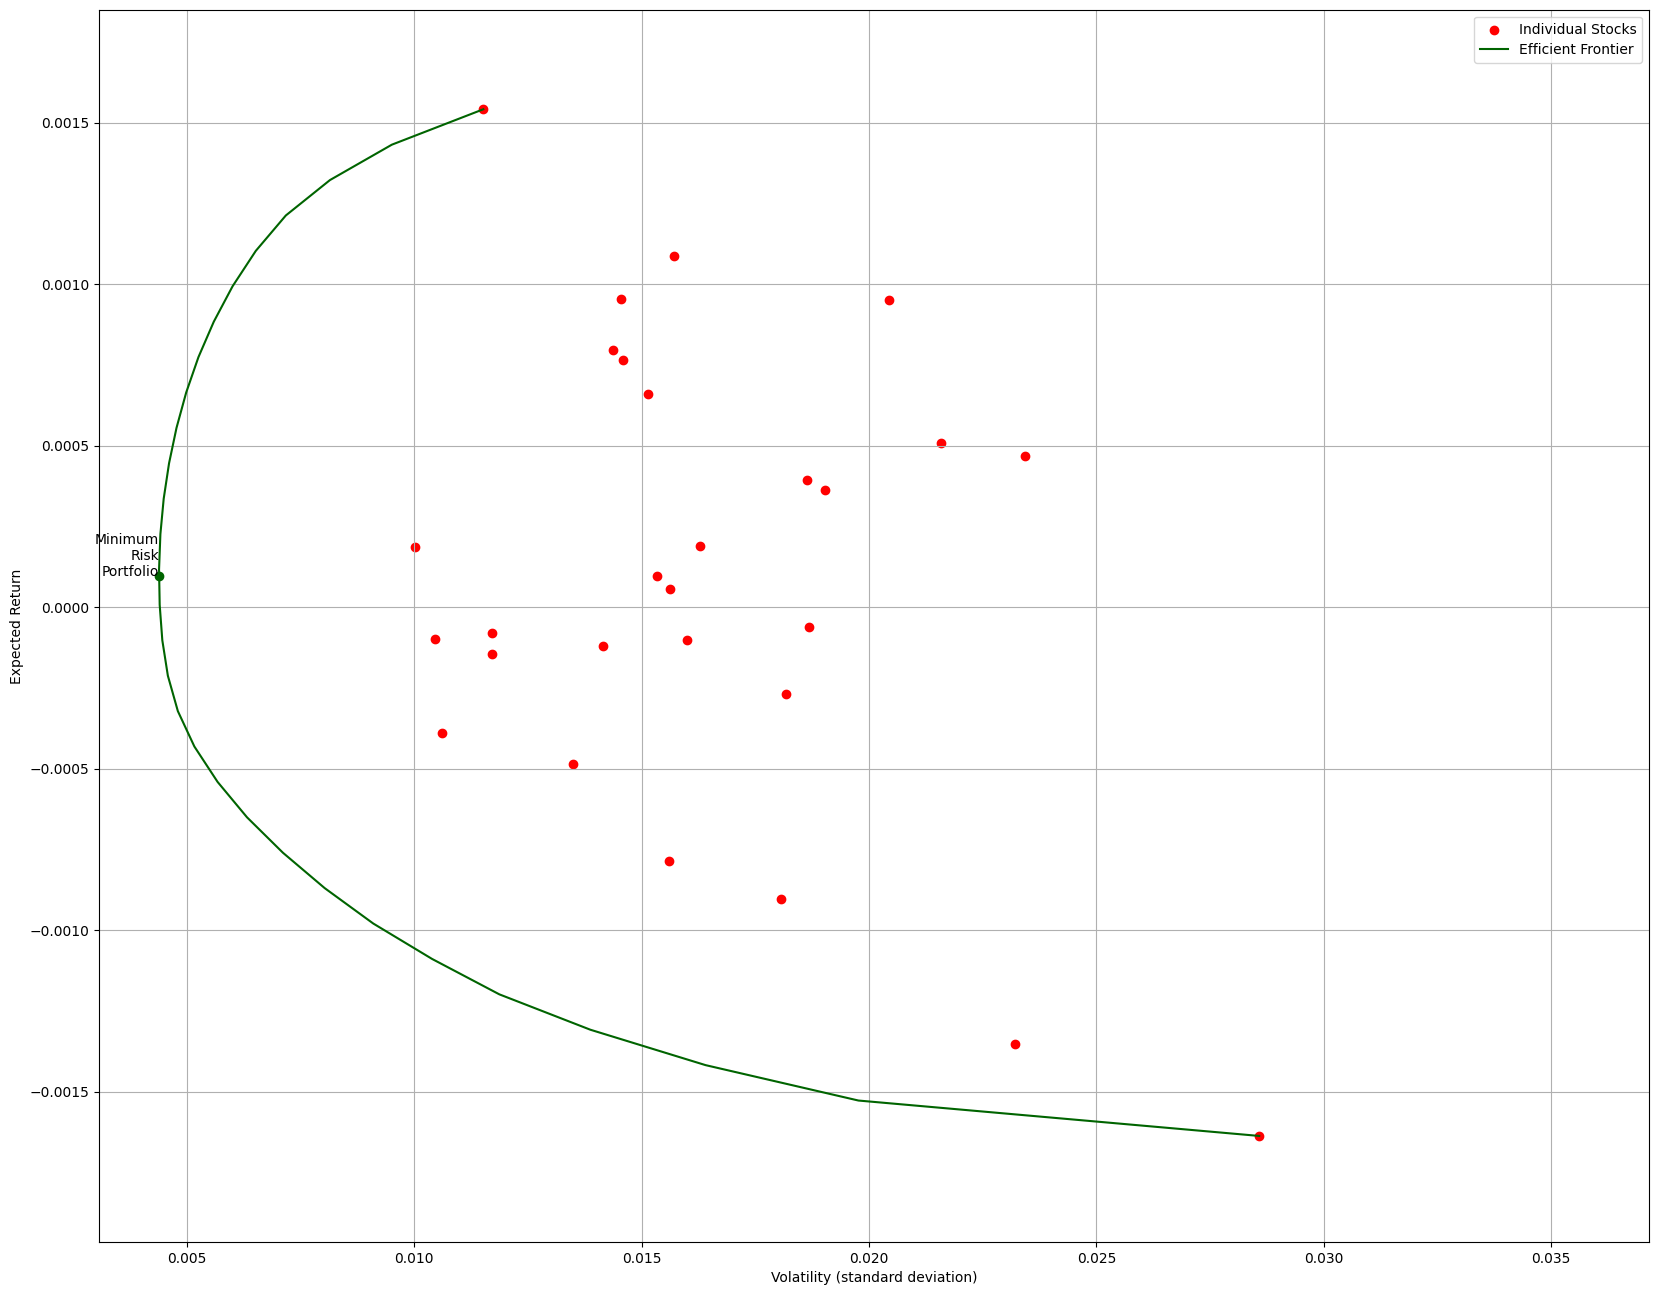

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0xe7bfdbff
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41183768e+05 -1.41183768e+05  2.80e+04 1.92e-06  1.00e+0

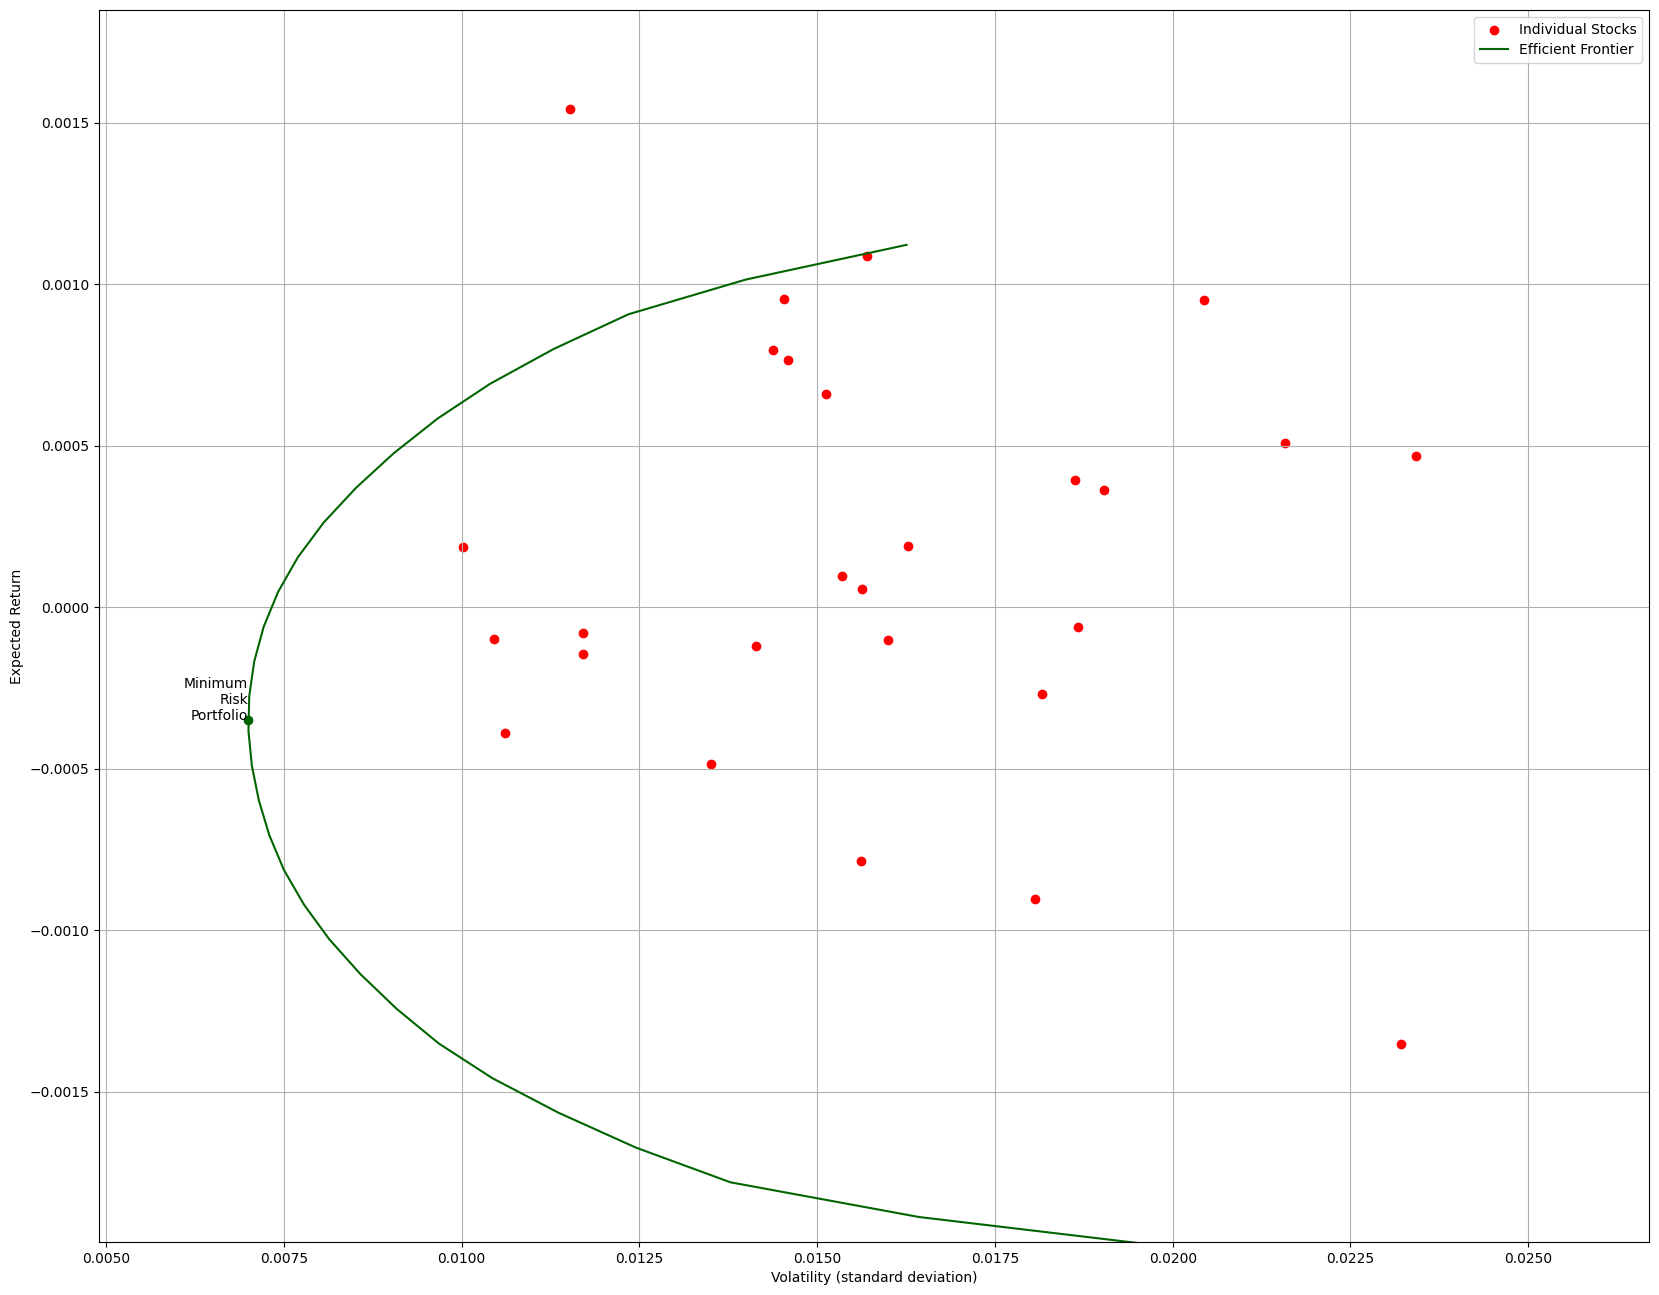

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x2f1c4daa
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.29758098e+05 -2.29758098e+05  2.80e+04 3.18e-07  1.00e+0

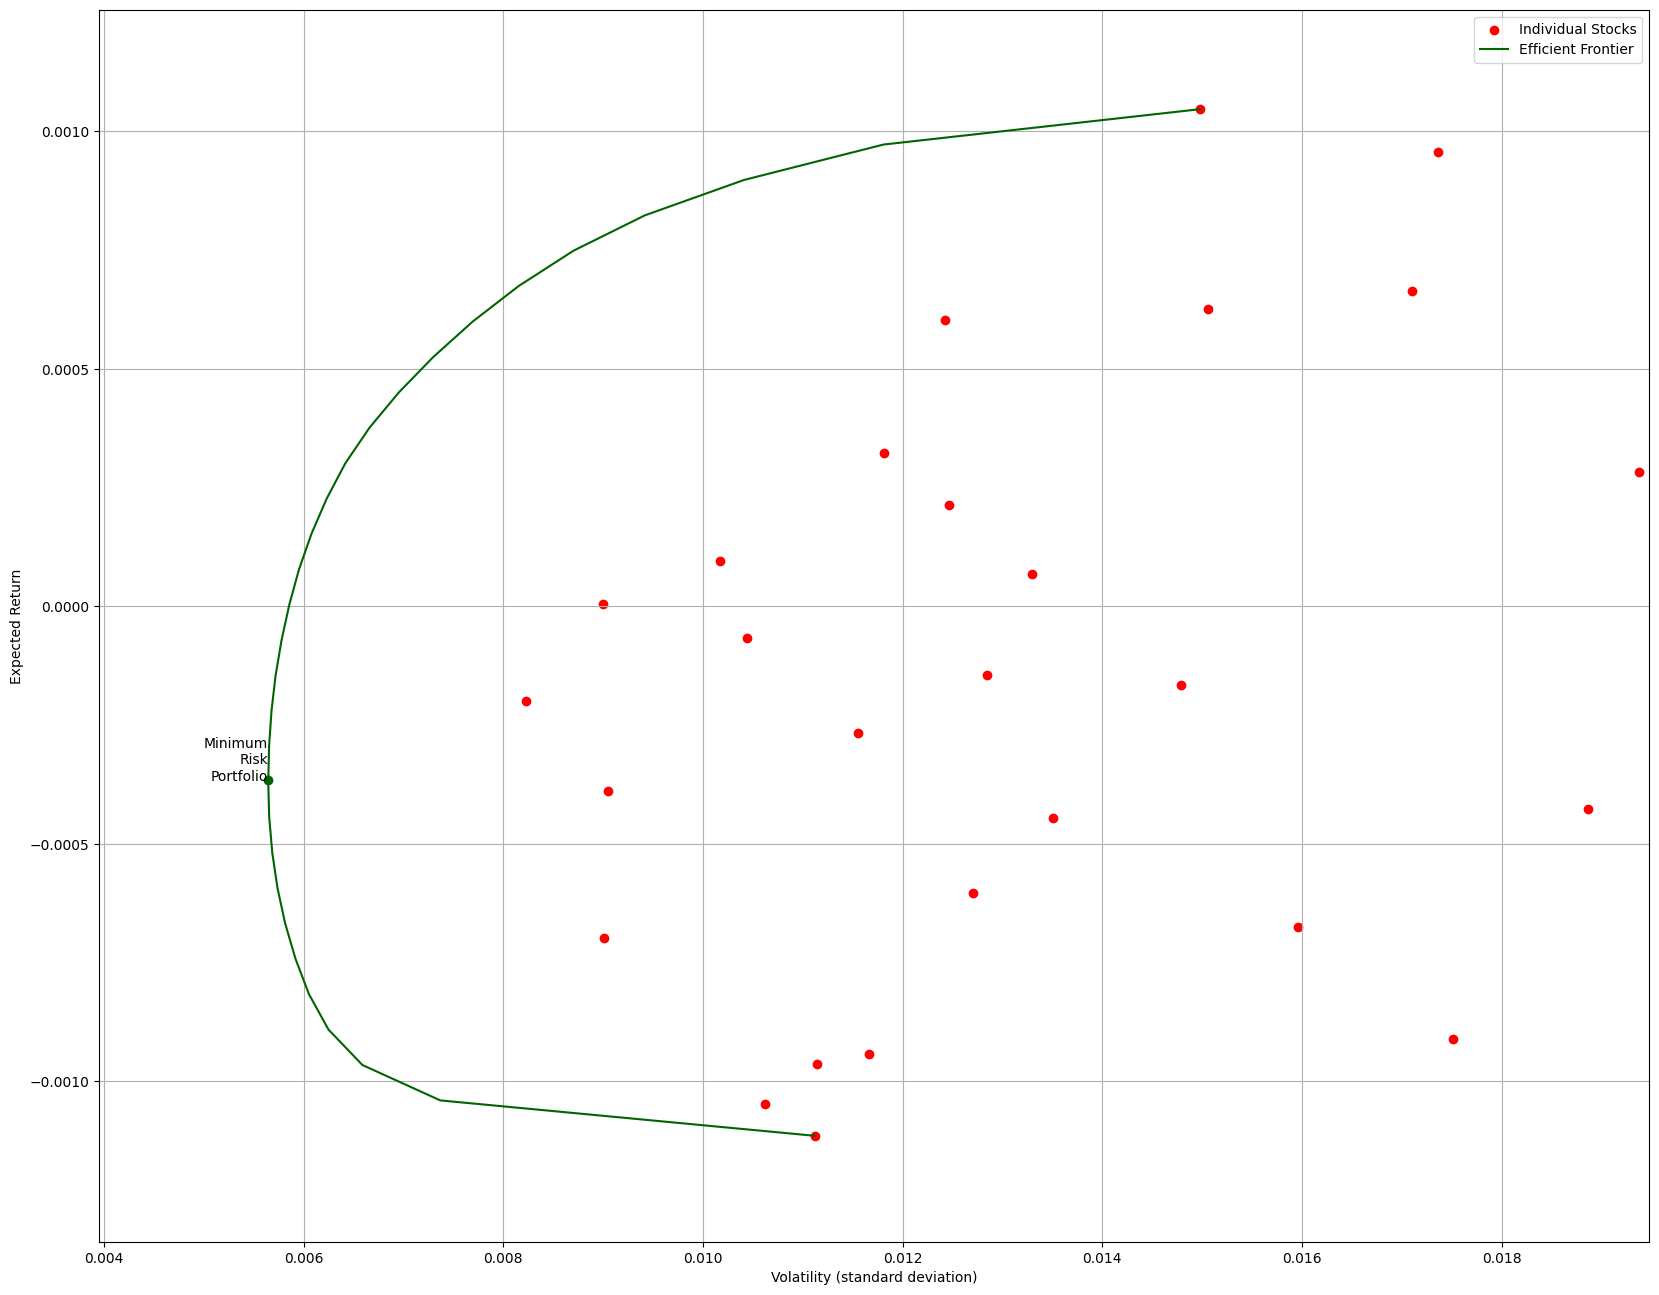

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x71fa6bef
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.89925600e+05 -2.89925600e+05  2.75e+04 5.36e-05  1.00e+0

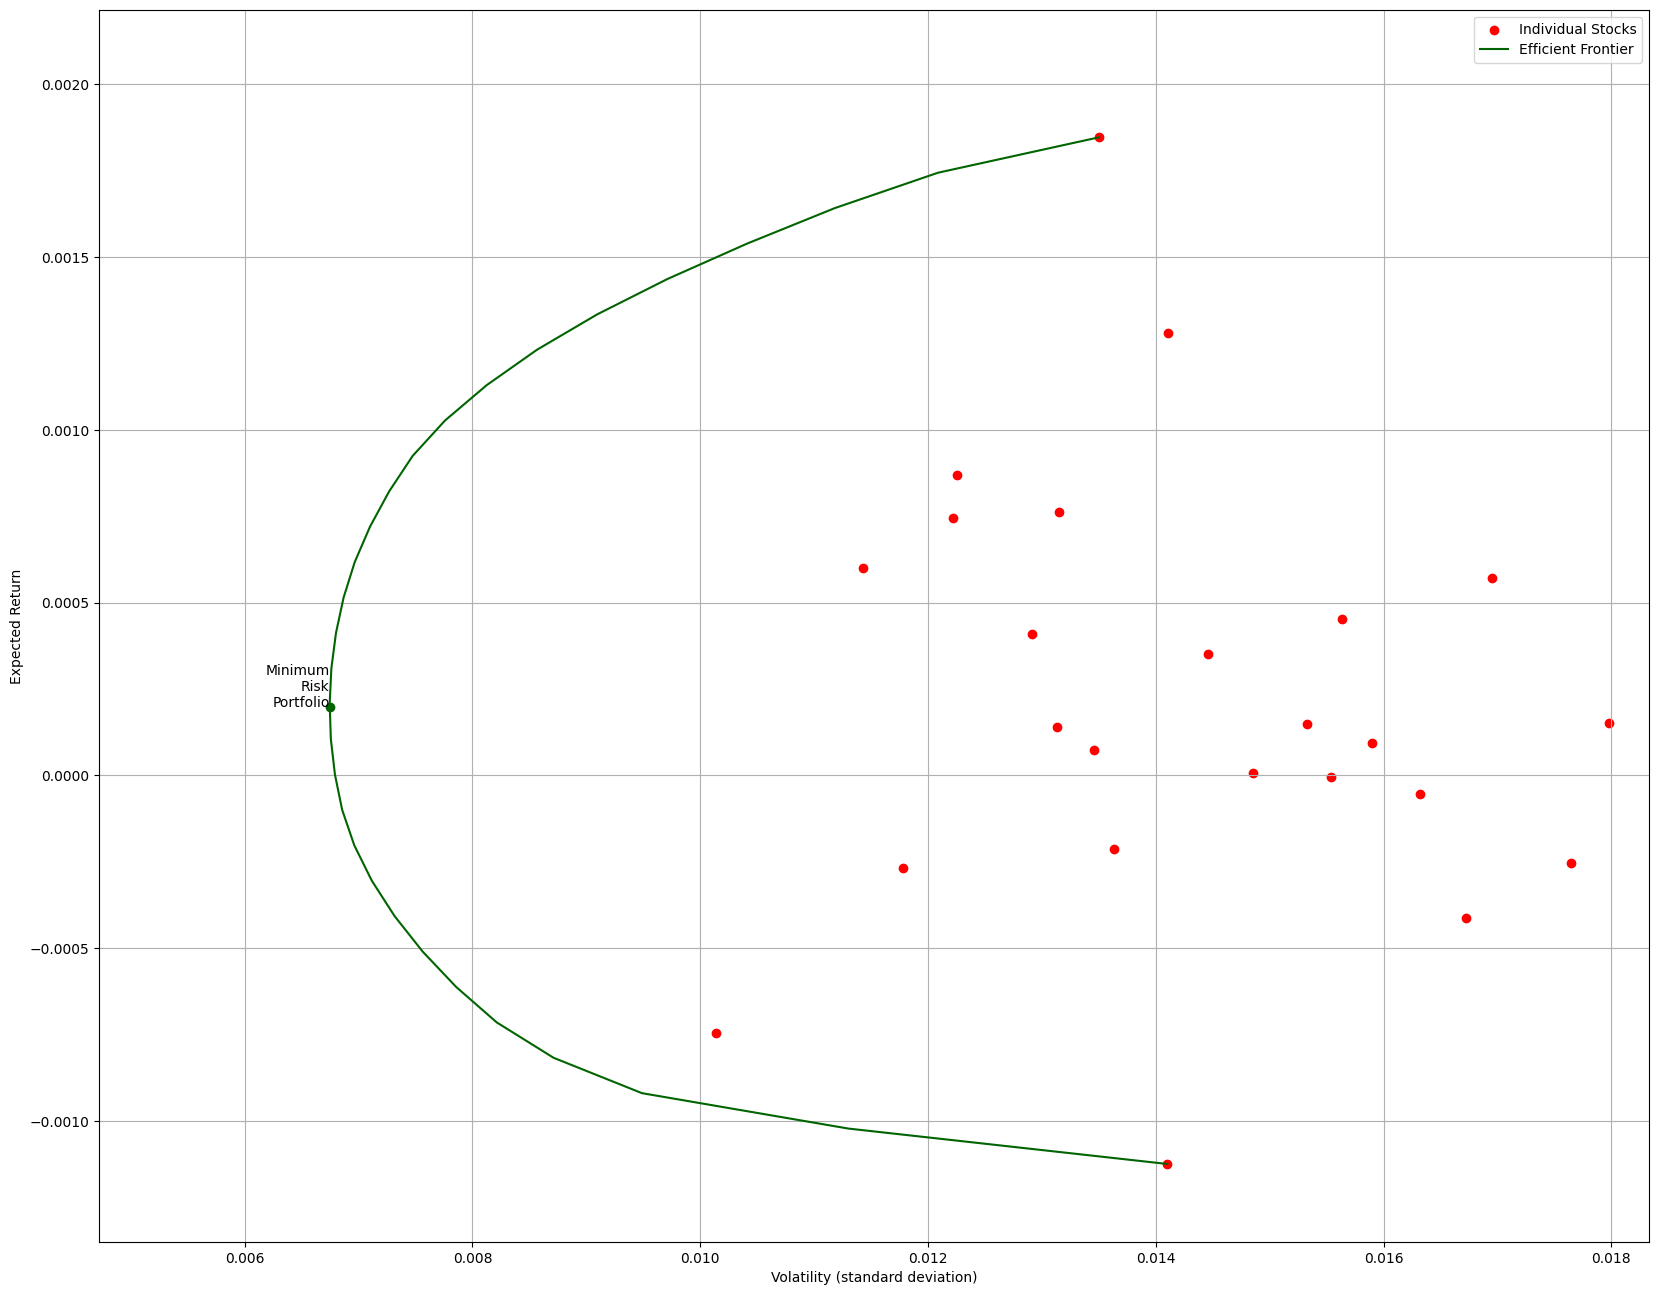

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x37b34995
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.33313395e+05 -2.33313395e+05  2.65e+04 8.83e-08  1.00e+0

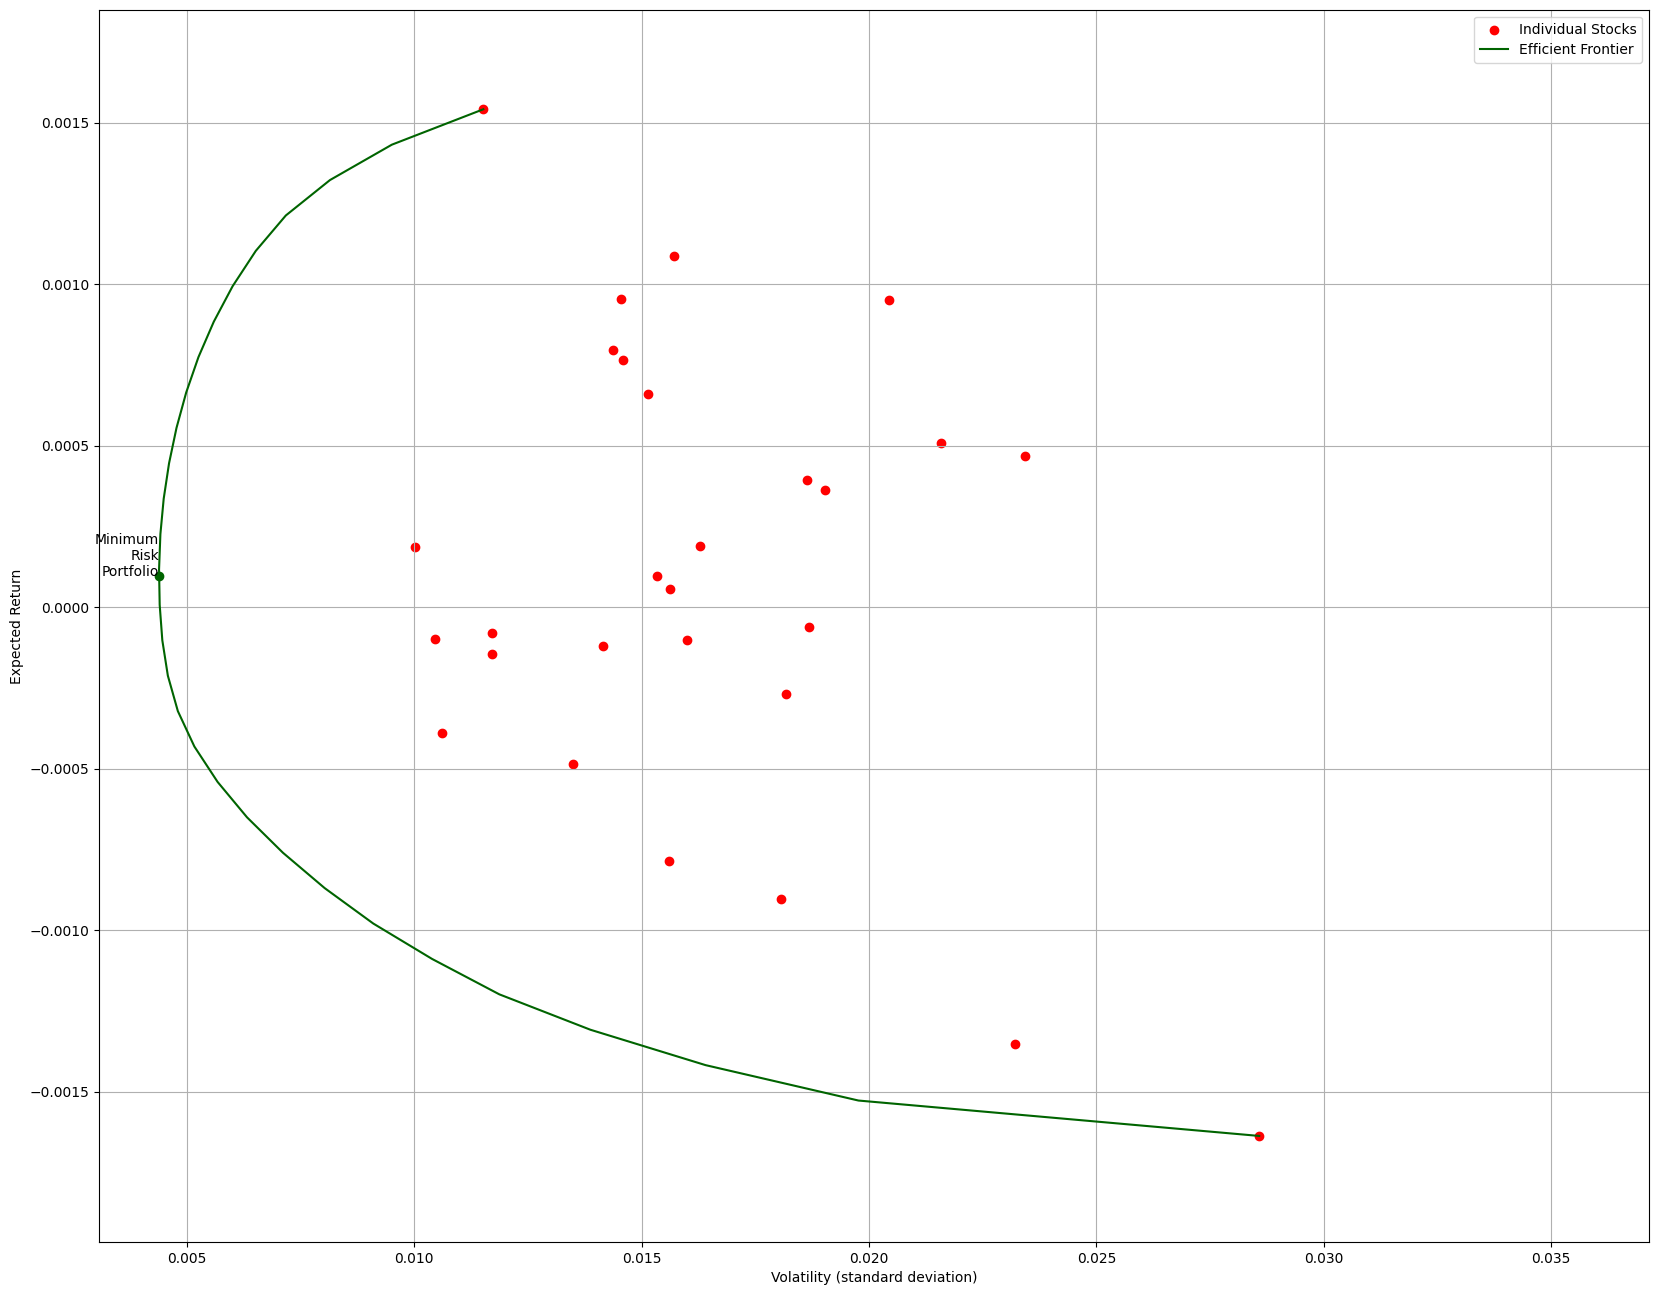

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0xe7bfdbff
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41183768e+05 -1.41183768e+05  2.80e+04 1.92e-06  1.00e+0

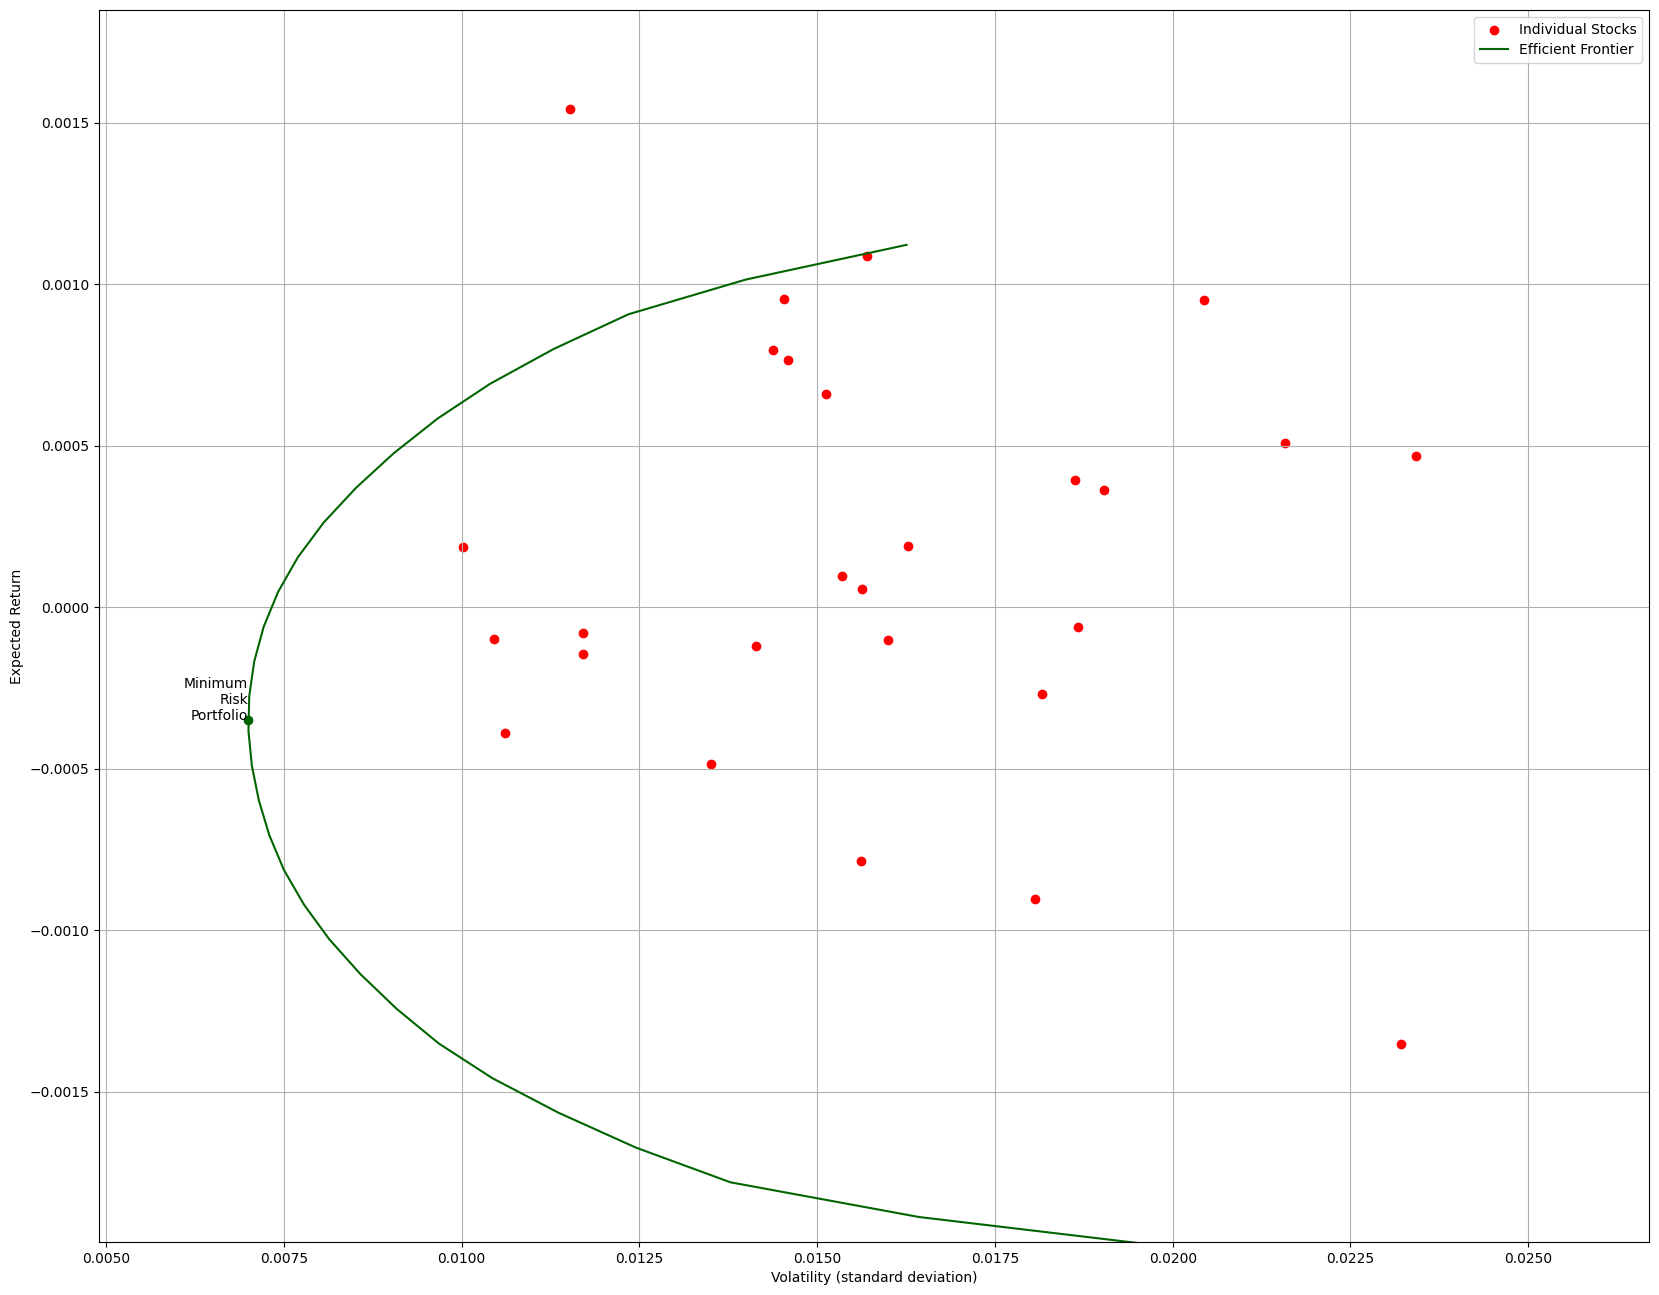

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x2f1c4daa
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.29758098e+05 -2.29758098e+05  2.80e+04 3.18e-07  1.00e+0

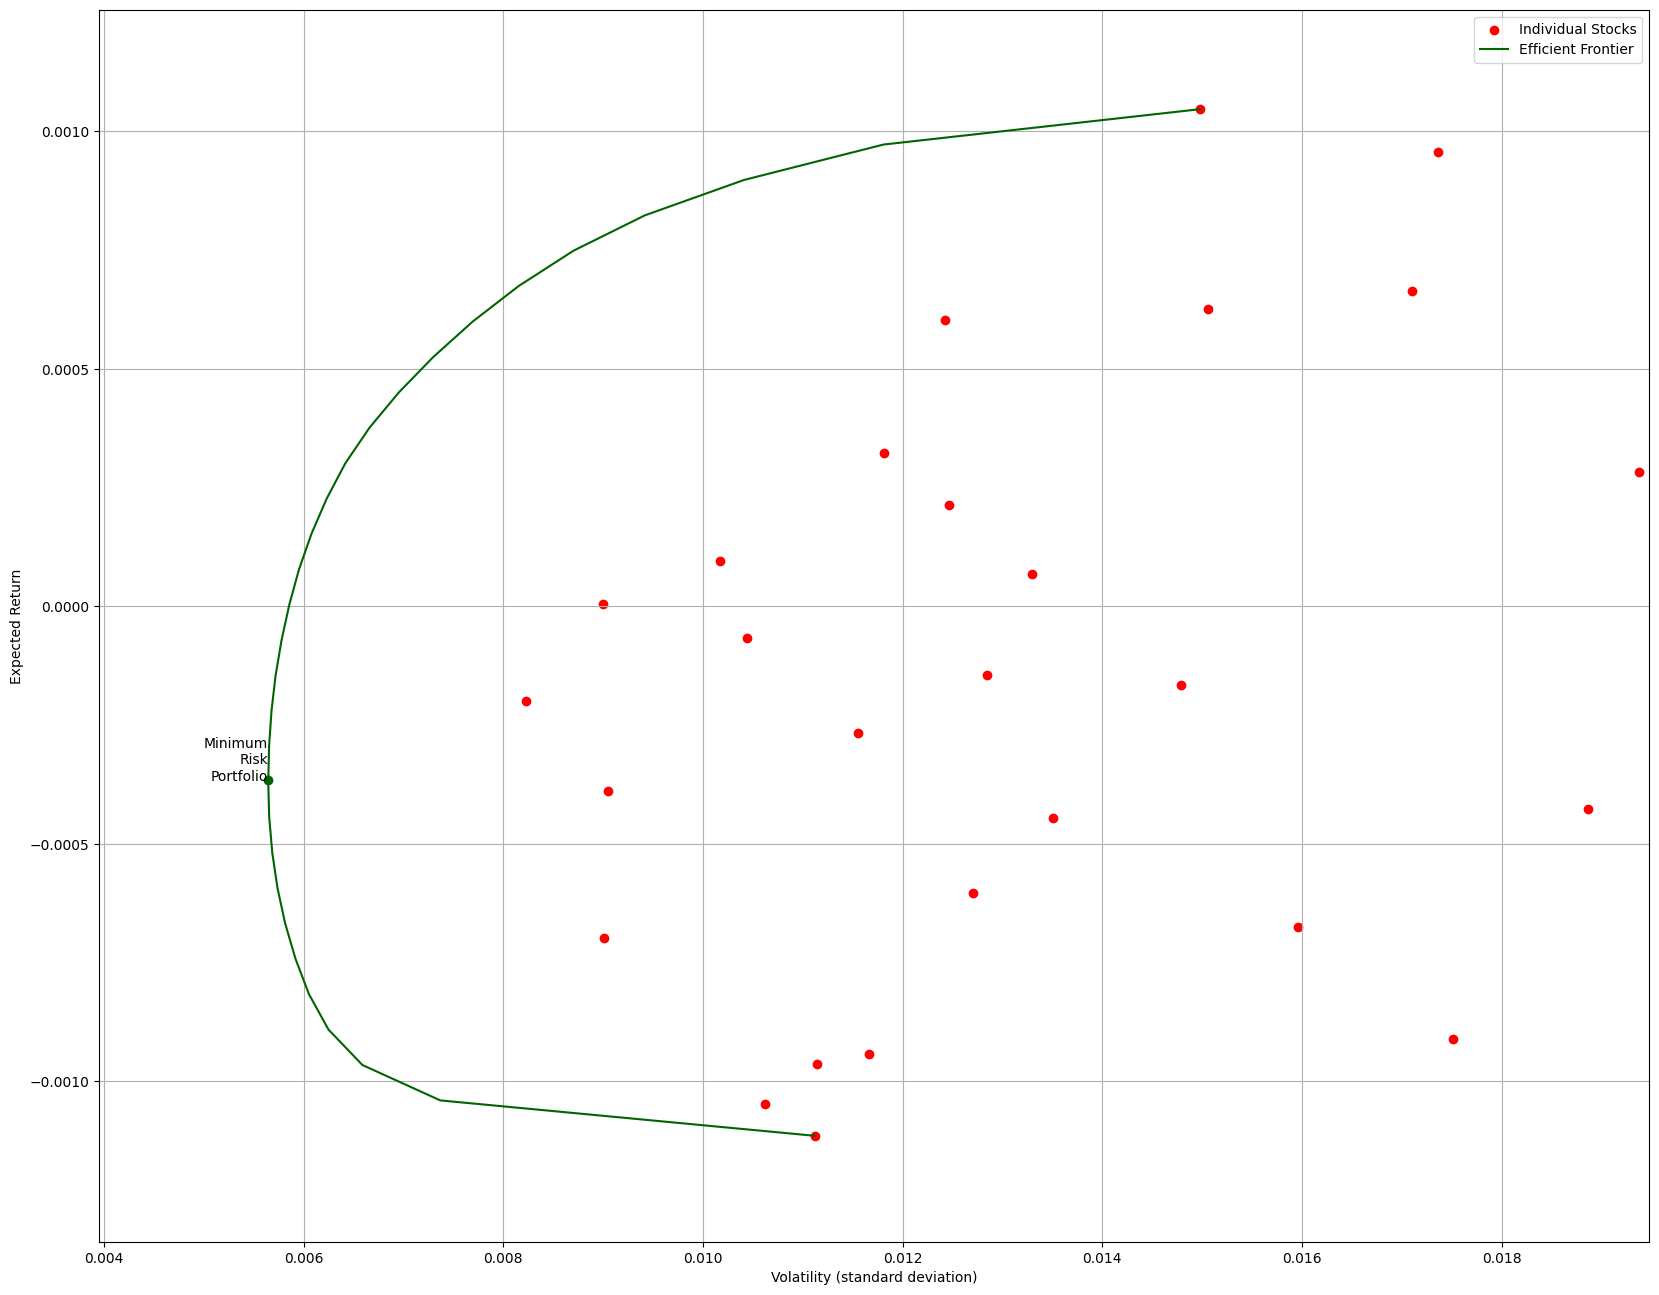

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x71fa6bef
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.89925600e+05 -2.89925600e+05  2.75e+04 5.36e-05  1.00e+0

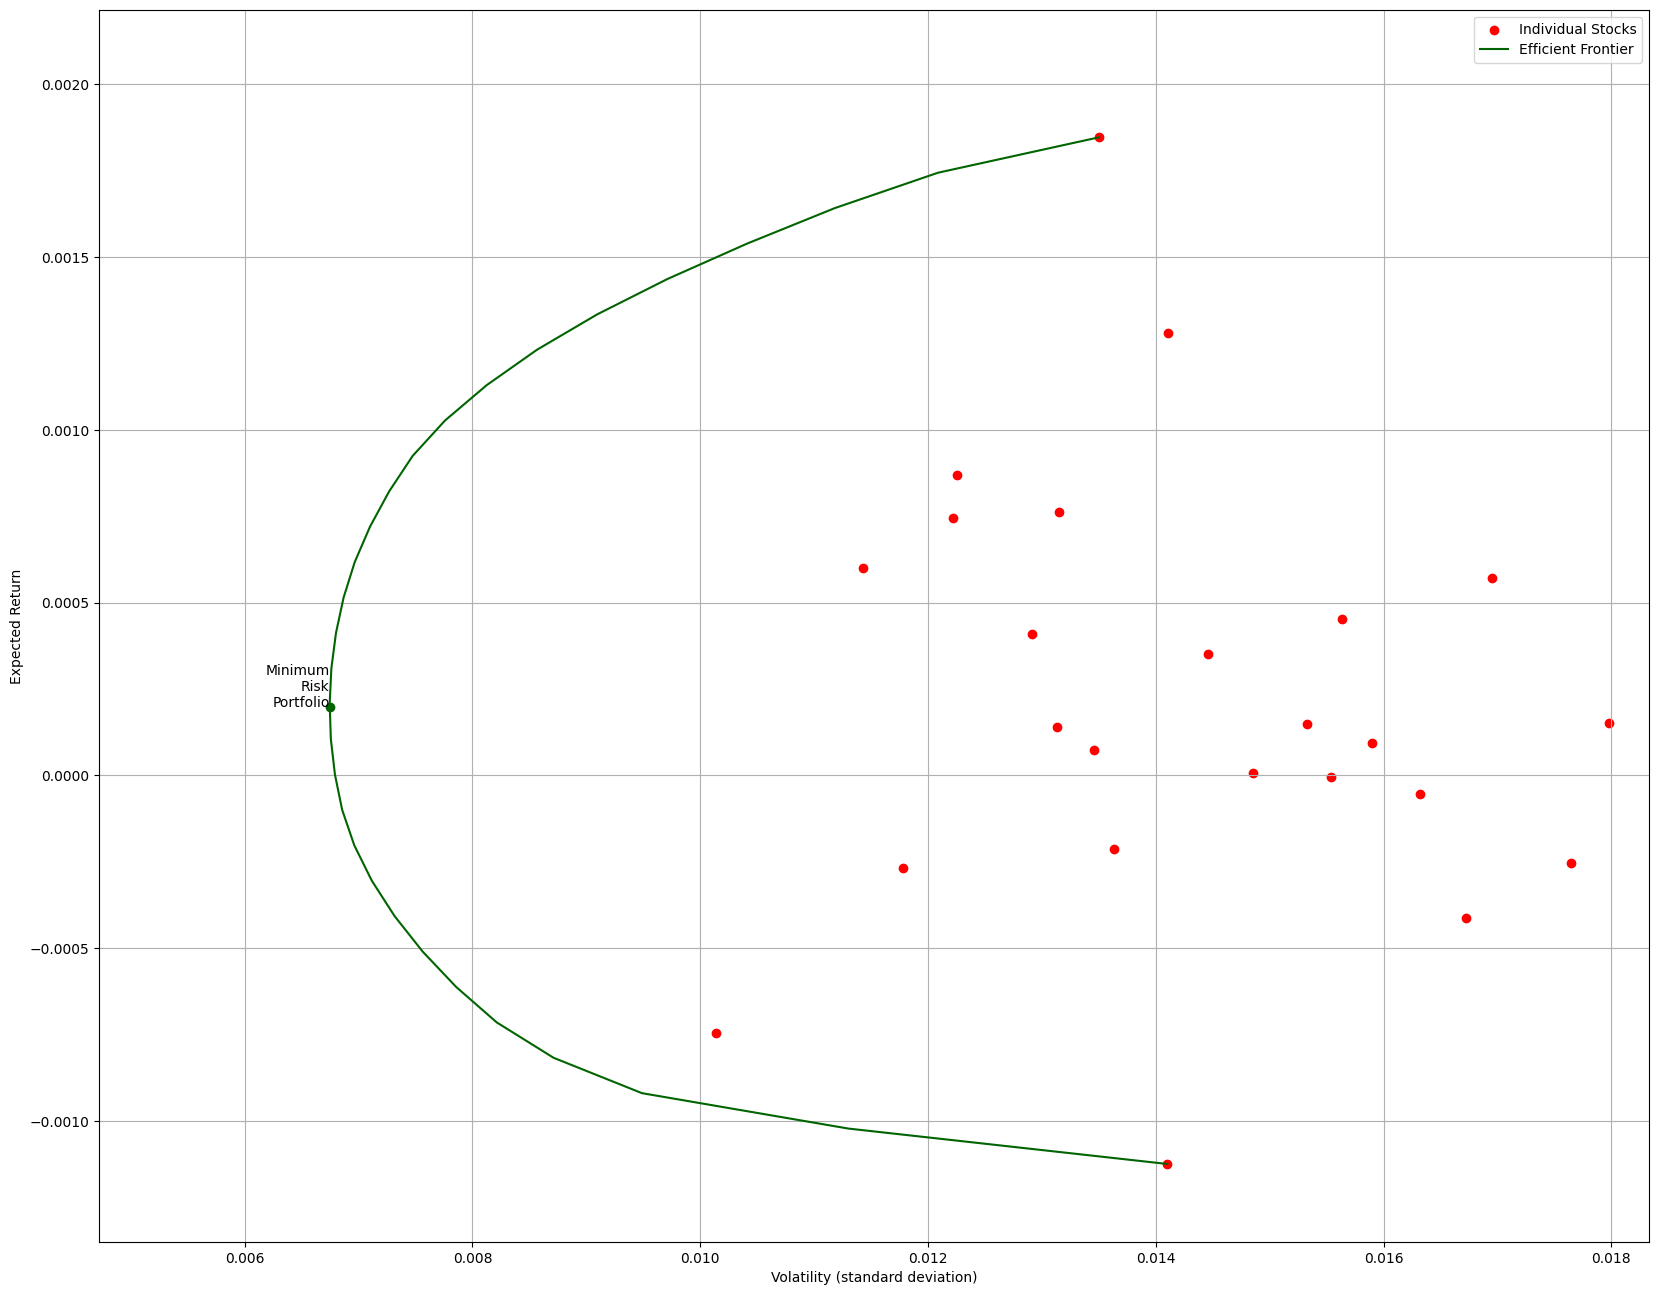

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x37b34995
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.33313395e+05 -2.33313395e+05  2.65e+04 8.83e-08  1.00e+0

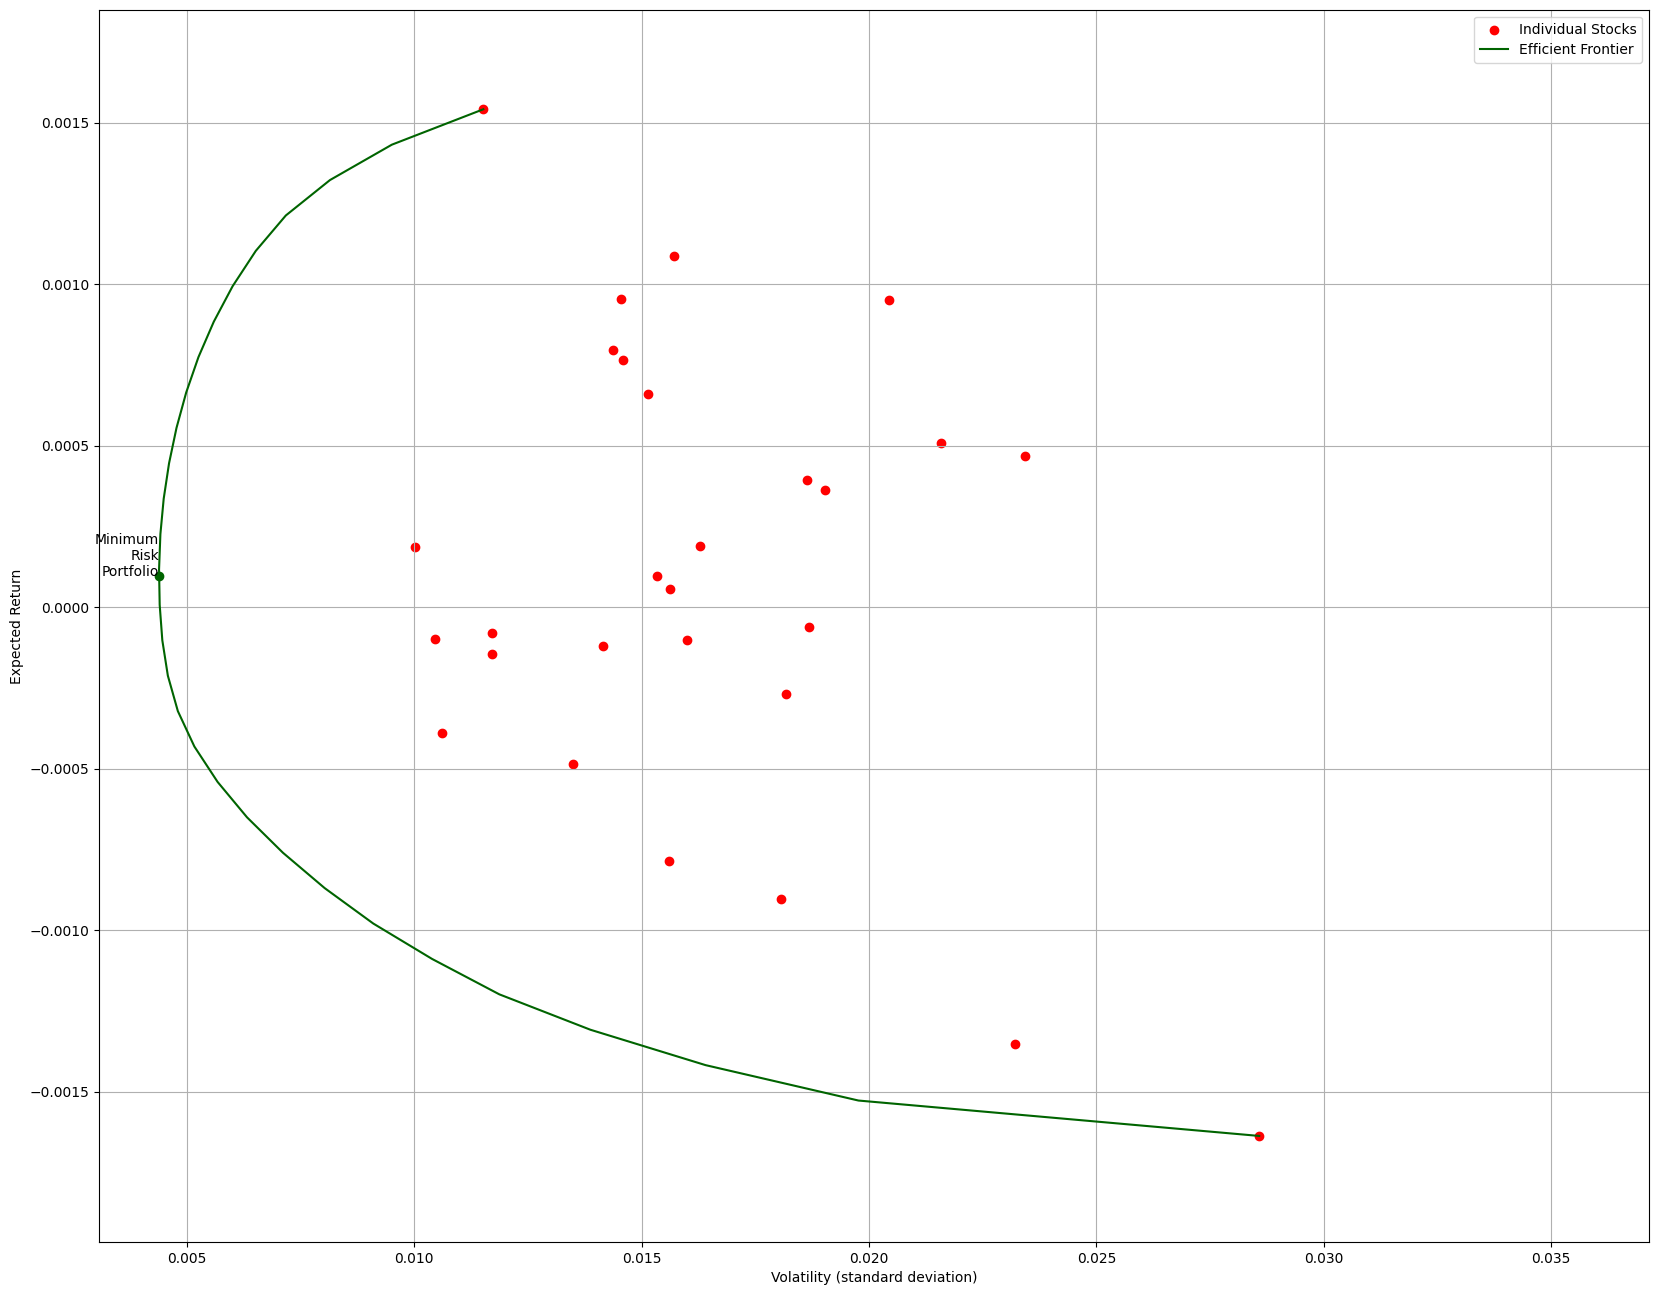

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0xe7bfdbff
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41183768e+05 -1.41183768e+05  2.80e+04 1.92e-06  1.00e+0

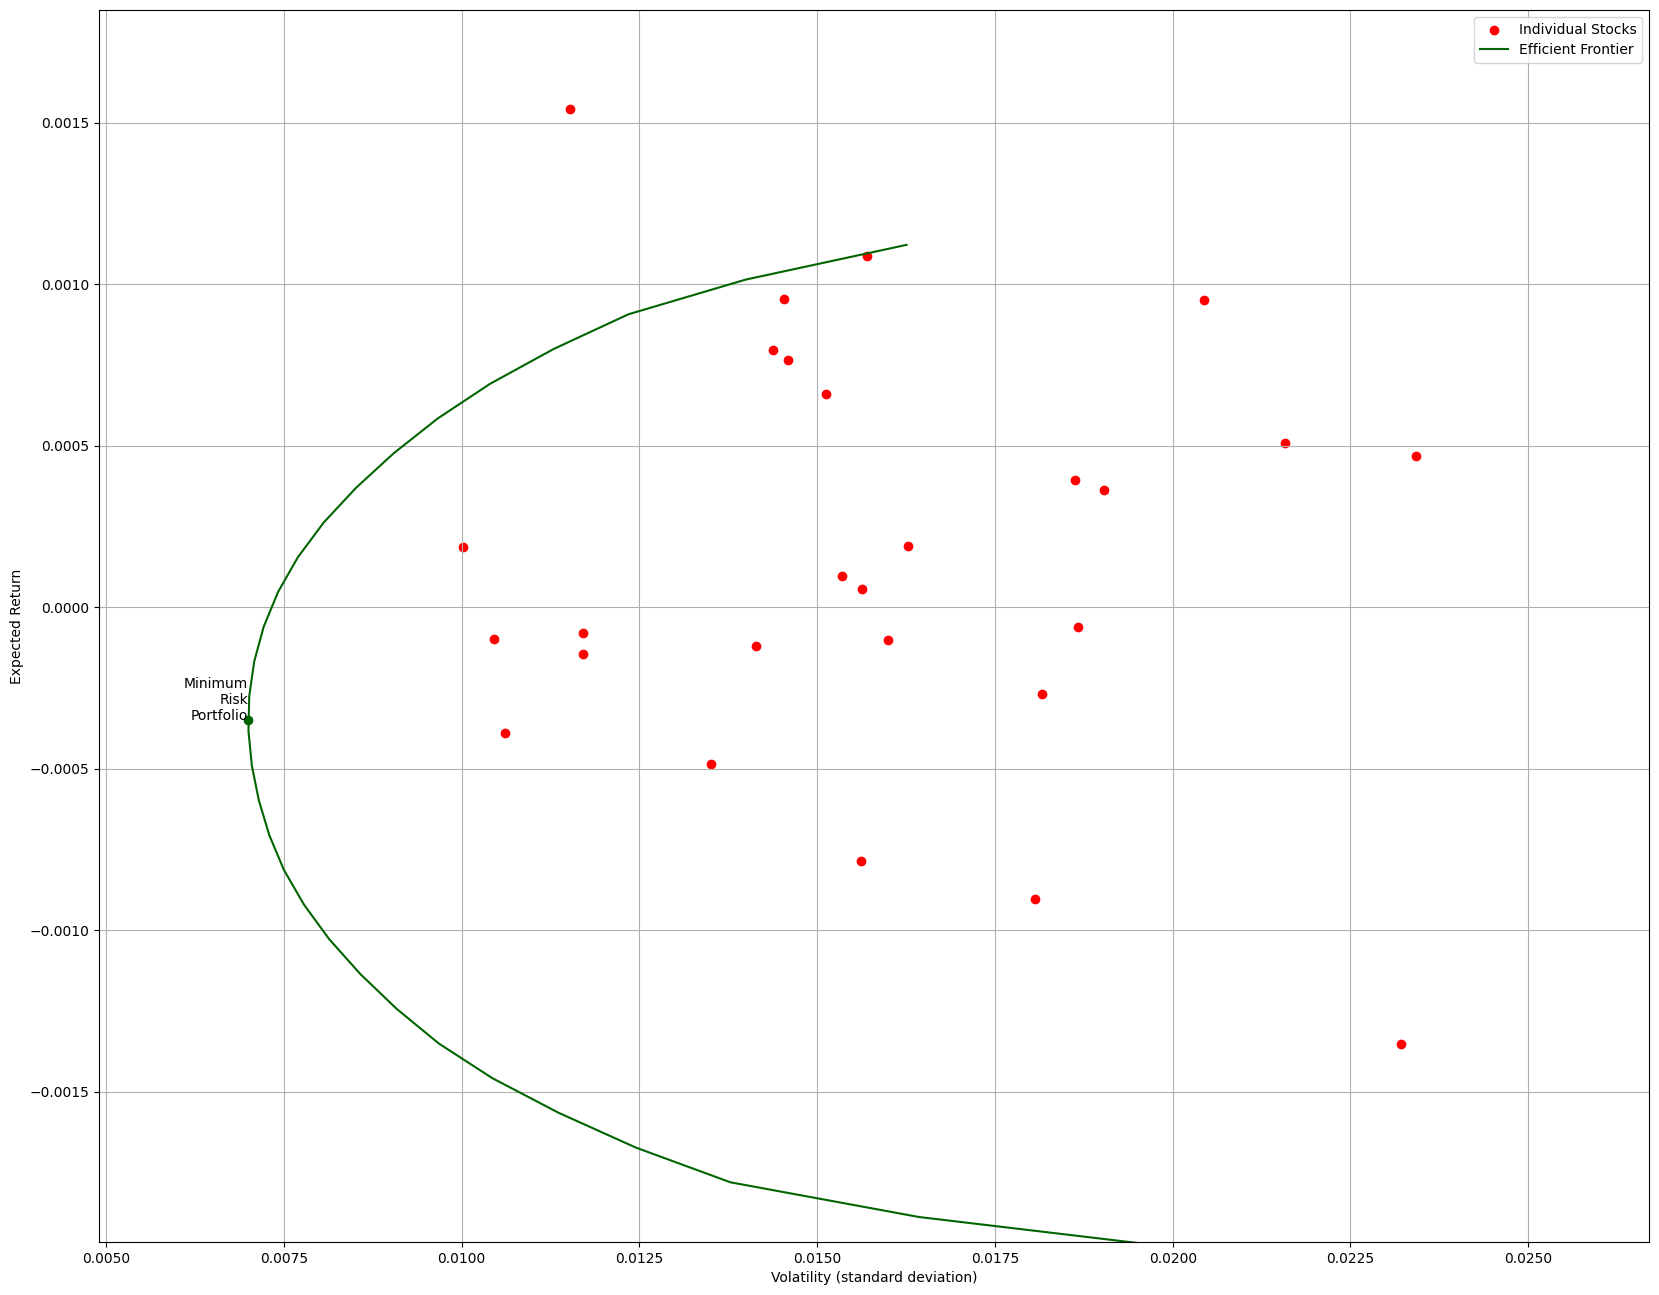

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x2f1c4daa
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.29758098e+05 -2.29758098e+05  2.80e+04 3.18e-07  1.00e+0

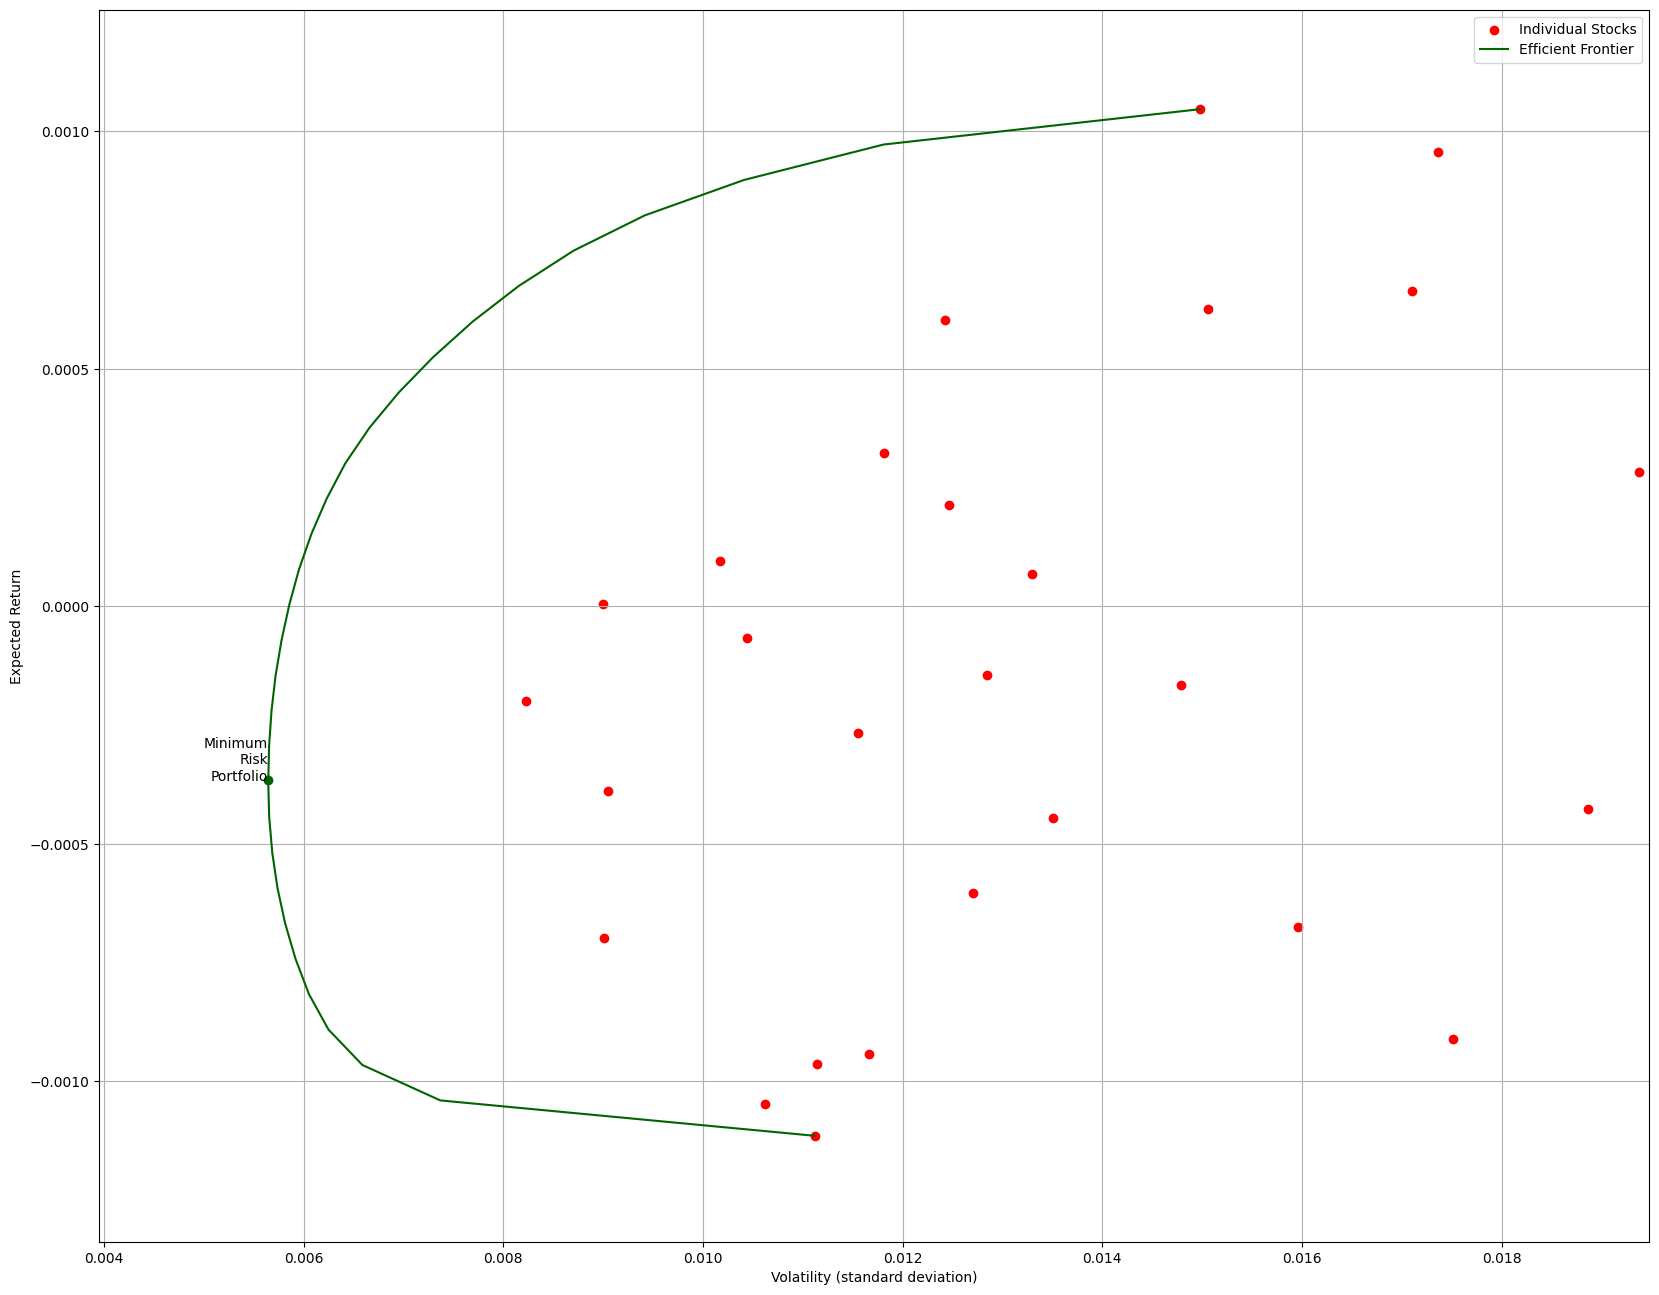

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x71fa6bef
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.89925600e+05 -2.89925600e+05  2.75e+04 5.36e-05  1.00e+0

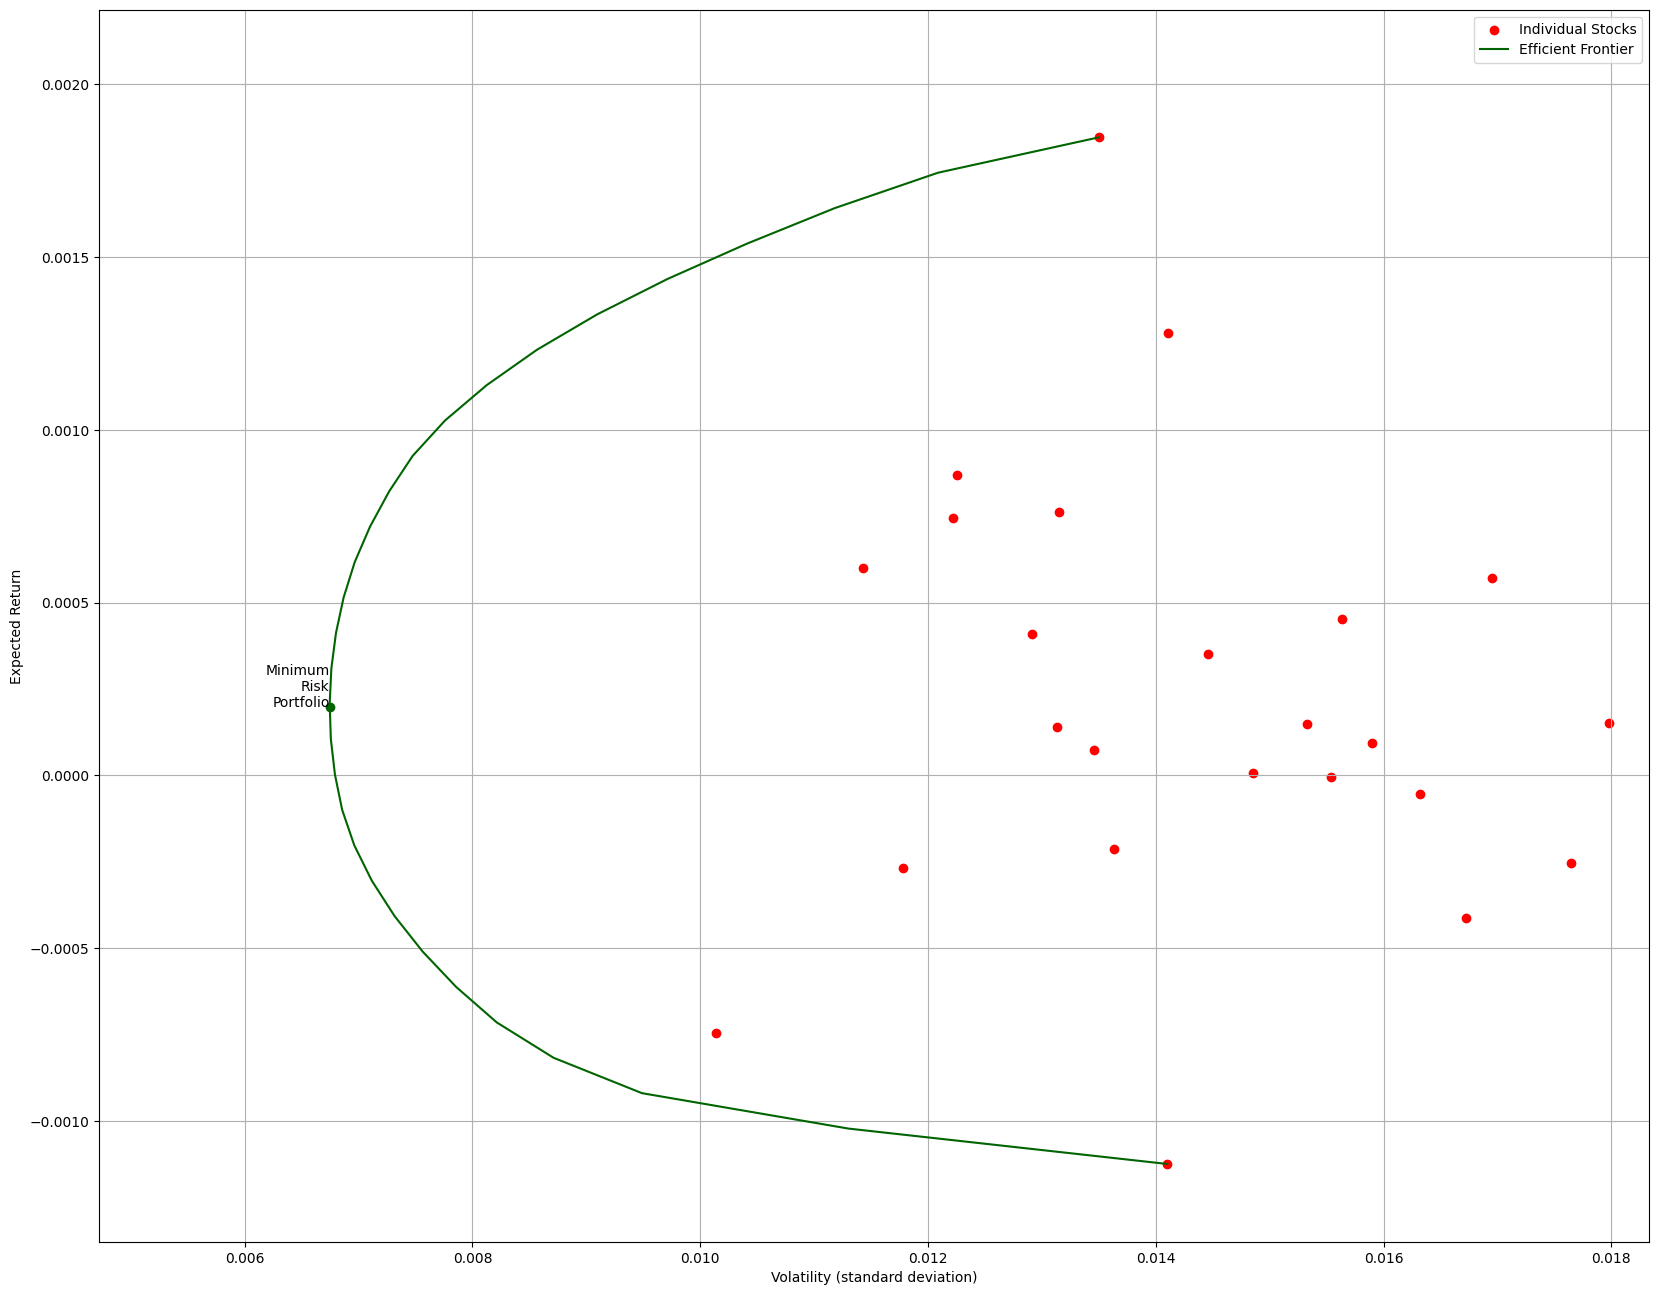

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x37b34995
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-07, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.33313395e+05 -2.33313395e+05  2.65e+04 8.83e-08  1.00e+0

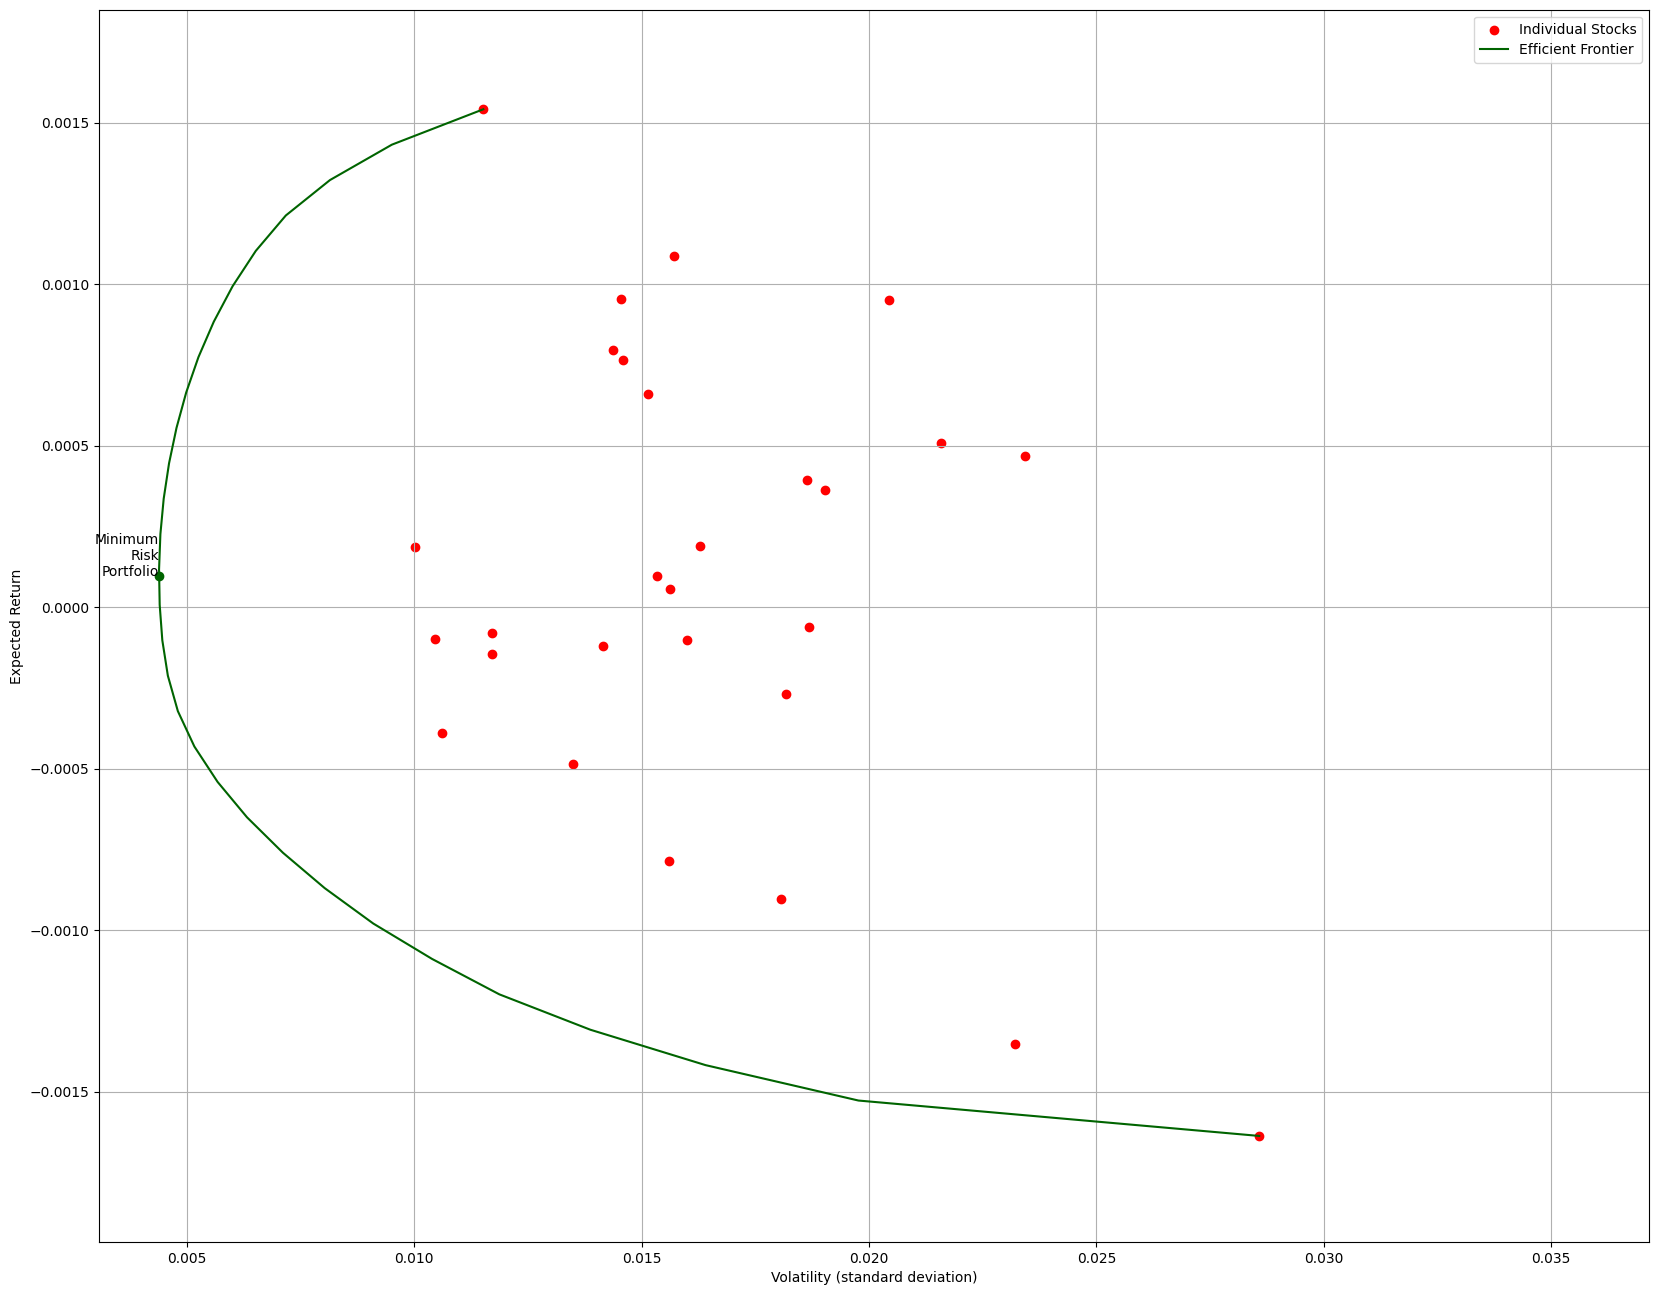

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0xe7bfdbff
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-06, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41183768e+05 -1.41183768e+05  2.80e+04 1.92e-06  1.00e+0

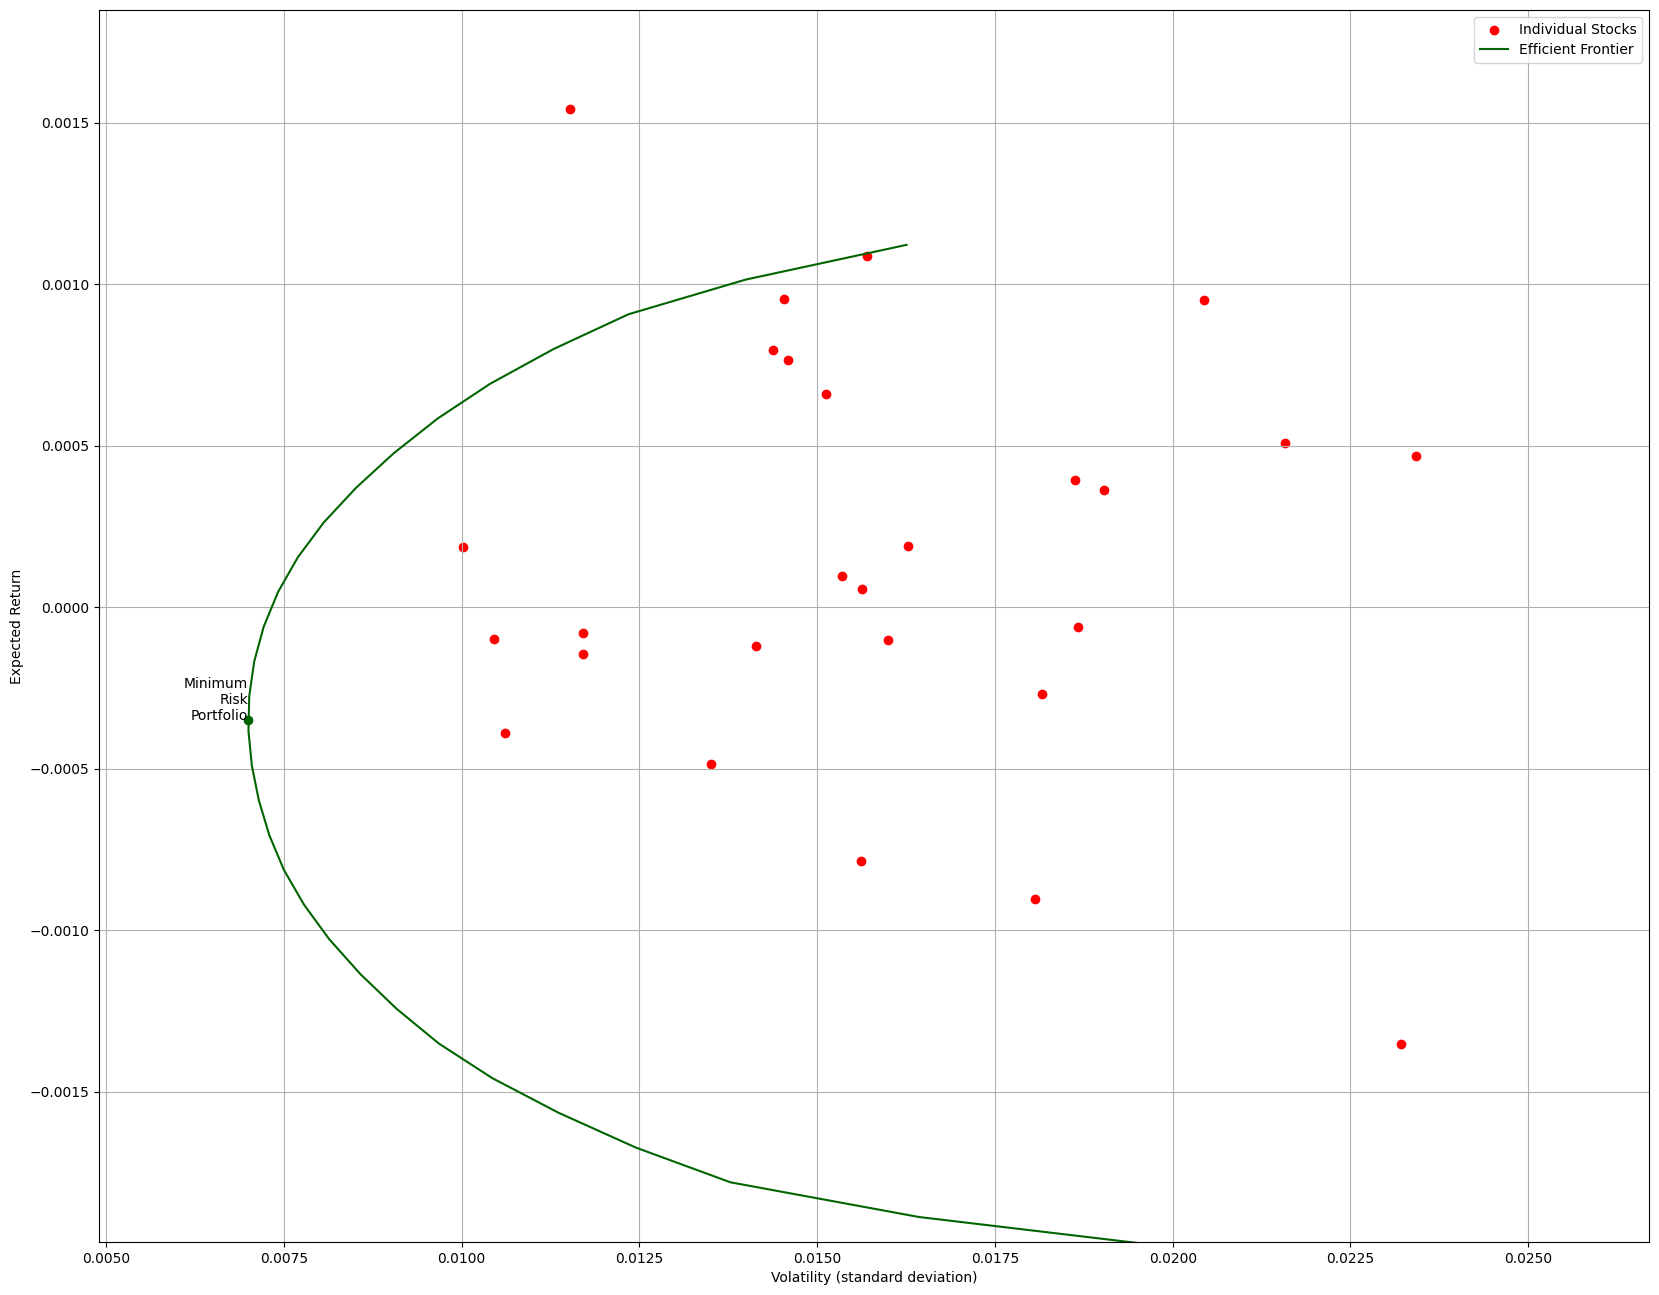

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x2f1c4daa
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.29758098e+05 -2.29758098e+05  2.80e+04 3.18e-07  1.00e+0

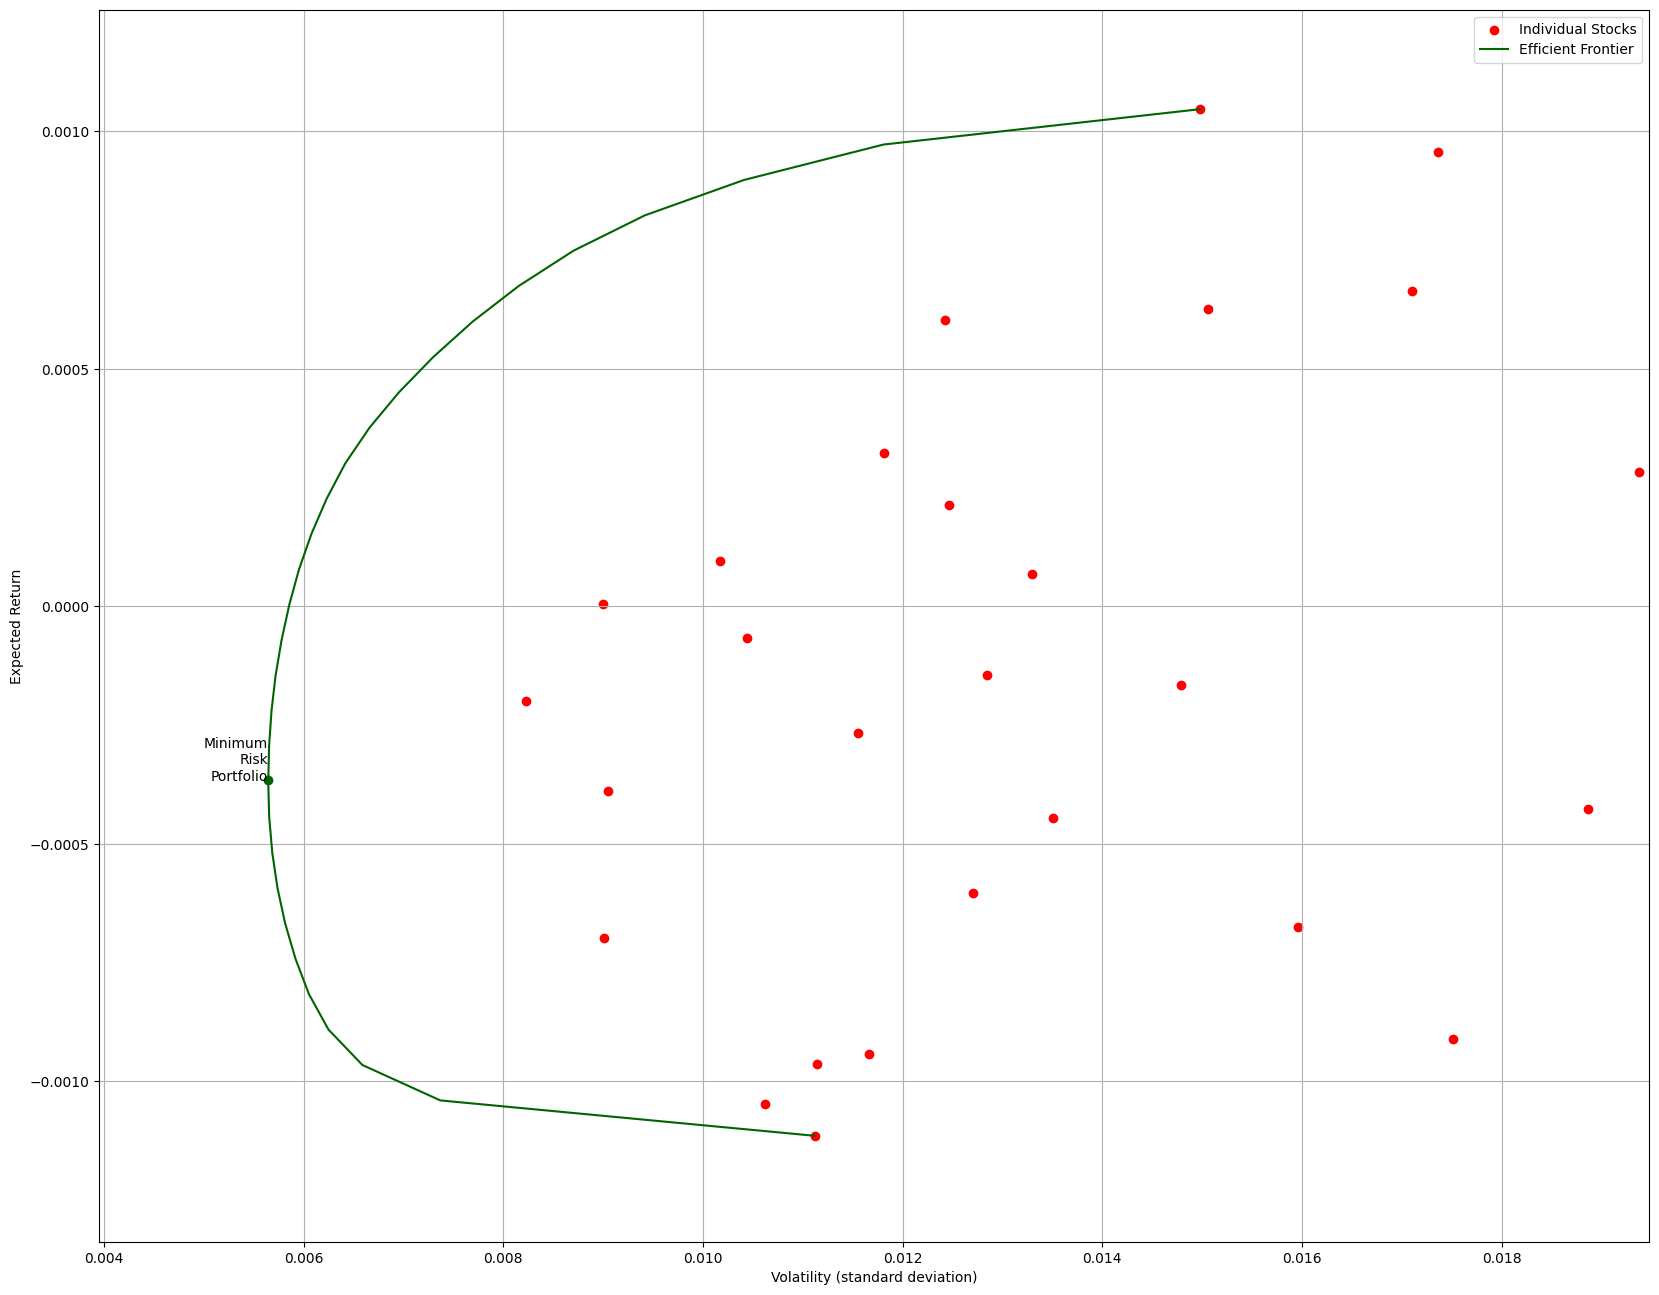

(5159, 28)
(28,)
(28, 28)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 28 columns and 28 nonzeros
Model fingerprint: 0x71fa6bef
Model has 406 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 28 columns, 28 nonzeros
Presolved model has 406 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 27
 AA' NZ     : 3.780e+02
 Factor NZ  : 4.060e+02
 Factor Ops : 7.714e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.89925600e+05 -2.89925600e+05  2.75e+04 5.36e-05  1.00e+0

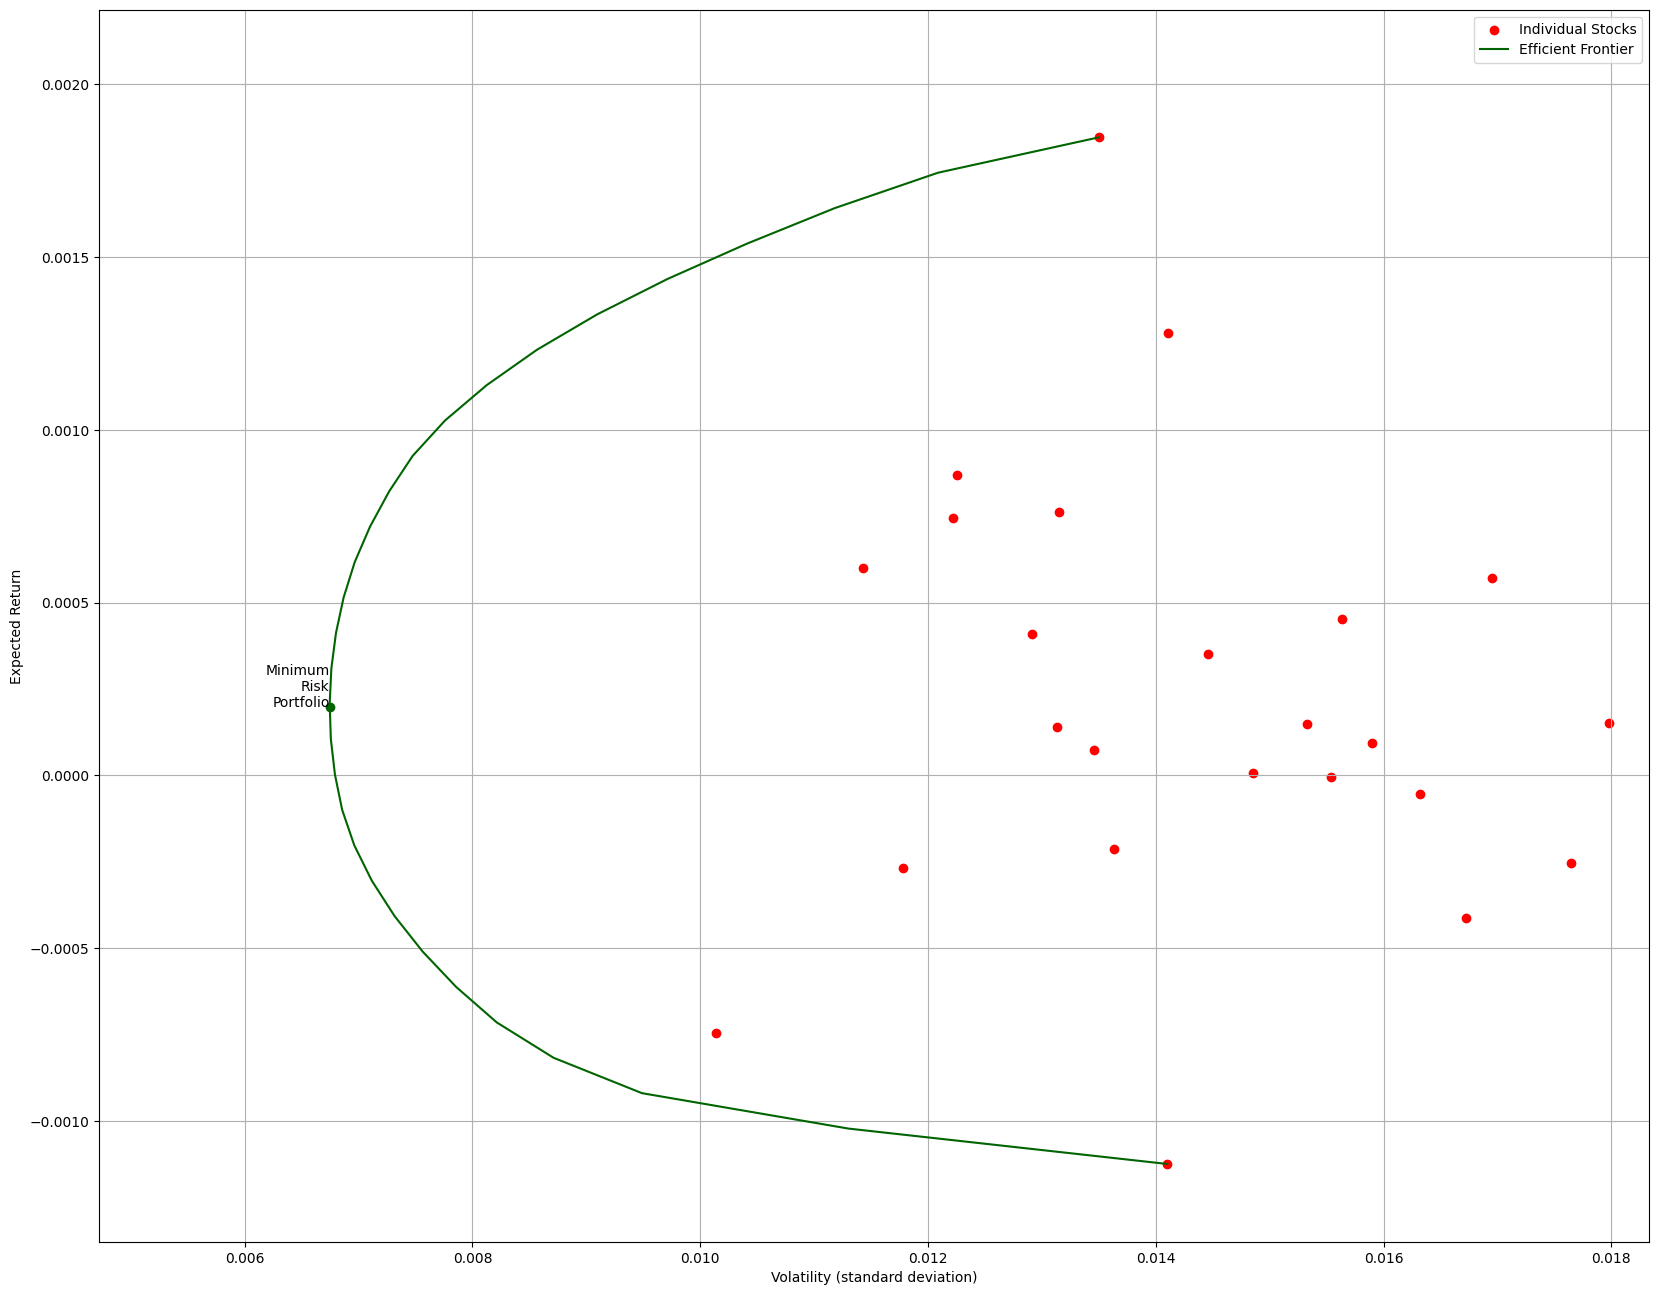

In [ ]:
df_new=pd.DataFrame()
for e in np.linspace(0.1, 0.9, 9):
    df1, minimum_risk_portfolio11 = period1 ()
    df2, minimum_risk_portfolio22 = period2 (e, minimum_risk_portfolio11)
    df3, minimum_risk_portfolio32 = period3 (e, minimum_risk_portfolio22)
    df4 = period4 (e, minimum_risk_portfolio32)
    df_new=pd.concat([df_new,df1,df2,df3,df4],ignore_index=True)

In [ ]:
df_new

,Period,Model,Min_Risk_Return,Min_Risk_Volatility,e
0,1,Without Turnover Constraints,0.000097,0.004389,NaN
1,1,With Turnover Constraints,-,-,NaN
2,2,Without Turnover Constraints,-0.000349,0.006997,0.1
3,2,With Turnover Constraints,-0.000386,0.007154,0.1
4,3,Without Turnover Constraints,-0.000366,0.005646,0.1
...,...,...,...,...,...
67,2,With Turnover Constraints,-0.000349,0.006997,0.9
68,3,Without Turnover Constraints,-0.000366,0.005646,0.9
69,3,With Turnover Constraints,-0.000368,0.005645,0.9
70,4,Without Turnover Constraints,0.000198,0.006747,0.9


In [ ]:
df_new.to_excel('Portfolio_Opti_Results.xlsx', sheet_name='sheet1', index=False)